In [1259]:
import random
import pandas as pd
import numpy as np
import scipy.stats as sp
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from itertools import product
from collections import namedtuple
from abc import ABC, abstractmethod
from scipy.stats import beta
from sklearn.preprocessing import normalize

from tqdm import tqdm

from fuzzylogic.classes import Rule
from fuzzylogic.classes import Domain
from fuzzylogic.classes import Domain, Set
from fuzzylogic.functions import (R, S, sigmoid, gauss, trapezoid,  triangular,
                             triangular_sigmoid, rectangular, singleton)
from faker import Faker


%matplotlib inline
sns.set()

In [1456]:
class DomainCorrected(Domain):
    __slots__ = ['_name', '_low', '_high', '_res', '_sets']

    def __init__(self, name, low, high, *, res=1, sets:dict=None):
        """Define a domain."""
        assert low < high, "higher bound must be greater than lower."
        assert res > 0, "resolution can't be negative or zero"
        self._name = name
        self._high = high
        self._low = low
        self._res = res
        self._sets = {} if sets is None else sets  # Name: Set(Function())
        
    def __setattr__(self, name, value):
        """Define a set within a domain or assign a value to a domain attribute."""
        # It's a domain attr
        if name in self.__slots__:
            object.__setattr__(self, name, value)
        # We've got a fuzzyset
        else:
            assert str.isidentifier(name), f"{name} must be an identifier."
            if not isinstance(value, Set):
                # Often useful to just assign a function for simple sets..
                value = SetCorrected(value)
            # However, we need the abstraction if we want to use Superfuzzysets (derived sets).
            self._sets[name] = value
            value.domain = self
            value.name = name

class SetCorrected(Set):
    
    def __init__(self, func:callable, *, name=None, domain=None):

        self.func = func
        self.domain = domain
        self.name = name
        self.__center_of_gravity = None

    @property
    def center_of_gravity(self):
        """Return the center of gravity for this distribution, within the given domain."""
        if self.__center_of_gravity is not None:
            return self.__center_of_gravity
        
        domain_res = self.domain._res
        A = self.array()
        cog = np.average(np.arange(len(A) * domain_res, step = domain_res), weights= A)
        self.__center_of_gravity = cog
        return cog
    
    def plot(self, label = None):
        """Graph the set in the given domain."""
        if self.domain is None:
            raise FuzzyWarning("No domain assigned, cannot plot.")
        R = self.domain.range
        V = [self.func(x) for x in R]
        return plt.plot(R, V, label=label)
    
class RuleCorrected(Rule):
    """
    A collection of bound sets that span a multi-dimensional space of their respective domains.
    """
    def __init__(self, conditions, func=None):
        self.conditions = conditions
        self.func = func
    
    def __call__(self, args:"dict[Domain, float]", method="cog"):
        """Calculate the infered value based on different methods.
        Default is center of gravity.
        """
        assert len(args) == max(len(c[1:]) for c in self.conditions.keys()), "Number of values must correspond to the number of domains defined as conditions!"
        assert isinstance(args, dict), "Please make sure to pass in the values as a dictionary."
        if method == "cog":
            actual_values = {f: f(args[f.domain]) for S in self.conditions.keys() for f in S[1:]}
            weights = [(v, x) for K, v in self.conditions.items()
                        if (x := min(actual_values[k] for k in K[1:] if k in actual_values)) > 0]
            if not weights:
                return None
            return sum(v.center_of_gravity * x for v, x in weights) / sum(x for v, x in weights)

In [1260]:
def run_spec(spec):
    
    env_spec = spec['env']
    n_experiments = spec['n_experiments']
    n_action = env_spec['n_action']
    n_iter = env_spec['n_iter']
    env = Environment(bandits = BANDITS, **env_spec)
    alg_cnt = len(spec['alg'])
    results = [{
                'mean_reward': np.zeros(n_iter), 
                'mean_regret': np.zeros(n_iter), 
                'total_cnt': np.zeros(n_action),
                'cumulative_reward': np.zeros(n_iter),
                'actions_history': np.zeros((n_iter, n_action))
                } for i in range(alg_cnt)]
    
    for i in tqdm(range(n_experiments)):
        for a in range(alg_cnt):      
            bandit, _, _,  mean_rewards, mean_regrets, cumulative_reward, ids = \
                Experiment.run(env, generate_stats=False, **spec['alg'][a])
            results[a]['mean_reward']  = results[a]['mean_reward'] + (mean_rewards - results[a]['mean_reward']) / (i + 1)
            results[a]['mean_regret']  = results[a]['mean_regret'] + (mean_regrets - results[a]['mean_regret']) / (i + 1)
            results[a]['total_cnt']  = results[a]['total_cnt'] + (bandit.bandit_cnt - results[a]['total_cnt']) / (i + 1)
            results[a]['cumulative_reward']  = results[a]['cumulative_reward'] + (cumulative_reward - results[a]['cumulative_reward']) / (i + 1)

            for j, action_id in enumerate(ids):
                results[a]['actions_history'][j][action_id] += 1
    
    return results

In [1261]:
class Bandit:
    __type__ = 'base'
    
    def __init__(self, action_cnt, **kwargs):
        assert action_cnt > 0, "Number of action must be greater than zero!"
        
        self.action_cnt = action_cnt
        self.reward_cnt = np.array([0.] * self.action_cnt)
        self.bandit_cnt = np.array([0] * self.action_cnt)
        self.regrets =  np.array([0.])
        self.reward_estimate = np.array([0.0] * self.action_cnt)
        self.mean_reward = 0.
        self.mean_regret = 0.
        self.accuracy = 0.
        self.pull_cnt = 0
        
    def update_estimates(self, a, r, regret, get_correct, **kwargs):
        self.bandit_cnt[a] += 1
        self.reward_cnt[a] += r
        np.append(self.regrets, regret)
        self.reward_estimate[a] = self.reward_estimate[a] + 1 / (self.bandit_cnt[a] + 1) * (r - self.reward_estimate[a])
        
        self.mean_reward = self.mean_reward + (r - self.mean_reward) / (self.pull_cnt + 1)
        self.mean_regret = self.mean_regret + (regret - self.mean_regret) / (self.pull_cnt + 1)
        self.accuracy = self.accuracy + (get_correct - self.accuracy) / (self.pull_cnt + 1)
        
    @abstractmethod
    def pull(self):
        pass
    
    def generate_stats(self, total_reward, total_regret, **kwrags):
        print('='*20,'STATS', '='*20)
        print(f'Type of the bandit: {self.__type__}'.center(20))
        print(f'Total reward: {total_reward}')
        print(f'Total regret: {total_regret}')
        print(f'Accuracy: {self.accuracy}')
        print(f'Bandits pull count: {self.bandit_cnt}')
        print(f'Reward from all bandit: {self.reward_cnt}')
        print(f'Reward estimate all bandit: {self.reward_estimate}')
        print('='*47)
    
class RandomBandit(Bandit):
    __type__ = 'random'
    
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        
    def pull(self, **kwargs):
        a = np.random.randint(0, self.action_cnt)
        self.pull_cnt += 1
        return a
    
class UCB1_Bandit(Bandit):
    __type__ = 'ucb1'
    
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        
        
    def pull(self, **kwargs):
        # сначала хотя бы раз пробуем каждый вариант
        for i in range(self.action_cnt):
            if self.bandit_cnt[i] == 0:
                return i
        total_cnt = np.sum(self.bandit_cnt)
        a = np.argmax(self.reward_estimate + np.sqrt(2 * np.log(total_cnt) / self.bandit_cnt))
        self.pull_cnt += 1
        return a
    
    def generate_stats(self, total_reward, total_regret, **kwrags):
        print('='*20,'STATS', '='*20)
        print(f'Type of the bandit: {self.__type__}'.center(20))
        print(f'Total reward: {total_reward}')
        print(f'Total regret: {total_regret}')
        print(f'Accuracy: {self.accuracy}')
        print(f'Bandits pull count: {self.bandit_cnt}')
        print(f'Reward from all bandit: {self.reward_cnt}')
        print(f'Reward estimate all bandit: {self.reward_estimate}')
        print('='*47)

In [1262]:
class LinUCB(Bandit):
    __type__ = 'lin_ucb'
    
    def __init__(self, n_dims, alpha = 0.01, **kwargs):
        super().__init__(**kwargs)
        self.alpha = alpha
        self.n_dims = n_dims
        self.A = np.zeros((self.action_cnt, self.n_dims, self.n_dims))
        self.b = np.zeros((self.action_cnt, self.n_dims, 1))
        
        for action in range(self.action_cnt):
            self.A[action] = np.eye(self.n_dims)
            
        self.theta_hat = None
        
    def pull(self, context):
        inv_a = np.linalg.inv(self.A)
        self.theta_hat = inv_a @ self.b
        p_t = self.theta_hat.reshape(self.theta_hat.shape[0], self.theta_hat.shape[1]) @ context.reshape(-1,1) 
        p_t += self.alpha * (np.sqrt(context.T @ inv_a @ context.reshape(-1,1)))
        return np.where(p_t==max(p_t))[0][0]
    
    def update_estimates(self, a, r, regret, context, get_correct):
        self.bandit_cnt[a] += 1
        self.reward_cnt[a] += r
        np.append(self.regrets, regret)
        self.A[a] += context @ context.reshape(-1, 1)
        self.b[a] += r * context.reshape(-1, 1)
        
        self.accuracy = self.accuracy + (get_correct - self.accuracy) / (self.pull_cnt + 1)
        self.mean_reward = self.mean_reward + (r - self.mean_reward) / (self.pull_cnt + 1)
        self.mean_regret = self.mean_regret + (regret - self.mean_regret) / (self.pull_cnt + 1)
        self.pull_cnt += 1
        
    def generate_stats(self, total_reward, total_regret, **kwrags):
        print('='*20,'STATS', '='*20)
        print(f'Type of the bandit: {self.__type__}'.center(20))
        print(f'Total reward: {total_reward}')
        print(f'Total regret: {total_regret}')
        print(f'Accuracy: {self.accuracy}')
        print(f'True success probabilities: {kwrags["env_thetas"]}')
        print(f'Bandits pull count: {self.bandit_cnt}')
        print(f'Estimates of success probability: {self.theta_hat}')
        print(f'Reward from all bandit: {self.reward_cnt}')
        print('='*47)

In [1263]:
class LinPRUCB(Bandit):
    __type__ = 'lin_prucb'
    
    def __init__(self, n_dims, alpha = 0.1, beta = 0.1, etha = 0.8, **kwargs):
        super().__init__(**kwargs)
        self.alpha = alpha
        self.beta = beta
        self.etha = etha
        self.n_dims = n_dims
        
        self.b = np.zeros((self.action_cnt, self.n_dims, 1))
        self.b_pseudo = np.zeros((self.action_cnt, self.n_dims, 1))
        
        self.v = np.zeros((self.action_cnt, self.n_dims,  self.n_dims))
        self.v_pseudo = np.zeros((self.action_cnt, self.n_dims,  self.n_dims))
        
        self.A_hat = np.zeros((self.action_cnt, self.n_dims, self.n_dims))
        
        for action in range(self.action_cnt):
            self.A_hat[action] = np.eye(self.n_dims)
            
        self.theta_hat = np.zeros((self.action_cnt, self.n_dims, 1))
        
    def pull(self, context):
        inv_a = np.linalg.inv(self.A_hat)
        p_t = self.theta_hat.reshape(self.theta_hat.shape[0], self.theta_hat.shape[1]) @ context.reshape(-1,1) 
        p_t += self.alpha * (np.sqrt(context.T @ inv_a @ context.reshape(-1,1)))
        return np.where(p_t==max(p_t))[0][0]
    
    def update_estimates(self, a, r, regret, context, get_correct):
        self.bandit_cnt[a] += 1
        self.reward_cnt[a] += r
        np.append(self.regrets, regret)
        
        for a_i in range(self.action_cnt):
            inv_a = np.linalg.inv(self.A_hat[a])
            if a_i == a:
                self.v[a] += context @ context.reshape(-1, 1)
                self.b[a] += r * context.reshape(-1, 1)
            else:
                p_t = self.theta_hat[a].reshape(1, -1) @ context.reshape(-1,1) 
                p_t += self.beta * (np.sqrt(context.T @ inv_a @ context.reshape(-1,1)))
                pseudo_reward = max(-1, min(0, p_t))
                self.v_pseudo[a] = self.etha * self.v_pseudo[a] + context @ context.reshape(-1, 1)
                self.b_pseudo[a] = self.etha * self.b_pseudo[a] + p_t * context.reshape(-1, 1)
            self.A_hat[a] = np.eye(self.n_dims) + self.v[a] + self.v_pseudo[a]
            self.theta_hat[a] = np.linalg.inv(self.A_hat[a]) @  (self.b[a] + self.b_pseudo[a])
            
        self.mean_reward = self.mean_reward + (r - self.mean_reward) / (self.pull_cnt + 1)
        self.mean_regret = self.mean_regret + (regret - self.mean_regret) / (self.pull_cnt + 1)
        self.accuracy = self.accuracy + (get_correct - self.accuracy) / (self.pull_cnt + 1)
        self.pull_cnt += 1
    
    def generate_stats(self, total_reward, total_regret, **kwrags):
        print('='*20,'STATS', '='*20)
        print(f'Type of the bandit: {self.__type__}'.center(20))
        print(f'Total reward: {total_reward}')
        print(f'Total regret: {total_regret}')
        print(f'Accuracy: {self.accuracy}')
        print(f'True success probabilities: {kwrags["env_thetas"]}')
        print(f'Bandits pull count: {self.bandit_cnt}')
        print(f'Estimates of success probability: {self.theta_hat}')
        print(f'Reward from all bandit: {self.reward_cnt}')
        print('='*47)
        

In [1264]:
class ContextLinEnvironment:
    
    def __init__(self, n_iter, bandits, n_action=5, n_dims = 10, context = None, thetas = None):
        self.n_iter = n_iter
        self.n_action = n_action
        self.bandits = bandits
        self.n_dims = n_dims
        
        self.bandits_params = dict(action_cnt=self.n_action, n_dims=self.n_dims)
        
        if context is None:
            self.context = self.generate_random_uniform_vector(n_iter, n_dims)
        else:
            self.context = context
        
        if thetas is None:
            self.thetas = self.generate_random_uniform_vector(n_action, n_dims)
        else:
            self.thetas = thetas
            
        self.true_rewards = self.generate_true_rewards(self.context, self.thetas)
            
        self.best_actions = np.max(self.true_rewards, axis=1)
        self.best_actions_idx = np.argmax(self.true_rewards, axis=1)
    
    def generate_random_uniform_vector(self, n_samples, n_dims):
        """Generate random vector  of size (n_samples, n_dims).
        Each value is generated from uniform distribution and normilized to unit length vector"""
        
        random_vectors = np.random.uniform(size=(n_samples, n_dims))
        random_vectors_normalized = normalize(random_vectors, norm = 'l2', axis=1)
        return random_vectors_normalized
    
    def generate_true_rewards(self, context, thetas):
        """Generate rewards for all action in each iteration with some noise. 
        Final size: (n_samples, n_action)"""
        return context @ thetas.T + np.random.normal(loc=0.0, scale=0.05, size=(self.context.shape[0], self.thetas.shape[0]))
        
    def get_reward(self, n_sample, ids):
        return self.true_rewards[n_sample, ids]
    
    def get_regret(self, n_sample, ids):
        return self.best_actions[n_sample] - self.get_reward(n_sample, ids)
    
    def get_correct_idx(self, n_sample):
        return self.best_actions_idx[n_sample]

In [1270]:
class Experiment:
                
    @classmethod
    def run(cls, env, type_ = 'greedy', generate_stats = True, **kwargs):
        ExpResults = namedtuple('ExpResults', ['bandit', 
                                  'total_reward', 
                                  'total_regret', 
                                  'mean_reward', 
                                  'mean_regret', 
                                  'cumulative_reward', 
                                  'ids',
                                  'accuracy'])
        
        bandit_c = [bandit for bandit in env.bandits if bandit.__dict__['__type__'] == type_][0]
        bandit = bandit_c(**env.bandits_params, **kwargs)
        
        total_reward = 0
        total_regret = 0.
        
        mean_reward = np.zeros(env.n_iter)
        mean_regret = np.zeros(env.n_iter)
        accuracy = np.zeros(env.n_iter)
        
        cumulative_reward = np.zeros(env.n_iter)
        
        ids = np.zeros(env.n_iter, dtype=int)
        get_correct = 0
        for i in range(env.n_iter):
            a_max_ind = bandit.pull(context = env.context[i])
            ids[i] = a_max_ind
            r = env.get_reward(i, a_max_ind)
            regret = env.get_regret(i, a_max_ind)
            if env.get_correct_idx(i) == a_max_ind:      
                get_correct = 1
            else:
                get_correct = 0
            total_regret += regret
            total_reward += r
            bandit.update_estimates(a=a_max_ind, r=r, 
                                    regret=regret, context=env.context[i], get_correct=get_correct)
            
            mean_reward[i] = bandit.mean_reward
            mean_regret[i] = bandit.mean_regret
            accuracy[i] = bandit.accuracy
            cumulative_reward[i] = r
            
        if generate_stats:
            bandit.generate_stats(total_reward, total_regret, 
                                  env_thetas = env.thetas)
            
        return ExpResults(bandit, total_reward, total_regret, 
                          mean_reward, mean_regret, cumulative_reward, ids, accuracy)

In [1272]:
def run_spec(spec):
    
    env_spec = spec['env_param']
    n_experiments = spec['n_experiments']
    n_action = env_spec['n_action']
    n_iter = env_spec['n_iter']
    env_model = spec['env']
    print(env_spec)
    env = env_model(bandits = BANDITS, **env_spec)
    alg_cnt = len(spec['alg'])
    results = [{
                'mean_reward': np.zeros(n_iter), 
                'mean_regret': np.zeros(n_iter), 
                'total_cnt': np.zeros(n_action),
                'cumulative_reward': np.zeros(n_iter),
                'actions_history': np.zeros((n_iter, n_action)),
                'rewards': np.zeros((n_experiments, n_iter)),
                'regrets': np.zeros((n_experiments, n_iter)),
                'accuracy': np.zeros((n_experiments, n_iter)),
                } for i in range(alg_cnt)]
    

    
    for i in tqdm(range(n_experiments)):
        for a in range(alg_cnt):      
            exp_res = Experiment.run(env, generate_stats=False, **spec['alg'][a])
            results[a]['mean_reward']  = results[a]['mean_reward'] + (exp_res.mean_reward - results[a]['mean_reward']) / (i + 1)
            results[a]['mean_regret']  = results[a]['mean_regret'] + (exp_res.mean_regret - results[a]['mean_regret']) / (i + 1)
            results[a]['total_cnt']  = results[a]['total_cnt'] + (exp_res.bandit.bandit_cnt - results[a]['total_cnt']) / (i + 1)
            results[a]['cumulative_reward']  = results[a]['cumulative_reward'] + (exp_res.cumulative_reward - results[a]['cumulative_reward']) / (i + 1)
            results[a]['rewards'][i] = exp_res.mean_reward
            results[a]['regrets'][i] = results[a]['mean_regret']
            results[a]['accuracy'][i] = exp_res.accuracy
            for j, action_id in enumerate(exp_res.ids):
                results[a]['actions_history'][j][action_id] += 1
    
    return results

In [1275]:
BANDITS = [LinUCB, RandomBandit, UCB1_Bandit, LinPRUCB]
env = ContextLinEnvironment(1000, BANDITS)

In [1276]:
exp_lin_prucb = Experiment.run(env, type_ = 'lin_prucb', alpha=0.5, beta = 0.5, etha = 0.85);

==================== STATS ====================
Type of the bandit: lin_prucb
Total reward: 782.1354478056376
Total regret: 103.93018683047787
Accuracy: 0.17199999999999996
True success probabilities: [[0.31885882 0.21407683 0.38971603 0.14012499 0.23274571 0.47594184
  0.07397808 0.36676103 0.04767166 0.5079728 ]
 [0.2936733  0.19493358 0.07010763 0.48958878 0.33025661 0.35914142
  0.0347111  0.31849465 0.28253304 0.45893794]
 [0.18792273 0.12082025 0.45652822 0.41891235 0.47345734 0.11177357
  0.31081393 0.12605206 0.4227273  0.19579063]
 [0.54998937 0.36600778 0.17810635 0.2803754  0.38497881 0.23557175
  0.33377801 0.19780339 0.28188837 0.1397141 ]
 [0.43197457 0.2719224  0.06903132 0.0204002  0.21241239 0.46138091
  0.42684733 0.06692552 0.35401564 0.40531294]]
Bandits pull count: [326 231 249 187   7]
Estimates of success probability: [[[ 4.25077068e+01]
  [ 3.16514124e+01]
  [-7.09362298e+00]
  [-2.35860019e+01]
  [ 5.56513692e+00]
  [-1.17555296e+01]
  [-2.13270774e+01]
  [ 6.1

In [1012]:
exp_linucb = Experiment.run(env, type_ = 'lin_ucb', alpha=0.5);

==================== STATS ====================
Type of the bandit: lin_ucb
Total reward: 771.0035634307256
Total regret: 83.87302358846517
Accuracy: 0.351
True success probabilities: [[0.42794652 0.0386799  0.00171445 0.53713319 0.51056359 0.19021108
  0.26053961 0.17481913 0.27883945 0.23195074]
 [0.05749527 0.18278823 0.35267013 0.51416057 0.42932007 0.15355893
  0.04274175 0.00439942 0.59580554 0.09909044]
 [0.05314883 0.06676194 0.05367672 0.36116801 0.12458462 0.11830629
  0.52133076 0.32404705 0.51996377 0.42746023]
 [0.61651462 0.08209395 0.46442423 0.12933782 0.05035028 0.0768337
  0.13295535 0.21610859 0.25856112 0.49099868]
 [0.39462054 0.38312272 0.39203351 0.35897828 0.29784254 0.40457195
  0.02953798 0.11291852 0.30277022 0.23927891]]
Bandits pull count: [ 20 301 299  36 344]
Estimates of success probability: [[[ -0.87166822]
  [  1.02811515]
  [ -1.65459899]
  [ -1.27212168]
  [  1.27859333]
  [  1.74567408]
  [  1.43645084]
  [ -0.36627794]
  [ -1.43658653]
  [  0.30773

In [1013]:
exp_random = Experiment.run(env, type_ = 'random');

==================== STATS ====================
Type of the bandit: random
Total reward: 725.2131817848183
Total regret: 129.66340523437248
Accuracy: 0.21478521478521473
Bandits pull count: [200 180 210 213 197]
Reward from all bandit: [147.19474491 122.95529162 147.70410525 148.08748429 159.27155572]
Reward estimate all bandit: [0.73231216 0.679311   0.70001946 0.69199759 0.8044018 ]


In [1014]:
exp_ucb = Experiment.run(env, type_ = 'ucb1');

==================== STATS ====================
Type of the bandit: ucb1
Total reward: 742.3530036056408
Total regret: 112.52358341354999
Accuracy: 0.2811244979919678
Bandits pull count: [192 147 157 122 382]
Reward from all bandit: [140.40438759 101.89103288 110.50859081  81.03598149 308.51301083]
Reward estimate all bandit: [0.72748387 0.68845292 0.69942146 0.65882912 0.805517  ]


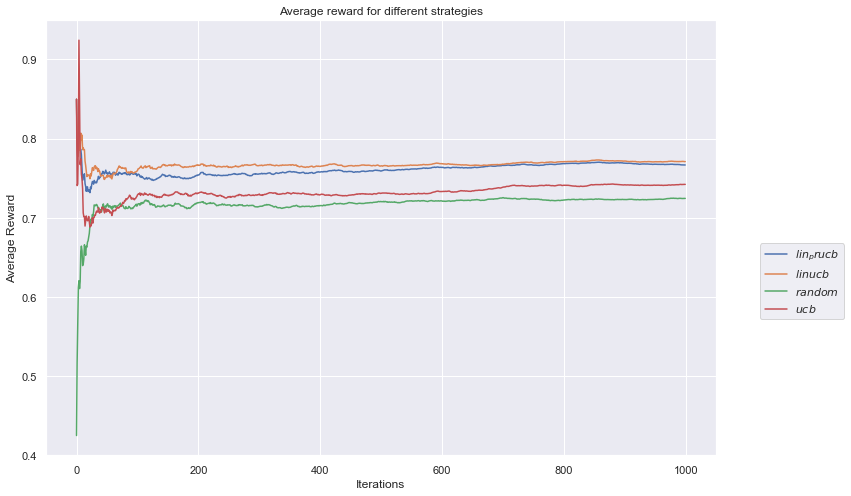

In [1015]:
plt.figure(figsize=(12,8))
plt.plot(exp_lin_prucb.mean_reward, label="$lin_prucb$")
plt.plot(exp_linucb.mean_reward, label="$linucb$")
plt.plot(exp_random.mean_reward, label="$random$")
plt.plot(exp_ucb.mean_reward, label="$ucb$")
plt.legend(bbox_to_anchor=(1.2, 0.5))
plt.xlabel("Iterations")
plt.ylabel("Average Reward")
plt.title("Average reward for different strategies");

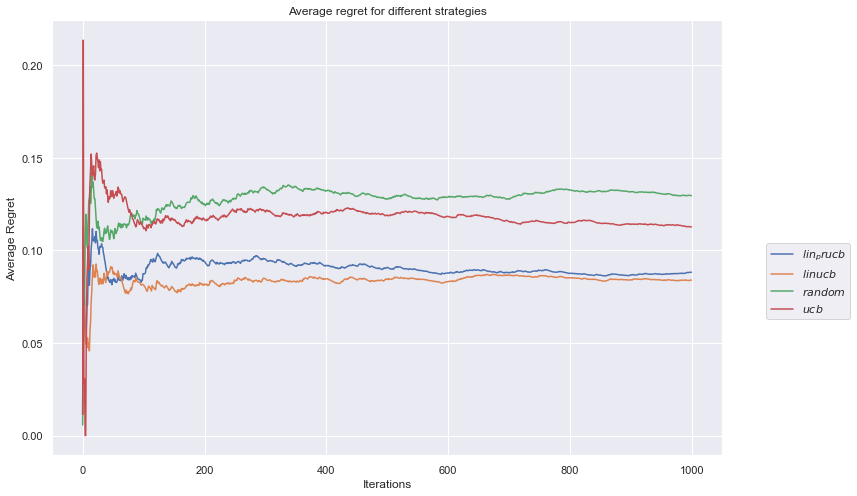

In [1016]:
plt.figure(figsize=(12,8))
plt.plot(exp_lin_prucb.mean_regret, label="$lin_prucb$")
plt.plot(exp_linucb.mean_regret, label="$linucb$")
plt.plot(exp_random.mean_regret, label="$random$")
plt.plot(exp_ucb.mean_regret, label="$ucb$")
plt.legend(bbox_to_anchor=(1.2, 0.5))
plt.xlabel("Iterations")
plt.ylabel("Average Regret")
plt.title("Average regret for different strategies");

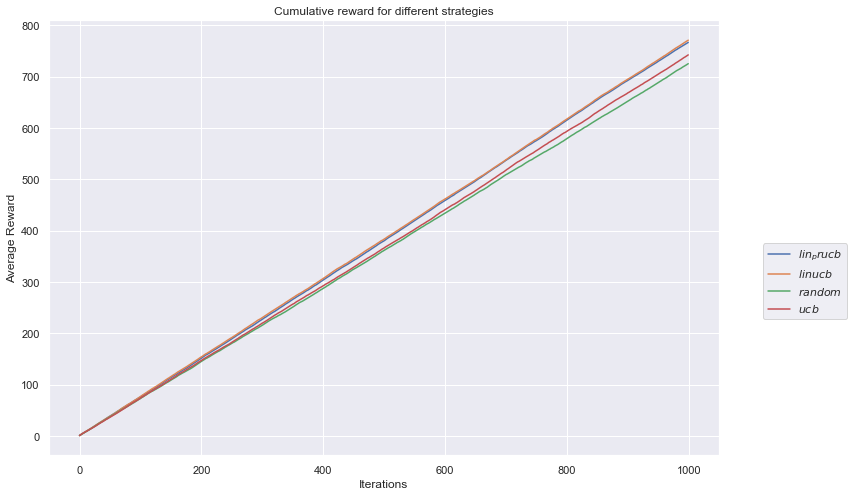

In [1017]:
plt.figure(figsize=(12,8))
plt.plot(np.cumsum(exp_lin_prucb.cumulative_reward), label="$lin_prucb$")
plt.plot(np.cumsum(exp_linucb.cumulative_reward), label="$linucb$")
plt.plot(np.cumsum(exp_random.cumulative_reward), label="$random$")
plt.plot(np.cumsum(exp_ucb.cumulative_reward), label="$ucb$")
plt.legend(bbox_to_anchor=(1.2, 0.5))
plt.xlabel("Iterations")
plt.ylabel("Average Reward")
plt.title("Cumulative reward for different strategies");

In [1038]:
spec = {'n_experiments': 10, 
        'env': ContextLinEnvironment,
        'env_param': {'n_action':5, 
                    'n_iter':10000},
        'alg': [{'type_': 'lin_ucb',  'alpha': 0.5}, 
                {'type_': 'lin_ucb', 'alpha': 0.2}, 
                {'type_': 'lin_prucb', 'alpha': 0.5, 'beta': 0.5, 'etha': 0.85},
                {'type_': 'lin_prucb', 'alpha': 0.6, 'beta': 0.6, 'etha': 0.85},
                {'type_': 'ucb1'},
                {'type_': 'random'}]}

In [1039]:
spec_results = run_spec(spec)

  0%|          | 0/10 [00:00<?, ?it/s]

{'n_action': 5, 'n_iter': 10000}


100%|██████████| 10/10 [02:45<00:00, 16.59s/it]


In [1032]:
spec_results

[{'mean_reward': array([0.85681347, 0.88763337, 0.80579776, ..., 0.8104262 , 0.81041926,
         0.81043278]),
  'mean_regret': array([0.        , 0.00239334, 0.05775764, ..., 0.06380016, 0.06380306,
         0.06379667]),
  'total_cnt': array([2705., 2583.,    8., 2111., 2593.]),
  'cumulative_reward': array([0.85681347, 0.91845327, 0.64212653, ..., 0.90126741, 0.74109564,
         0.94564717]),
  'actions_history': array([[100.,   0.,   0.,   0.,   0.],
         [  0., 100.,   0.,   0.,   0.],
         [  0.,   0., 100.,   0.,   0.],
         ...,
         [  0.,   0.,   0.,   0., 100.],
         [100.,   0.,   0.,   0.,   0.],
         [  0., 100.,   0.,   0.,   0.]])},
 {'mean_reward': array([0.85681347, 0.88763337, 0.80579776, ..., 0.77566506, 0.77565116,
         0.77566816]),
  'mean_regret': array([0.        , 0.00239334, 0.05775764, ..., 0.0985613 , 0.09857116,
         0.0985613 ]),
  'total_cnt': array([1537., 2960., 2517.,   20., 2966.]),
  'cumulative_reward': array([0.85

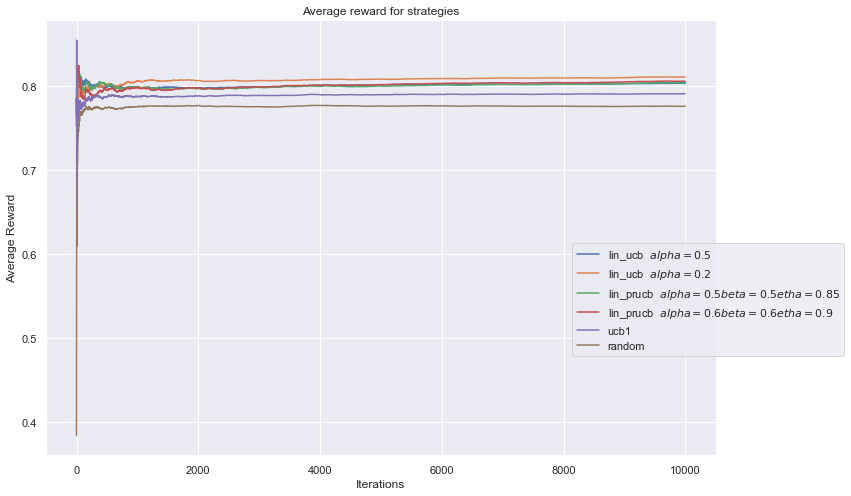

In [1046]:
plt.figure(figsize=(12,8))
plt.plot(spec_results[0]['mean_reward'], label="lin_ucb $\ alpha=0.5$")
plt.plot(spec_results[1]['mean_reward'], label="lin_ucb $\ alpha=0.2$")
plt.plot(spec_results[2]['mean_reward'], label="lin_prucb $\ alpha=0.5 beta=0.5 etha=0.85$")
plt.plot(spec_results[3]['mean_reward'], label="lin_prucb $\ alpha=0.6 beta=0.6 etha=0.9$")
plt.plot(spec_results[4]['mean_reward'], label="ucb1")
plt.plot(spec_results[5]['mean_reward'], label="random")

plt.legend(bbox_to_anchor=(1.2, 0.5))
plt.xlabel("Iterations")
plt.ylabel("Average Reward")
plt.title("Average reward for strategies");

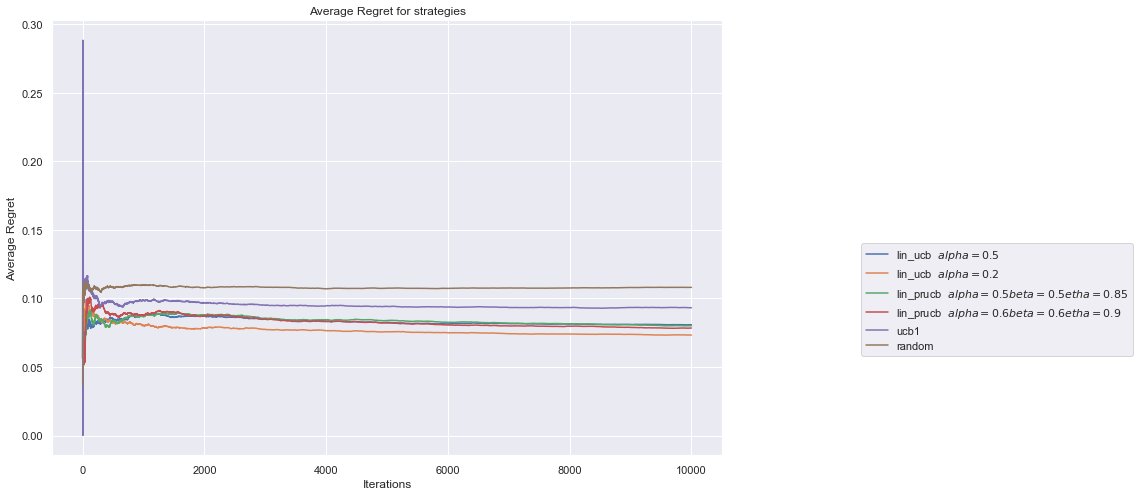

In [1045]:
plt.figure(figsize=(12,8))
plt.plot(spec_results[0]['mean_regret'], label="lin_ucb $\ alpha=0.5$")
plt.plot(spec_results[1]['mean_regret'], label="lin_ucb $\ alpha=0.2$")
plt.plot(spec_results[2]['mean_regret'], label="lin_prucb $\ alpha=0.5 beta=0.5 etha=0.85$")
plt.plot(spec_results[3]['mean_regret'], label="lin_prucb $\ alpha=0.6 beta=0.6 etha=0.9$")
plt.plot(spec_results[4]['mean_regret'], label="ucb1")
plt.plot(spec_results[5]['mean_regret'], label="random")

plt.legend(bbox_to_anchor=(1.2, 0.5))
plt.xlabel("Iterations")
plt.ylabel("Average Regret")
plt.title("Average Regret for strategies");

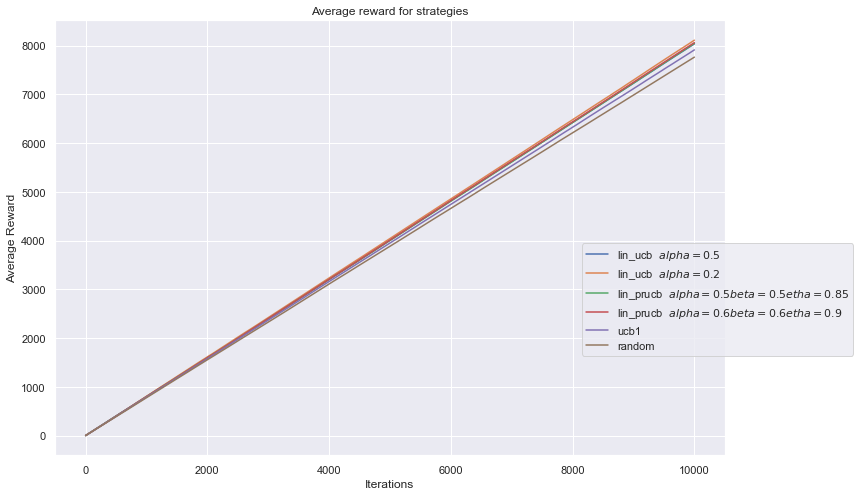

In [1047]:
plt.figure(figsize=(12,8))
plt.plot(np.cumsum(spec_results[0]['cumulative_reward']), label="lin_ucb $\ alpha=0.5$")
plt.plot(np.cumsum(spec_results[1]['cumulative_reward']), label="lin_ucb $\ alpha=0.2$")
plt.plot(np.cumsum(spec_results[2]['cumulative_reward']), label="lin_prucb $\ alpha=0.5 beta=0.5 etha=0.85$")
plt.plot(np.cumsum(spec_results[3]['cumulative_reward']), label="lin_prucb $\ alpha=0.6 beta=0.6 etha=0.9$")
plt.plot(np.cumsum(spec_results[4]['cumulative_reward']), label="ucb1")
plt.plot(np.cumsum(spec_results[5]['cumulative_reward']), label="random")

plt.legend(bbox_to_anchor=(1.2, 0.5))
plt.xlabel("Iterations")
plt.ylabel("Average Reward")
plt.title("Average reward for strategies");

In [1024]:
spec_results[0]['total_cnt'].shape

(5,)

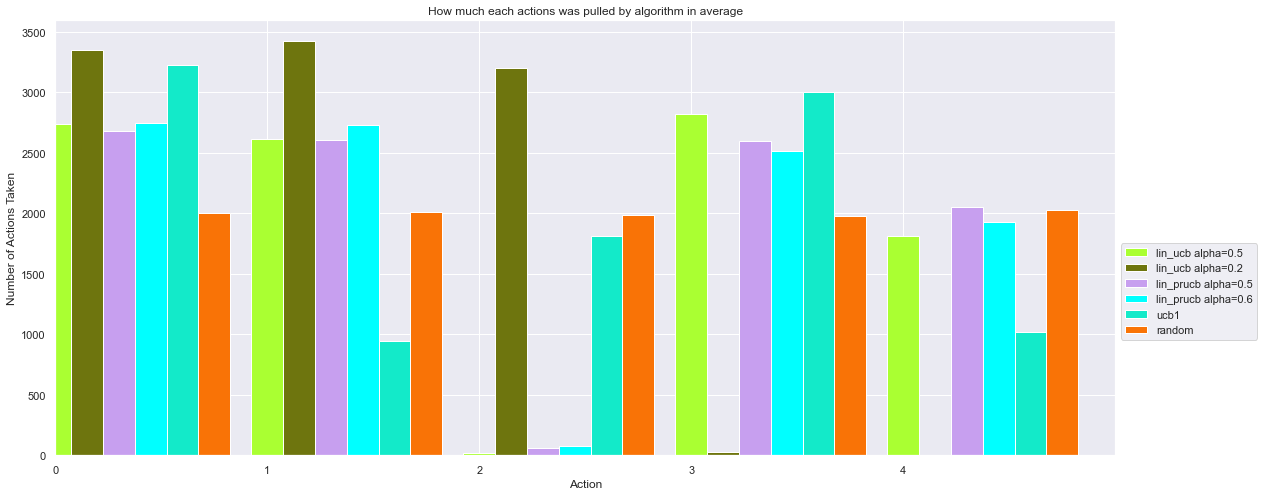

In [1043]:
bins = np.linspace(0, 5-1, 5, dtype=int)

plt.figure(figsize=(19,8))
plt.bar(bins, spec_results[0]['total_cnt'], 
        width = 0.15, color='xkcd:lime', 
        label="lin_ucb alpha=0.5")
plt.bar(bins+0.15, spec_results[1]['total_cnt'],
        width=0.15, color='xkcd:olive', 
        label="lin_ucb alpha=0.2")
plt.bar(bins+0.3, spec_results[2]['total_cnt'],
        width=0.15, color='xkcd:lavender', 
        label="lin_prucb alpha=0.5")
plt.bar(bins+0.45, spec_results[3]['total_cnt'],
        width=0.15, color='xkcd:cyan', 
        label="lin_prucb alpha=0.6")
plt.bar(bins+0.6, spec_results[4]['total_cnt'],
        width=0.15, color='xkcd:aqua', 
        label="ucb1")
plt.bar(bins+0.75, spec_results[5]['total_cnt'],
        width=0.15, color='xkcd:orange', 
        label="random")
plt.legend(bbox_to_anchor=(1., 0.5))
plt.xlim([0,5])
plt.xticks(bins)
plt.title("How much each actions was pulled by algorithm in average")
plt.xlabel("Action")
plt.ylabel("Number of Actions Taken");

In [1250]:
!ls

1507.08025.pdf
Tor_Lattimore,_Csaba_Szepesvári_Bandit_Algorithms_Cambridge_University.pdf
Untitled.ipynb
bandit-adversarial-notes.pdf
clear_days.xlsx
implementation
konon_diss.pdf
linear
temperature.xlsx
traffic_jams.xlsx
weather_condition.xlsx
wind_speed.xlsx
~$traffic_jams.xlsx
~$Презентация диплома.pptx
основные
связанное с картами
контекстные
Презентация диплома.pptx
традиционные меитоды рекомендаций
рекомендации последовательностей
томпсоновское семлирование
нестационарность
нестохастические


In [1266]:
pd.read_excel('traffic_jams.xlsx').apply(lambda x: x.replace(',', '.'))

,ЯНВ,ФЕВ,МАР,АПР,МАЙ,ИЮН,ИЮЛ,АВГ,СЕН,ОКТ,НОЯ,ДЕК
0,"4,6","4,7","4,9","5,2","5,1",5,"4,3","4,4","4,8",5,"5,2","5,6"


In [533]:
class RandomDataGenerator:

    fake = Faker()
    
    @classmethod
    def get_date(cls):
        return cls.fake.date_between(start_date='today', end_date='+1y')

    @classmethod        
    def get_weekday_and_month(cls):
        """
        Get random day of week and random month. 
        Return 1 for day of week if it is weekday or 0 for holidays.
        """
        FakeDate = namedtuple('FakeDate', ['weekday', 
                                  'month'])
        month = cls.fake.month()
        weekday = cls.fake.day_of_week()
        if weekday in ('Saturday', 'Sunday'):
            return FakeDate(0, int(month))
        else:
            return FakeDate(1, int(month))

In [1121]:
#http://www.pogodaiklimat.ru/climate/27612.htm
weather = pd.read_excel('weather_condition.xlsx')

In [1122]:
weather

,явление,янв,фев,мар,апр,май,июн,июл,авг,сен,окт,ноя,дек,год
0,дождь,8.0,6.0,9.00,15.00,16.00,16.00,15.0,16,16.0,17.00,13.00,8.0,155
1,снег,25.0,23.0,15.00,6.00,1.00,0.00,0.0,0,0.3,5.00,17.00,24.0,116
2,туман,0.2,0.4,0.30,1.00,0.20,0.30,1.0,1,1.0,1.00,1.00,1.0,8
3,мгла,0.0,0.2,0.10,0.10,0.03,0.03,0.3,1,1.0,0.10,0.03,0.0,3
4,гроза,0.2,0.1,0.30,1.00,3.00,7.00,7.0,4,1.0,0.30,0.10,0.0,24
5,метель,4.0,4.0,2.00,0.10,0.00,0.00,0.0,0,0.0,0.30,1.00,3.0,14
6,гололёд,1.0,1.0,0.40,0.03,0.00,0.00,0.0,0,0.0,0.20,1.00,2.0,6
7,изморозь,1.0,2.0,0.30,0.03,0.00,0.00,0.0,0,0.0,0.03,1.00,2.0,6
8,налипание м.с.,0.1,0.1,0.03,0.00,0.00,0.00,0.0,0,0.0,0.03,0.20,0.1,1


In [1123]:
weather = weather[weather['явление'] != 'налипание м.с.']

In [1124]:
weather

,явление,янв,фев,мар,апр,май,июн,июл,авг,сен,окт,ноя,дек,год
0,дождь,8.0,6.0,9.0,15.00,16.00,16.00,15.0,16,16.0,17.00,13.00,8.0,155
1,снег,25.0,23.0,15.0,6.00,1.00,0.00,0.0,0,0.3,5.00,17.00,24.0,116
2,туман,0.2,0.4,0.3,1.00,0.20,0.30,1.0,1,1.0,1.00,1.00,1.0,8
3,мгла,0.0,0.2,0.1,0.10,0.03,0.03,0.3,1,1.0,0.10,0.03,0.0,3
4,гроза,0.2,0.1,0.3,1.00,3.00,7.00,7.0,4,1.0,0.30,0.10,0.0,24
5,метель,4.0,4.0,2.0,0.10,0.00,0.00,0.0,0,0.0,0.30,1.00,3.0,14
6,гололёд,1.0,1.0,0.4,0.03,0.00,0.00,0.0,0,0.0,0.20,1.00,2.0,6
7,изморозь,1.0,2.0,0.3,0.03,0.00,0.00,0.0,0,0.0,0.03,1.00,2.0,6


In [1125]:
#https://www.betaenergy.ru/windspeed/moskva/
#https://34.mchs.gov.ru/deyatelnost/press-centr/aktualno/klassifikaciya-sily-i-skorosti-vetra-informaciya-dlya-predstaviteley-smi
wind = pd.read_excel('wind_speed.xlsx')

In [1126]:
wind

,month,speed
0,Январь,"3,19"
1,Февраль,"3,10"
2,Март,"3,12"
3,Апрель,"3,03"
4,Май,"2,98"
5,Июнь,"2,73"
6,Июль,"2,80"
7,Август,"2,96"
8,Сентябрь,"3,15"
9,Октябрь,"3,13"


In [1127]:
#http://www.pogodaiklimat.ru/climate/27612.htm
clear_days = pd.read_excel('clear_days.xlsx')

In [1128]:
clear_days

,месяц,янв,фев,мар,апр,май,июн,июл,авг,сен,окт,ноя,дек
0,ясных,1,2,4,3,4,2,2,3,2,2,1,1
1,облачных,8,9,13,15,19,20,21,19,16,11,7,7


In [1129]:
temperature = pd.read_excel('temperature.xlsx')

In [1130]:
temperature

,Месяц,Средний минимум,Средняя,Средний максимум
0,январь,-9.1,-6.5,-4.0
1,февраль,-9.8,-6.7,-3.7
2,март,-4.4,-1.0,2.6
3,апрель,2.2,6.7,11.3
4,май,7.7,13.2,18.6
5,июнь,12.1,17.0,22.0
6,июль,14.4,19.2,24.3
7,август,12.5,17.0,21.9
8,сентябрь,7.4,11.3,15.7
9,октябрь,2.7,5.6,8.7


In [1131]:
jams = pd.read_excel('traffic_jams.xlsx')

In [1132]:
jams.loc[:, jams.select_dtypes(include='object').columns] = jams.select_dtypes(include='object').applymap(lambda x: x.replace(',', '.'))

In [1133]:
jams = jams.astype(float)

In [1134]:
clear_days.loc[:, clear_days.select_dtypes(include='int64').columns] = clear_days.select_dtypes(include='int64') / 30

In [1135]:
weather.loc[:, weather.select_dtypes(include='number').columns] = weather.select_dtypes(include='number') / 30

/Users/sinvic/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, val, pi)


In [1136]:
month_mapper = {'январь': 'янв',
               'февраль': 'фев',
               'март': 'мар',
               'апрель': 'апр',
               'май': 'май',
               'июнь': 'июн',
               'июль': 'июл',
               'август': 'авг',
               'сентябрь': 'сен',
               'октябрь': 'окт',
               'ноябрь': 'ноя',
               'декабрь': 'дек'}

In [1137]:
temperature['Месяц'] = temperature['Месяц'].str.lower()

In [1138]:
temperature['Месяц'] = temperature['Месяц'].map(month_mapper)

In [1139]:
wind['month'] = wind['month'].str.lower()
wind['month'] = wind['month'].map(month_mapper)

In [1140]:
float(wind[wind.month == 'янв']['speed'].str.replace(',', '.').values[0])

3.19

In [1141]:
month_no_to_str = {1: 'янв',
                  2: 'фев',
                  3: 'мар',
                  4: 'апр',
                  5: 'май',
                  6: 'июн',
                  7: 'июл',
                  8: 'авг',
                  9: 'сен',
                  10: 'окт',
                  11: 'ноя',
                  12: 'дек'}

In [1142]:
weather

,явление,янв,фев,мар,апр,май,июн,июл,авг,сен,окт,ноя,дек,год
0,дождь,0.266667,0.200000,0.300000,0.500000,0.533333,0.533333,0.500000,0.533333,0.533333,0.566667,0.433333,0.266667,5.166667
1,снег,0.833333,0.766667,0.500000,0.200000,0.033333,0.000000,0.000000,0.000000,0.010000,0.166667,0.566667,0.800000,3.866667
2,туман,0.006667,0.013333,0.010000,0.033333,0.006667,0.010000,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.266667
3,мгла,0.000000,0.006667,0.003333,0.003333,0.001000,0.001000,0.010000,0.033333,0.033333,0.003333,0.001000,0.000000,0.100000
4,гроза,0.006667,0.003333,0.010000,0.033333,0.100000,0.233333,0.233333,0.133333,0.033333,0.010000,0.003333,0.000000,0.800000
5,метель,0.133333,0.133333,0.066667,0.003333,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000,0.033333,0.100000,0.466667
6,гололёд,0.033333,0.033333,0.013333,0.001000,0.000000,0.000000,0.000000,0.000000,0.000000,0.006667,0.033333,0.066667,0.200000
7,изморозь,0.033333,0.066667,0.010000,0.001000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001000,0.033333,0.066667,0.200000


In [1143]:
wind

,month,speed
0,янв,"3,19"
1,фев,"3,10"
2,мар,"3,12"
3,апр,"3,03"
4,май,"2,98"
5,июн,"2,73"
6,июл,"2,80"
7,авг,"2,96"
8,сен,"3,15"
9,окт,"3,13"


In [1144]:
jams

,ЯНВ,ФЕВ,МАР,АПР,МАЙ,ИЮН,ИЮЛ,АВГ,СЕН,ОКТ,НОЯ,ДЕК
0,4.6,4.7,4.9,5.2,5.1,5.0,4.3,4.4,4.8,5.0,5.2,5.6


ветер - нормальное распределение с модой и дисперсией 1
температура - нормальное распределение с модой и дисперсией 3
ясный/солнечный/обычный день
дождь далее биномиальное распределение с указанными вероятностями
снег
туман
мгла
гроза
метель
гололёд
изморозь
налипание

In [1436]:
class RandomConditionGenerator:
    
    def __init__(self, month_mapping, date_generator, weather, wind, temperature, clear_days, jams):
        self.month_mapping = month_mapping
        self.date_generator = date_generator
        self.weather = weather
        self.wind = wind
        self.temperature = temperature
        self.clear_days = clear_days
        self.jams = jams
        
    def get_env_context(self):
        """
        return: dict
        """
        result = self.date_generator.get_weekday_and_month()     
        mo = month_no_to_str[result.month]
        weather = self.get_weather(mo)
        jam = self.get_traffic_jams(mo, result.weekday)
        return dict(балл_пробок=round(jam), **weather[0])
             
    def get_weather(self, mo):
        """
        mo: type str
        """
        weather_cond = self.get_random_weather_condition(mo)
        wind = self.get_wind(mo)
        clear_day = self.get_clear_days(mo)
        temp = self.get_temperature(mo)
        return dict(weather_cond, **{'ветер': round(wind, 2), 'облачный день':clear_day, 'температура': np.round(temp, 2)}), mo
        
    def get_random_weather_condition(self, mo):
        env = {}
        weather_conditions = self.weather[['явление', mo]].values
        for key, item in weather_conditions:
            env[key] = sp.bernoulli.rvs(item)
        return env
    
    def get_wind(self, mo, sigma=7):
        env = {}
        wind_mu = float(self.wind[self.wind.month == mo]['speed'].str.replace(',', '.').values[0])
        return np.clip(sp.norm.rvs(wind_mu, sigma), 0, 40)
    
    def get_clear_days(self, mo):
        """
        -1-ясный
        0-обычный
        1-облачный
        """
        days = self.clear_days[['месяц', mo]]
        days['proba'] = sp.bernoulli.rvs(days[mo])
        if days[days['месяц'] == 'ясных']['proba'].values == 1 and days[days['месяц'] == "облачных"]['proba'].values == 1:
            return 0
        if days[days['месяц'] == 'ясных']['proba'].values == 1:
            return -1
        return 1
    
    def get_temperature(self, mo, sigma=10):
        temp = self.temperature[self.temperature['Месяц'] == mo]
        return np.clip(sp.norm.rvs(temp['Средняя'].values[0], sigma), 
                    temp['Средний минимум'].values[0] - 10,  
                    temp['Средний максимум'].values[0] + 10)
    
    def get_traffic_jams(self, mo, weekday):
        # http://пробки-онлайн.рф/исследования/пробки-в-москве
        # https://yandex.ru/company/researches/2017/moscow_traffic_2017
        month = self.jams[mo.upper()].values[0]
        lower, upper = 0, 10
        if weekday:        
            mu, sigma = 7.5, 4
            day_jam = sp.truncnorm(
                (lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma)
        else:
            mu, sigma = 4, 3
            day_jam = sp.truncnorm(
                (lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma)
        return 0.5 * month + day_jam.rvs(1)[0] * 0.5

In [1177]:
env = RandomConditionGenerator(month_no_to_str, date_generator=RandomDataGenerator(), jams=jams,weather=weather, clear_days=clear_days, wind=wind, temperature=temperature)

In [1184]:
env.get_env_context()

<ipython-input-1176-41ddc4d2be44>:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  days['proba'] = sp.bernoulli.rvs(days[mo])


{'балл_пробок': 4,
 'дождь': 0,
 'снег': 0,
 'туман': 0,
 'мгла': 1,
 'гроза': 0,
 'метель': 0,
 'гололёд': 0,
 'изморозь': 0,
 'ветер': 9.01,
 'облачный день': 1,
 'температура': -0.04}

In [1408]:
class RandomUserGenerator:
    
    @classmethod
    def generate_user(cls):
        user = namedtuple('User', 'sex, age, has_vehicle, income, has_spouse')
        is_male = sp.bernoulli.rvs(0.5)
        age = np.random.choice(['16-25', '25-33','33-45', '45-60', '60-80'], size=1, p=[0.2, 0.2, 0.3, 0.2, 0.1])[0]
        if is_male:
            has_spouse = sp.bernoulli.rvs(0.584)
        else:
            has_spouse = sp.bernoulli.rvs(0.465)
        if age in ['16-25', '25-33']:
            income = np.random.choice(['powerty', 'low-middle', 'middle', 'high-middle', 'rich'], size=1, p=[0.17, 0.3, 0.3, 0.2, 0.03])[0]
        elif age in ['33-45', '45-60']:
            income = np.random.choice(['powerty', 'low-middle', 'middle', 'high-middle', 'rich'], size=1, p=[0.04, 0.2, 0.4, 0.3, 0.06])[0]
        else:
            income = np.random.choice(['powerty', 'low-middle', 'middle', 'high-middle', 'rich'], size=1, p=[0.3, 0.4, 0.2, 0.05, 0.05])[0]
        if income == 'powerty':
            has_vehicle = sp.bernoulli.rvs(0.05)
        elif income == 'low-middle':
            has_vehicle = sp.bernoulli.rvs(0.3)
        elif income == 'middle':
            has_vehicle = sp.bernoulli.rvs(0.7)
        elif income == 'high-middle':
            has_vehicle = sp.bernoulli.rvs(0.85)
        elif income == 'rich':
            has_vehicle = sp.bernoulli.rvs(0.99)
        return user(is_male, age, has_vehicle, income, has_vehicle)

In [1048]:
RandomUserGenerator.generate_user()

User(sex=0, age='25-33', has_vehicle=0, income='low-middle', has_spouse=0)

Характеристики типов маршрута:

- количество колес (0, 2, 4)
- необходимость пересечения с другими людьми (от 0 совсем не пересекаешься до 5 сильное пересечение)
- доступность разных видов проезжей части (0 - только тратуары, 2 - только проезжая часть)
- средняя скорость передвижения (от 3 до 80) ср.ск. пешеходов 5 велосепедиста 25-30  такси 38-40 авто 80
- вместимости (0 - только сам пользователь, 1 - можно взять 1 человека, 2 - можно взять двух и более)

In [1409]:
social_interaction_domain = Domain("social_interaction_domain", 0, 5, res=0.5)
social_interaction_domain.low = S(.5, 2.)
social_interaction_domain.medium = trapezoid(0.5, 2., 3., 4.5, c_m=1)
social_interaction_domain.high = R(3, 4.5)

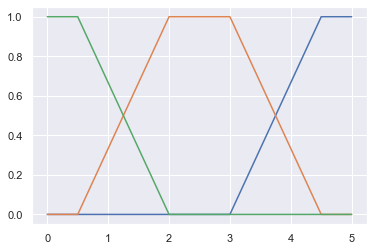

In [360]:
social_interaction_domain.high.plot()
social_interaction_domain.medium.plot()
social_interaction_domain.low.plot()

In [1410]:
speed_domain = Domain("speed", 3, 100, res=0.5)
speed_domain.low = S(3, 20)
speed_domain.medium = trapezoid(10, 25, 35, 50)
speed_domain.high_medium = trapezoid(40, 60, 70, 80)
speed_domain.high = R(70, 100)

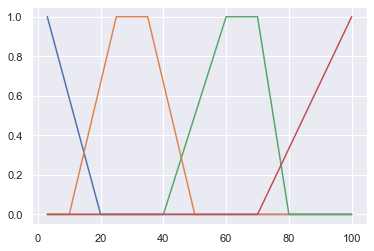

In [362]:
speed_domain.low.plot()
speed_domain.medium.plot()
speed_domain.high_medium.plot()
speed_domain.high.plot()

In [1411]:
price_domain = Domain("price_domain", 0, 10, res=0.5)
price_domain.free = S(1, 2)
price_domain.low = trapezoid(1, 3, 5, 6.5)
price_domain.medium = trapezoid(5, 6, 8, 9)
price_domain.high = R(7.5, 10)

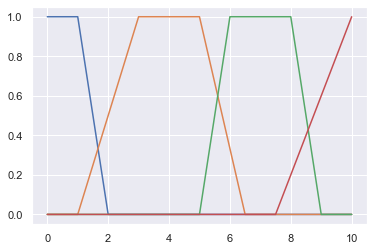

In [406]:
price_domain.free.plot()
price_domain.low.plot()
price_domain.medium.plot()
price_domain.high.plot()

In [1412]:
class RouteTypeRandomGenerator:
    
    @classmethod
    def generate_route_type_characteristic(cls):
        price_domain = np.random.choice([1.5, 2, 2.5, 3, 3.5], size=1, p=[0.1, 0.2, 0.3, 0.3, 0.1])[0]
        speed_domain  = round(sp.truncnorm(
                (40 - 65) / 15, (100 - 65) / 15, loc=65, scale=15).rvs(1)[0])
        social_interaction_domain = np.random.choice([1, 2, 3, 4], size=1, p=[0.3, 0.4, 0.2, 0.1])[0]
        
        return {'wheel': wheel, 
                'social_interaction_domain': social_interaction_domain, 
                'avaliability_of_road_types_domain': avaliability_of_road_types_domain,
               'speed_domain': speed_domain,
               'capacity_domain': capacity_domain,
               'price_domain': price_domain}

In [315]:
RouteTypeRandomGenerator.generate_route_type_characteristic()

{'wheel': 4,
 'social_interaction_domain': 4,
 'avaliability_of_road_types_domain': 2,
 'speed_domain': 68,
 'capacity_domain': 1,
 'price_domain': 2.0}

In [1413]:
user = namedtuple('User', 'sex, age, has_vehicle, income, has_spouse')

In [1527]:
users_map = {}


# преимущественно студенты либо люди в начале карьеры. Предпочитают быстроту при этом более дешевые варианты. Нормально относятся к соц взаимодействиям в пути. Выбор ОТ байк пешка
young_and_poor_f = user(0, '16-25', 0, 'powerty', 0)
young_and_poor_m = user(1, '16-25', 0, 'powerty', 0)
users_map[(young_and_poor_f, young_and_poor_m)] = {'ot': {'loc': 0.65, 'scale': 0.1},
                                                  'car': {'loc': 0.1, 'scale': 0.1},
                                                  'bike': {'loc': 0.1, 'scale': 0.1},
                                                  'pdstr': {'loc': 0.65, 'scale': 0.1},
                                                  'taxi': {'loc': 0.05, 'scale': 0.1}}


young_and_poor_vehicle_f = user(0, '16-25', 1, 'powerty', 0)
young_and_poor_vehicle_m = user(1, '16-25', 1, 'powerty', 0)
young_and_poor_vehicle_spouse_f = user(0, '16-25', 1, 'powerty', 1)
young_and_poor_vehicle_spouse_m = user(1, '16-25', 1, 'powerty', 1)
users_map[(young_and_poor_vehicle_f, 
           young_and_poor_vehicle_m,
          young_and_poor_vehicle_spouse_f,
          young_and_poor_vehicle_spouse_m)] = {'ot': {'loc': 0.25, 'scale': 0.1},
                                                  'car': {'loc': 0.75, 'scale': 0.1},
                                                  'bike': {'loc': 0.1, 'scale': 0.1},
                                                  'pdstr': {'loc': 0.5, 'scale': 0.1},
                                                  'taxi': {'loc': 0.05, 'scale': 0.1}}


#особенность предпочитают пешку от байк такси  уже не в крайних случаях
young_and_poor_low_middle_f = user(0, '16-25', 0, 'low-middle', 0)
young_and_poor_low_middle_m = user(1, '16-25', 0, 'low-middle', 0)
young_and_poor_low_middle_spouse_f = user(0, '16-25', 0, 'low-middle', 1)
young_and_poor_low_middle_spouse_m = user(1, '16-25', 0, 'low-middle', 1)
users_map[(young_and_poor_low_middle_f, 
           young_and_poor_low_middle_m, 
           young_and_poor_low_middle_spouse_f, 
           young_and_poor_low_middle_spouse_m)] = {'ot': {'loc': 0.70, 'scale': 0.1},
                                                    'car': {'loc': 0.2, 'scale': 0.1},
                                                    'bike': {'loc': 0.1, 'scale': 0.1},
                                                    'pdstr': {'loc': 0.6, 'scale': 0.1},
                                                    'taxi': {'loc': 0.15, 'scale': 0.1}}


young_and_poor_middle_f = user(0, '16-25', 1, 'middle', 0)
young_and_poor_middle_m = user(1, '16-25', 1, 'middle', 0)
young_and_poor_middle_spouse_f = user(0, '16-25', 1, 'middle', 1)
young_and_poor_middle_spouse_m = user(1, '16-25', 1, 'middle', 1)
users_map[(young_and_poor_middle_f, 
           young_and_poor_middle_m, 
           young_and_poor_middle_spouse_f, 
           young_and_poor_middle_spouse_m)] = {'ot': {'loc': 0.35, 'scale': 0.1},
                                                    'car': {'loc': 0.85, 'scale': 0.1},
                                                    'bike': {'loc': 0.1, 'scale': 0.1},
                                                    'pdstr': {'loc': 0.4, 'scale': 0.1},
                                                    'taxi': {'loc': 0.2, 'scale': 0.1}}


young_and_poor_middle_no_vehicle_f = user(0, '16-25', 0, 'middle', 0)
young_and_poor_middle_no_vehicle_m = user(1, '16-25', 0, 'middle', 0)
young_and_poor_middle_no_vehicle_spouse_f = user(0, '16-25', 0, 'middle', 1)
young_and_poor_middle_no_vehicle_spouse_m = user(1, '16-25', 0, 'middle', 1)
users_map[(young_and_poor_middle_no_vehicle_f, 
           young_and_poor_middle_no_vehicle_m, 
           young_and_poor_middle_no_vehicle_spouse_f, 
           young_and_poor_middle_no_vehicle_spouse_m)] = {'ot': {'loc': 0.65, 'scale': 0.1},
                                                    'car': {'loc': 0.1, 'scale': 0.1},
                                                    'bike': {'loc': 0.1, 'scale': 0.1},
                                                    'pdstr': {'loc': 0.5, 'scale': 0.1},
                                                    'taxi': {'loc': 0.25, 'scale': 0.1}}

young_and_poor_high_middle_f = user(0, '16-25', 1, 'high-middle', 0)
young_and_poor_high_middle_m = user(1, '16-25', 1, 'high-middle', 0)
young_and_poor_high_middle_spouse_f = user(0, '16-25', 1, 'high-middle', 1)
young_and_poor_high_middle_spouse_m = user(1, '16-25', 1, 'high-middle', 1)
users_map[(young_and_poor_high_middle_f, 
           young_and_poor_high_middle_m, 
           young_and_poor_high_middle_spouse_f, 
           young_and_poor_high_middle_spouse_m)] = {'ot': {'loc': 0.35, 'scale': 0.1},
                                                    'car': {'loc': 0.9, 'scale': 0.1},
                                                    'bike': {'loc': 0.1, 'scale': 0.1},
                                                    'pdstr': {'loc': 0.35, 'scale': 0.1},
                                                    'taxi': {'loc': 0.25, 'scale': 0.1}}


young_and_poor_high_middle_no_vehicle_f = user(0, '16-25', 0, 'high-middle', 0)
young_and_poor_high_middle_no_vehicle_m = user(1, '16-25', 0, 'high-middle', 0)
young_and_poor_high_middle_spouse_no_vehicle_f = user(0, '16-25', 0, 'high-middle', 1)
young_and_poor_high_middle_spouse_no_vehicle_m = user(1, '16-25', 0, 'high-middle', 1)
users_map[(young_and_poor_high_middle_no_vehicle_f, 
           young_and_poor_high_middle_no_vehicle_m, 
           young_and_poor_high_middle_spouse_no_vehicle_f, 
           young_and_poor_high_middle_spouse_no_vehicle_m)] = {'ot': {'loc': 0.7, 'scale': 0.1},
                                                    'car': {'loc': 0.1, 'scale': 0.1},
                                                    'bike': {'loc': 0.1, 'scale': 0.1},
                                                    'pdstr': {'loc': 0.5, 'scale': 0.1},
                                                    'taxi': {'loc': 0.45, 'scale': 0.1}}

young_and_poor_rich_f = user(0, '16-25', 1, 'rich', 0)
young_and_poor_rich_m = user(1, '16-25', 1, 'rich', 0)
young_and_poor_rich_spouse_f = user(0, '16-25', 1, 'rich', 1)
young_and_poor_rich_spouse_m = user(1, '16-25', 1, 'rich', 1)
users_map[(young_and_poor_rich_f, 
           young_and_poor_rich_m, 
           young_and_poor_rich_spouse_f, 
           young_and_poor_rich_spouse_m)] = {'ot': {'loc': 0.15, 'scale': 0.1},
                                                    'car': {'loc': 0.9, 'scale': 0.1},
                                                    'bike': {'loc': 0.1, 'scale': 0.1},
                                                    'pdstr': {'loc': 0.25, 'scale': 0.1},
                                                    'taxi': {'loc': 0.45, 'scale': 0.1}}

young_and_poor_rich_no_vehicle_f = user(0, '16-25', 0, 'rich', 0)
young_and_poor_rich_no_vehicle_m = user(1, '16-25', 0, 'rich', 0)
young_and_poor_rich_no_vehicle_spouse_f = user(0, '16-25', 0, 'rich', 1)
young_and_poor_rich_no_vehicle_spouse_m = user(1, '16-25', 0, 'rich', 1)
users_map[(young_and_poor_rich_no_vehicle_f, 
           young_and_poor_rich_no_vehicle_m, 
           young_and_poor_rich_no_vehicle_spouse_f, 
           young_and_poor_rich_no_vehicle_spouse_m)] = {'ot': {'loc': 0.25, 'scale': 0.1},
                                                    'car': {'loc': 0.2, 'scale': 0.1},
                                                    'bike': {'loc': 0.1, 'scale': 0.1},
                                                    'pdstr': {'loc': 0.35, 'scale': 0.1},
                                                    'taxi': {'loc': 0.65, 'scale': 0.1}}


# получили образование и теперь работают,строят карьеру. Предпочитают скорость и удобсвто. У многих уже есть свое авто
career_activist_f = user(0, '25-33', 0, 'low-middle', 0)
career_activist_m = user(1, '25-33', 0, 'low-middle', 0)
career_activist_middle_f = user(0, '25-33', 0, 'middle', 0)
career_activist_middle_m = user(1, '25-33', 0, 'middle', 0)
career_activist_f_spouse = user(0, '25-33', 0, 'low-middle', 1)
career_activist_m_spouse = user(1, '25-33', 0, 'low-middle', 1)
career_activist_middle_f_spouse = user(0, '25-33', 0, 'middle', 1)
career_activist_middle_m_spouse = user(1, '25-33', 0, 'middle', 1)

#особенность предпочитают быстроту. Могу чаще позволить себе такси
users_map[(career_activist_f, 
           career_activist_m, 
           career_activist_middle_f, 
           career_activist_middle_m,
          career_activist_f_spouse,
          career_activist_m_spouse,
          career_activist_middle_f_spouse,
          career_activist_middle_m_spouse)] = {'ot': {'loc': 0.75, 'scale': 0.1},
                                                    'car': {'loc': 0.2, 'scale': 0.1},
                                                    'bike': {'loc': 0.2, 'scale': 0.1},
                                                    'pdstr': {'loc': 0.65, 'scale': 0.1},
                                                    'taxi': {'loc': 0.2, 'scale': 0.1}}




#особенность предпочитают быстроту. Имеют машину.  Практически всегда будут ей пользоваться. От будут пользоваться только в случае, если не надо будет сильно пересекаться с людьми
career_activist_high_middle_viehicle_f = user(0, '25-33', 1, 'high-middle', 0)
career_activist_high_middle_viehicle_m = user(1, '25-33', 1, 'high-middle', 0)
career_activist_high_middle_viehicle_f_spouse = user(0, '25-33', 1, 'high-middle', 1)
career_activist_high_middle_viehicle_m_spouse = user(1, '25-33', 1, 'high-middle', 1)
users_map[(career_activist_high_middle_viehicle_f, 
           career_activist_high_middle_viehicle_m, 
           career_activist_high_middle_viehicle_f_spouse, 
           career_activist_high_middle_viehicle_m_spouse)] = {'ot': {'loc': 0.15, 'scale': 0.1},
                                                    'car': {'loc': 0.9, 'scale': 0.1},
                                                    'bike': {'loc': 0.1, 'scale': 0.1},
                                                    'pdstr': {'loc': 0.5, 'scale': 0.1},
                                                    'taxi': {'loc': 0.35, 'scale': 0.1}}


career_activist_powerty_f = user(0, '25-33', 0, 'powerty', 0)
career_activist_powerty_m = user(1, '25-33', 0, 'powerty', 0)
career_activist_powerty_f_spouse = user(0, '25-33', 0, 'powerty', 1)
career_activist_powerty_m_spouse = user(1, '25-33', 0, 'powerty', 1)
users_map[(career_activist_powerty_f, 
           career_activist_powerty_m, 
           career_activist_powerty_f_spouse, 
           career_activist_powerty_m_spouse)] = {'ot': {'loc': 0.65, 'scale': 0.1},
                                                    'car': {'loc': 0.1, 'scale': 0.1},
                                                    'bike': {'loc': 0.1, 'scale': 0.1},
                                                    'pdstr': {'loc': 0.6, 'scale': 0.1},
                                                    'taxi': {'loc': 0.08, 'scale': 0.1}}

career_activist_powerty_vehicle_f = user(0, '25-33', 1, 'powerty', 0)
career_activist_powerty_vehicle_m = user(1, '25-33', 1, 'powerty', 0)
career_activist_powerty_vehicle_f_spouse = user(0, '25-33', 1, 'powerty', 1)
career_activist_powerty_vehicle_m_spouse = user(1, '25-33', 1, 'powerty', 1)
users_map[(career_activist_powerty_vehicle_f, 
           career_activist_powerty_vehicle_m, 
           career_activist_powerty_vehicle_f_spouse, 
           career_activist_powerty_vehicle_m_spouse)] = {'ot': {'loc': 0.25, 'scale': 0.1},
                                                    'car': {'loc': 0.8, 'scale': 0.1},
                                                    'bike': {'loc': 0.1, 'scale': 0.1},
                                                    'pdstr': {'loc': 0.5, 'scale': 0.1},
                                                    'taxi': {'loc': 0.1, 'scale': 0.1}}


career_activist_middle_viehicle_f = user(0, '25-33', 1, 'middle', 0)
career_activist_middle_viehicle_m = user(1, '25-33', 1, 'middle', 0)
career_activist_middle_viehicle_f_spouse = user(0, '25-33', 1, 'middle', 1)
career_activist_middle_viehicle_m_spouse = user(1, '25-33', 1, 'middle', 1)
users_map[(career_activist_middle_viehicle_f, 
           career_activist_middle_viehicle_m, 
           career_activist_middle_viehicle_f_spouse, 
           career_activist_middle_viehicle_m_spouse)] = {'ot': {'loc': 0.5, 'scale': 0.1},
                                                    'car': {'loc': 0.9, 'scale': 0.1},
                                                    'bike': {'loc': 0.1, 'scale': 0.1},
                                                    'pdstr': {'loc': 0.4, 'scale': 0.1},
                                                    'taxi': {'loc': 0.3, 'scale': 0.1}}


career_activist_high_middle_no_viehicle_f = user(0, '25-33', 0, 'high-middle', 0)
career_activist_high_middle_no_viehicle_m = user(1, '25-33', 0, 'high-middle', 0)
career_activist_high_middle_no_viehicle_f_spouse = user(0, '25-33', 0, 'high-middle', 1)
career_activist_high_middle_no_viehicle_m_spouse = user(1, '25-33', 0, 'high-middle', 1)
users_map[(career_activist_high_middle_no_viehicle_f, 
           career_activist_high_middle_no_viehicle_m, 
           career_activist_high_middle_no_viehicle_f_spouse, 
           career_activist_high_middle_no_viehicle_m_spouse)] = {'ot': {'loc': 0.75, 'scale': 0.1},
                                                    'car': {'loc': 0.1, 'scale': 0.1},
                                                    'bike': {'loc': 0.1, 'scale': 0.1},
                                                    'pdstr': {'loc': 0.4, 'scale': 0.1},
                                                    'taxi': {'loc': 0.35, 'scale': 0.1}}



career_activist_low_middle_viehicle_f = user(0, '25-33', 1, 'low-middle', 0)
career_activist_low_middle_viehicle_m = user(1, '25-33', 1, 'low-middle', 0)
career_activist_low_middle_viehicle_f_spouse = user(0, '25-33', 1, 'low-middle', 1)
career_activist_low_middle_viehicle_m_spouse = user(1, '25-33', 1, 'low-middle', 1)
users_map[(career_activist_low_middle_viehicle_f, 
           career_activist_low_middle_viehicle_m, 
           career_activist_low_middle_viehicle_f_spouse, 
           career_activist_low_middle_viehicle_m_spouse)] = {'ot': {'loc': 0.25, 'scale': 0.1},
                                                    'car': {'loc': 0.85, 'scale': 0.1},
                                                    'bike': {'loc': 0.1, 'scale': 0.1},
                                                    'pdstr': {'loc': 0.4, 'scale': 0.1},
                                                    'taxi': {'loc': 0.2, 'scale': 0.1}}

# Взсрослая группа уже состоявшихся людей. Построили карьеру имеют семью и машину. Преимущественно средний класс. Предпочитают кофморт и скорость. Cкорее воспользуются своей машиной
business_peopl_f = user(0, '33-45', 0, 'middle', 1)
business_peopl_m = user(1, '33-45', 0, 'middle', 1)
business_peopl_no_spouse_f = user(0, '33-45', 0, 'middle', 0)
business_peopl_no_spouse_m = user(1, '33-45', 0, 'middle', 0)
users_map[(business_peopl_f, 
           business_peopl_m, 
           business_peopl_no_spouse_f, 
           business_peopl_no_spouse_m)] = {'ot': {'loc': 0.8, 'scale': 0.1},
                                                    'car': {'loc': 0.1, 'scale': 0.1},
                                                    'bike': {'loc': 0.1, 'scale': 0.1},
                                                    'pdstr': {'loc': 0.45, 'scale': 0.1},
                                                    'taxi': {'loc': 0.35, 'scale': 0.1}}


business_peopl_vihicle_f = user(0, '33-45', 1, 'middle', 1)
business_peopl_vihicle_m = user(1, '33-45', 1, 'middle', 1)
business_peopl_vihicle_highmiddle_f = user(0, '33-45', 1, 'high-middle', 1)
business_peopl_vihicle_highmiddle_m = user(1, '33-45', 1, 'high-middle', 1)
business_peopl_vihicle_no_spouse_f = user(0, '33-45', 1, 'middle', 0)
business_peopl_vihicle_no_spouse_m = user(1, '33-45', 1, 'middle', 0)
business_peopl_vihicle_highmiddle_no_spouse_f = user(0, '33-45', 1, 'high-middle', 0)
business_peopl_vihicle_highmiddle_no_spouse_m = user(1, '33-45', 1, 'high-middle', 0)
# особенность от выбирут только если совсем мало наод контактировать
users_map[(business_peopl_vihicle_f, 
           business_peopl_vihicle_m, 
           business_peopl_vihicle_highmiddle_f, 
           business_peopl_vihicle_highmiddle_m,
          business_peopl_vihicle_no_spouse_f,
          business_peopl_vihicle_no_spouse_m,
          business_peopl_vihicle_highmiddle_no_spouse_f,
          business_peopl_vihicle_highmiddle_no_spouse_m)] = {'ot': {'loc': 0.15, 'scale': 0.1},
                                                    'car': {'loc': 0.9, 'scale': 0.1},
                                                    'bike': {'loc': 0.1, 'scale': 0.1},
                                                    'pdstr': {'loc': 0.35, 'scale': 0.1},
                                                    'taxi': {'loc': 0.35, 'scale': 0.1}}


business_peopl_no_vihicle_highmiddle_no_spouse_f = user(0, '33-45', 0, 'high-middle', 0)
business_peopl_no_vihicle_highmiddle_no_spouse_m = user(1, '33-45', 0, 'high-middle', 0)
business_peopl_no_vihicle_highmiddle_f = user(0, '33-45', 0, 'high-middle', 1)
business_peopl_no_vihicle_highmiddle_m = user(1, '33-45', 0, 'high-middle', 1)
# особенность от выбирут только если совсем мало наод контактировать
users_map[(business_peopl_no_vihicle_highmiddle_no_spouse_f, 
           business_peopl_no_vihicle_highmiddle_no_spouse_m, 
           business_peopl_no_vihicle_highmiddle_f, 
           business_peopl_no_vihicle_highmiddle_m)] = {'ot': {'loc': 0.8, 'scale': 0.1},
                                                    'car': {'loc': 0.15, 'scale': 0.1},
                                                    'bike': {'loc': 0.1, 'scale': 0.1},
                                                    'pdstr': {'loc': 0.35, 'scale': 0.1},
                                                    'taxi': {'loc': 0.45, 'scale': 0.1}}

business_peopl_rich_f = user(0, '33-45', 1, 'rich', 1)
business_peopl_rich_m = user(1, '33-45', 1, 'rich', 1)
business_peopl_rich_no_spouse_f = user(0, '33-45', 1, 'rich', 0)
business_peopl_rich_no_spouse_m = user(1, '33-45', 1, 'rich', 0)
users_map[(business_peopl_rich_f, 
           business_peopl_rich_m, 
           business_peopl_rich_no_spouse_f, 
           business_peopl_rich_no_spouse_m)] = {'ot': {'loc': 0.1, 'scale': 0.1},
                                                    'car': {'loc': 0.95, 'scale': 0.1},
                                                    'bike': {'loc': 0.1, 'scale': 0.1},
                                                    'pdstr': {'loc': 0.25, 'scale': 0.1},
                                                    'taxi': {'loc': 0.45, 'scale': 0.1}}


business_p_no_vehicle_eopl_rich_f = user(0, '33-45', 0, 'rich', 1)
business_peoplno_vehicle_rich_m = user(1, '33-45', 0, 'rich', 1)
business_peoplno_vehicle_rich_no_spouse_f = user(0, '33-45', 0, 'rich', 0)
business_peoplno_vehicle_rich_no_spouse_m = user(1, '33-45', 0, 'rich', 0)
users_map[(business_p_no_vehicle_eopl_rich_f, 
           business_peoplno_vehicle_rich_m, 
           business_peoplno_vehicle_rich_no_spouse_f, 
           business_peoplno_vehicle_rich_no_spouse_m)] = {'ot': {'loc': 0.75, 'scale': 0.1},
                                                    'car': {'loc': 0.15, 'scale': 0.1},
                                                    'bike': {'loc': 0.1, 'scale': 0.1},
                                                    'pdstr': {'loc': 0.3, 'scale': 0.1},
                                                    'taxi': {'loc': 0.5, 'scale': 0.1}}

business_peopl_low_middle_f = user(0, '33-45', 1, 'low-middle', 1)
business_peopl_low_middle_m = user(1, '33-45', 1, 'low-middle', 1)
business_peopl_low_middle_no_spouse_f = user(0, '33-45', 1, 'low-middle', 0)
business_peopl_low_middle_no_spouse_m = user(1, '33-45', 1, 'low-middle', 0)
users_map[(business_peopl_low_middle_f, 
           business_peopl_low_middle_m, 
           business_peopl_low_middle_no_spouse_f, 
           business_peopl_low_middle_no_spouse_m)] = {'ot': {'loc': 0.25, 'scale': 0.1},
                                                    'car': {'loc': 0.9, 'scale': 0.1},
                                                    'bike': {'loc': 0.1, 'scale': 0.1},
                                                    'pdstr': {'loc': 0.45, 'scale': 0.1},
                                                    'taxi': {'loc': 0.15, 'scale': 0.1}}

business_peopl_low_middle_no_vehicle_f = user(0, '33-45', 0, 'low-middle', 1)
business_peopl_low_middle_no_vehicle_m = user(1, '33-45', 0, 'low-middle', 1)
business_peopl_low_middle_no_vehicle_no_spouse_f = user(0, '33-45', 0, 'low-middle', 0)
business_peopl_low_middle_no_vehicle_no_spouse_m = user(1, '33-45', 0, 'low-middle', 0)
users_map[(business_peopl_low_middle_no_vehicle_f, 
           business_peopl_low_middle_no_vehicle_m, 
           business_peopl_low_middle_no_vehicle_no_spouse_f, 
           business_peopl_low_middle_no_vehicle_no_spouse_m)] = {'ot': {'loc': 0.8, 'scale': 0.1},
                                                    'car': {'loc': 0.2, 'scale': 0.1},
                                                    'bike': {'loc': 0.1, 'scale': 0.1},
                                                    'pdstr': {'loc': 0.35, 'scale': 0.1},
                                                    'taxi': {'loc': 0.15, 'scale': 0.1}}

business_peopl_powerty_no_vehicle_f = user(0, '33-45', 0, 'powerty', 1)
business_peopl_powerty_no_vehicle_m = user(1, '33-45', 0, 'powerty', 1)
business_peopl_powerty_no_vehicle_no_spouse_f = user(0, '33-45', 0, 'powerty', 0)
business_peopl_powerty_no_vehicle_no_spouse_m = user(1, '33-45', 0, 'powerty', 0)
users_map[(business_peopl_powerty_no_vehicle_f, 
           business_peopl_powerty_no_vehicle_m, 
           business_peopl_powerty_no_vehicle_no_spouse_f, 
           business_peopl_powerty_no_vehicle_no_spouse_m)] = {'ot': {'loc': 0.75, 'scale': 0.1},
                                                    'car': {'loc': 0.1, 'scale': 0.1},
                                                    'bike': {'loc': 0.1, 'scale': 0.1},
                                                    'pdstr': {'loc': 0.4, 'scale': 0.1},
                                                    'taxi': {'loc': 0.09, 'scale': 0.1}}


business_peopl_powerty_vehicle_f = user(0, '33-45', 1, 'powerty', 1)
business_peopl_powerty_vehicle_m = user(1, '33-45', 1, 'powerty', 1)
business_peopl_powerty_vehicle_no_spouse_f = user(0, '33-45', 1, 'powerty', 0)
business_peopl_powerty_vehicle_no_spouse_m = user(1, '33-45', 1, 'powerty', 0)
users_map[(business_peopl_powerty_vehicle_f, 
           business_peopl_powerty_vehicle_m, 
           business_peopl_powerty_vehicle_no_spouse_f, 
           business_peopl_powerty_vehicle_no_spouse_m)] = {'ot': {'loc': 0.15, 'scale': 0.1},
                                                    'car': {'loc': 0.8, 'scale': 0.1},
                                                    'bike': {'loc': 0.1, 'scale': 0.1},
                                                    'pdstr': {'loc': 0.4, 'scale': 0.1},
                                                    'taxi': {'loc': 0.09, 'scale': 0.1}}

# люди на пике карьеры предпочитают комфорт и быстроту. Имеют машину
carrer_max_people_f = user(0, '45-60', 1, 'high-middle', 1)
carrer_max_people_m = user(1, '45-60', 1, 'high-middle', 1)
carrer_max_rich_f = user(0, '45-60', 1, 'rich', 1)
carrer_max_rich_m = user(1, '45-60', 1, 'rich', 1)

carrer_max_people_no_spouse_f = user(0, '45-60', 1, 'high-middle', 0)
carrer_max_people_no_spouse_m = user(1, '45-60', 1, 'high-middle', 0)
carrer_max_rich_no_spouse_f = user(0, '45-60', 1, 'rich', 0)
carrer_max_rich_no_spouse_m = user(1, '45-60', 1, 'rich', 0)
users_map[(carrer_max_people_f, 
           carrer_max_people_m, 
           carrer_max_rich_f, 
           carrer_max_rich_m,
          carrer_max_people_no_spouse_f,
          carrer_max_people_no_spouse_f,
          carrer_max_rich_no_spouse_f,
          carrer_max_rich_no_spouse_m)] = {'ot': {'loc': 0.15, 'scale': 0.1},
                                                    'car': {'loc': 0.95, 'scale': 0.1},
                                                    'bike': {'loc': 0.05, 'scale': 0.1},
                                                    'pdstr': {'loc': 0.1, 'scale': 0.1},
                                                    'taxi': {'loc': 0.35, 'scale': 0.1}}

carrer_max_rich_no_vehicle_f = user(0, '45-60', 0, 'rich', 1)
carrer_max_rich_no_vehicle_m = user(1, '45-60', 0, 'rich', 1)
carrer_max_rich_no_vehicle_f = user(0, '45-60', 0, 'rich', 1)
carrer_max_rich_no_vehicle_m = user(1, '45-60', 0, 'rich', 1)
users_map[(carrer_max_rich_no_vehicle_f, 
           carrer_max_rich_no_vehicle_m, 
           carrer_max_rich_no_vehicle_f, 
           carrer_max_rich_no_vehicle_m)] = {'ot': {'loc': 0.7, 'scale': 0.1},
                                                    'car': {'loc': 0.15, 'scale': 0.1},
                                                    'bike': {'loc': 0.05, 'scale': 0.1},
                                                    'pdstr': {'loc': 0.1, 'scale': 0.1},
                                                    'taxi': {'loc': 0.55, 'scale': 0.1}}




carrer_max_without_vehicle_f = user(0, '45-60', 0, 'high-middle', 1)
carrer_max_without_vehicle_m = user(1, '45-60', 0, 'high-middle', 1)
carrer_max_without_vehicle_no_spouse_f = user(0, '45-60', 0, 'high-middle', 0)
carrer_max_without_vehicle_no_spouse_m = user(1, '45-60', 0, 'high-middle', 0)

users_map[(carrer_max_without_vehicle_f, 
           carrer_max_without_vehicle_m, 
           carrer_max_without_vehicle_no_spouse_f, 
           carrer_max_without_vehicle_no_spouse_m)] = {'ot': {'loc': 0.75, 'scale': 0.1},
                                                    'car': {'loc': 0.15, 'scale': 0.1},
                                                    'bike': {'loc': 0.05, 'scale': 0.1},
                                                    'pdstr': {'loc': 0.15, 'scale': 0.1},
                                                    'taxi': {'loc': 0.45, 'scale': 0.1}}

carrer_max_middle_without_vehicle_f = user(0, '45-60', 0, 'middle', 1)
carrer_max_middle_without_vehicle_m = user(1, '45-60', 0, 'middle', 1)
carrer_max_middle_without_vehicle_no_spouse_f = user(0, '45-60', 0, 'middle', 0)
carrer_max_middle_without_vehicle_no_spouse_m = user(1, '45-60', 0, 'middle', 0)

users_map[(carrer_max_middle_without_vehicle_f, 
           carrer_max_middle_without_vehicle_m, 
           carrer_max_middle_without_vehicle_no_spouse_f, 
           carrer_max_middle_without_vehicle_no_spouse_m)] = {'ot': {'loc': 0.75, 'scale': 0.1},
                                                    'car': {'loc': 0.1, 'scale': 0.1},
                                                    'bike': {'loc': 0.05, 'scale': 0.1},
                                                    'pdstr': {'loc': 0.25, 'scale': 0.1},
                                                    'taxi': {'loc': 0.25, 'scale': 0.1}}

carrer_max_middle_vehicle_f = user(0, '45-60', 1, 'middle', 1)
carrer_max_middle_vehicle_m = user(1, '45-60', 1, 'middle', 1)
carrer_max_middle_vehicle_no_spouse_f = user(0, '45-60', 1, 'middle', 0)
carrer_max_middle_vehicle_no_spouse_m = user(1, '45-60', 1, 'middle', 0)

users_map[(carrer_max_middle_vehicle_f, 
           carrer_max_middle_vehicle_m, 
           carrer_max_middle_vehicle_no_spouse_f, 
           carrer_max_middle_vehicle_no_spouse_m)] = {'ot': {'loc': 0.15, 'scale': 0.1},
                                                    'car': {'loc': 0.9, 'scale': 0.1},
                                                    'bike': {'loc': 0.05, 'scale': 0.1},
                                                    'pdstr': {'loc': 0.15, 'scale': 0.1},
                                                    'taxi': {'loc': 0.2, 'scale': 0.1}}

carrer_max_low_middle_vehicle_f = user(0, '45-60', 1, 'low-middle', 1)
carrer_max_low_middle_vehicle_m = user(1, '45-60', 1, 'low-middle', 1)
carrer_max_low_middle_vehicle_no_spouse_f = user(0, '45-60', 1, 'low-middle', 0)
carrer_max_low_middle_vehicle_no_spouse_m = user(1, '45-60', 1, 'low-middle', 0)

users_map[(carrer_max_low_middle_vehicle_f, 
           carrer_max_low_middle_vehicle_m, 
           carrer_max_low_middle_vehicle_no_spouse_f, 
           carrer_max_low_middle_vehicle_no_spouse_m)] = {'ot': {'loc': 0.2, 'scale': 0.1},
                                                    'car': {'loc': 0.9, 'scale': 0.1},
                                                    'bike': {'loc': 0.05, 'scale': 0.1},
                                                    'pdstr': {'loc': 0.2, 'scale': 0.1},
                                                    'taxi': {'loc': 0.15, 'scale': 0.1}}


carrer_max_low_middle_without_vehicle_f = user(0, '45-60', 0, 'low-middle', 1)
carrer_max_low_middle_without_vehicle_m = user(1, '45-60', 0, 'low-middle', 1)
carrer_max_low_middle_without_vehicle_no_spouse_f = user(0, '45-60', 0, 'low-middle', 0)
carrer_max_low_middle_without_vehicle_no_spouse_m = user(1, '45-60', 0, 'low-middle', 0)

users_map[(carrer_max_low_middle_without_vehicle_f, 
           carrer_max_low_middle_without_vehicle_m, 
           carrer_max_low_middle_without_vehicle_no_spouse_f, 
           carrer_max_low_middle_without_vehicle_no_spouse_m)] = {'ot': {'loc': 0.75, 'scale': 0.1},
                                                    'car': {'loc': 0.1, 'scale': 0.1},
                                                    'bike': {'loc': 0.05, 'scale': 0.1},
                                                    'pdstr': {'loc': 0.3, 'scale': 0.1},
                                                    'taxi': {'loc': 0.15, 'scale': 0.1}}


carrer_max_powerty_without_vehicle_f = user(0, '45-60', 0, 'powerty', 1)
carrer_max_powerty_without_vehicle_m = user(1, '45-60', 0, 'powerty', 1)
carrer_max_powerty_without_vehicle_no_spouse_f = user(0, '45-60', 0, 'powerty', 0)
carrer_max_powerty_without_vehicle_no_spouse_m = user(1, '45-60', 0, 'powerty', 0)

users_map[(carrer_max_powerty_without_vehicle_f, 
           carrer_max_powerty_without_vehicle_m, 
           carrer_max_powerty_without_vehicle_no_spouse_f, 
           carrer_max_powerty_without_vehicle_no_spouse_m)] = {'ot': {'loc': 0.75, 'scale': 0.1},
                                                    'car': {'loc': 0.1, 'scale': 0.1},
                                                    'bike': {'loc': 0.05, 'scale': 0.1},
                                                    'pdstr': {'loc': 0.35, 'scale': 0.1},
                                                    'taxi': {'loc': 0.05, 'scale': 0.1}}



carrer_max_powerty_vehicle_f = user(0, '45-60', 1, 'powerty', 1)
carrer_max_powerty_vehicle_m = user(1, '45-60', 1, 'powerty', 1)
carrer_max_powerty_vehicle_no_spouse_f = user(0, '45-60', 1, 'powerty', 0)
carrer_max_powerty_vehicle_no_spouse_m = user(1, '45-60', 1, 'powerty', 0)

users_map[(carrer_max_powerty_vehicle_f, 
           carrer_max_powerty_vehicle_m, 
           carrer_max_powerty_vehicle_no_spouse_f, 
           carrer_max_powerty_vehicle_no_spouse_m)] = {'ot': {'loc': 0.15, 'scale': 0.1},
                                                    'car': {'loc': 0.8, 'scale': 0.1},
                                                    'bike': {'loc': 0.05, 'scale': 0.1},
                                                    'pdstr': {'loc': 0.25, 'scale': 0.1},
                                                    'taxi': {'loc': 0.08, 'scale': 0.1}}

# взрослые люди на пенсии.
aged_people_f = user(0, '60-80', 0, 'middle', 1)
aged_people_m = user(1, '60-80', 0, 'middle', 1)
aged_people_not_spouse_f = user(0, '60-80', 0, 'middle', 0)
aged_people_not_spouse_m = user(1, '60-80', 0, 'middle', 0)
users_map[(aged_people_f, 
           aged_people_m, 
           aged_people_not_spouse_f, 
           aged_people_not_spouse_m)] = {'ot': {'loc': 0.65, 'scale': 0.1},
                                                    'car': {'loc': 0.1, 'scale': 0.1},
                                                    'bike': {'loc': 0.01, 'scale': 0.1},
                                                    'pdstr': {'loc': 0.1, 'scale': 0.1},
                                                    'taxi': {'loc': 0.28, 'scale': 0.1}}



aged_people_vihicle_f = user(0, '60-80', 1, 'middle', 1)
aged_people_vihicle_m = user(1, '60-80', 1, 'middle', 1)
aged_people_vihicle_high_middle_f = user(0, '60-80', 1, 'high-middle', 1)
aged_people_vihicle_high_middle_m = user(1, '60-80', 1, 'high-middle', 1)
aged_people_not_spouse_vihicle_f = user(0, '60-80', 1, 'middle', 0)
aged_people_not_spouse_vihicle_m = user(1, '60-80', 1, 'middle', 0)
aged_people_not_spouse_vihicle_high_middle_f = user(0, '60-80', 1, 'high-middle', 0)
aged_people_not_spouse_vihicle_high_middle_m = user(1, '60-80', 1, 'high-middle', 0)
users_map[(aged_people_vihicle_f, 
           aged_people_vihicle_m, 
           aged_people_vihicle_high_middle_f, 
           aged_people_vihicle_high_middle_m,
          aged_people_not_spouse_vihicle_f,
          aged_people_not_spouse_vihicle_m,
          aged_people_not_spouse_vihicle_high_middle_f,
          aged_people_not_spouse_vihicle_high_middle_m)] = {'ot': {'loc': 0.1, 'scale': 0.1},
                                                    'car': {'loc': 0.9, 'scale': 0.1},
                                                    'bike': {'loc': 0.01, 'scale': 0.1},
                                                    'pdstr': {'loc': 0.05, 'scale': 0.1},
                                                    'taxi': {'loc': 0.3, 'scale': 0.1}}


aged_people_without_vihicle_high_middle_f = user(0, '60-80', 0, 'high-middle', 1)
aged_people_without_vihicle_high_middle_m = user(1, '60-80', 0, 'high-middle', 1)
aged_people_not_spouse_without_vihicle_high_middle_f = user(0, '60-80', 0, 'high-middle', 0)
aged_people_not_spouse_without_vihicle_high_middle_m = user(1, '60-80', 0, 'high-middle', 0)
users_map[(aged_people_without_vihicle_high_middle_f, 
           aged_people_without_vihicle_high_middle_m, 
           aged_people_not_spouse_without_vihicle_high_middle_f, 
           aged_people_not_spouse_without_vihicle_high_middle_m)] = {'ot': {'loc': 0.8, 'scale': 0.1},
                                                    'car': {'loc': 0.1, 'scale': 0.1},
                                                    'bike': {'loc': 0.01, 'scale': 0.1},
                                                    'pdstr': {'loc': 0.08, 'scale': 0.1},
                                                    'taxi': {'loc': 0.45, 'scale': 0.1}}




aged_people_rich_vihicle_f = user(0, '60-80', 1, 'rich', 1)
aged_people_rich_vihicle_m = user(1, '60-80', 1, 'rich', 1)
aged_people_rich_vihicle_not_spouse_f = user(0, '60-80', 1, 'rich', 0)
aged_people_rich_vihicle_not_spouse_m = user(1, '60-80', 1, 'rich', 0)
users_map[(aged_people_rich_vihicle_f, 
           aged_people_rich_vihicle_m, 
           aged_people_rich_vihicle_not_spouse_f, 
           aged_people_rich_vihicle_not_spouse_m)] = {'ot': {'loc': 0.1, 'scale': 0.1},
                                                    'car': {'loc': 0.95, 'scale': 0.1},
                                                    'bike': {'loc': 0.01, 'scale': 0.1},
                                                    'pdstr': {'loc': 0.03, 'scale': 0.1},
                                                    'taxi': {'loc': 0.55, 'scale': 0.1}}


aged_people_rich_without_vihicle_f = user(0, '60-80', 0, 'rich', 1)
aged_people_rich_without_vihicle_m = user(1, '60-80', 0, 'rich', 1)
aged_people_rich_without_vihicle_not_spouse_f = user(0, '60-80', 0, 'rich', 0)
aged_people_rich_without_vihicle_not_spouse_m = user(1, '60-80', 0, 'rich', 0)
users_map[(aged_people_rich_without_vihicle_f, 
           aged_people_rich_without_vihicle_m, 
           aged_people_rich_without_vihicle_not_spouse_f, 
           aged_people_rich_without_vihicle_not_spouse_m)] = {'ot': {'loc': 0.1, 'scale': 0.1},
                                                    'car': {'loc': 0.2, 'scale': 0.1},
                                                    'bike': {'loc': 0.01, 'scale': 0.1},
                                                    'pdstr': {'loc': 0.1, 'scale': 0.1},
                                                    'taxi': {'loc': 0.6, 'scale': 0.1}}


aged_people_low_middle_vihicle_f = user(0, '60-80', 1, 'low-middle', 1)
aged_people_low_middle_vihicle_m = user(1, '60-80', 1, 'low-middle', 1)
aged_people_low_middle_vihicle_not_spouse_f = user(0, '60-80', 1, 'low-middle', 0)
aged_people_low_middle_vihicle_not_spouse_m = user(1, '60-80', 1, 'low-middle', 0)
aged_people_powerty_vihicle_f = user(0, '60-80', 1, 'powerty', 1)
aged_people_powerty_vihicle_m = user(1, '60-80', 1, 'powerty', 1)
aged_people_powerty_vihicle_not_spouse_f = user(0, '60-80', 1, 'powerty', 0)
aged_people_powerty_vihicle_not_spouse_m = user(1, '60-80', 1, 'powerty', 0)
users_map[(aged_people_low_middle_vihicle_f, 
           aged_people_low_middle_vihicle_m, 
           aged_people_low_middle_vihicle_not_spouse_f, 
           aged_people_low_middle_vihicle_not_spouse_m,
          aged_people_powerty_vihicle_f,
          aged_people_powerty_vihicle_m,
          aged_people_powerty_vihicle_not_spouse_f,
          aged_people_powerty_vihicle_not_spouse_m)] = {'ot': {'loc': 0.1, 'scale': 0.1},
                                                    'car': {'loc': 0.75, 'scale': 0.1},
                                                    'bike': {'loc': 0.01, 'scale': 0.1},
                                                    'pdstr': {'loc': 0.1, 'scale': 0.1},
                                                    'taxi': {'loc': 0.07, 'scale': 0.1}}



aged_people_low_middle_without_vihicle_f = user(0, '60-80', 0, 'low-middle', 1)
aged_people_low_middle_without_vihicle_m = user(1, '60-80', 0, 'low-middle', 1)
aged_people_low_middle_without_vihicle_not_spouse_f = user(0, '60-80', 0, 'low-middle', 0)
aged_people_low_middle_without_vihicle_not_spouse_m = user(1, '60-80', 0, 'low-middle', 0)
aged_people_powerty_without_vihicle_f = user(0, '60-80', 0, 'powerty', 0)
aged_people_powerty_without_vihicle_m = user(1, '60-80', 0, 'powerty', 0)
aged_people_powerty_without_vihicle_not_spouse_f = user(0, '60-80', 0, 'powerty', 0)
aged_people_powerty_without_vihicle_not_spouse_m = user(1, '60-80', 0, 'powerty', 0)
users_map[(aged_people_low_middle_without_vihicle_f, 
           aged_people_low_middle_without_vihicle_m, 
           aged_people_low_middle_without_vihicle_not_spouse_f, 
           aged_people_low_middle_without_vihicle_not_spouse_m,
          aged_people_powerty_without_vihicle_f,
          aged_people_powerty_without_vihicle_m,
          aged_people_powerty_without_vihicle_not_spouse_f,
          aged_people_powerty_without_vihicle_not_spouse_m)] = {'ot': {'loc': 0.75, 'scale': 0.1},
                                                    'car': {'loc': 0.1, 'scale': 0.1},
                                                    'bike': {'loc': 0.01, 'scale': 0.1},
                                                    'pdstr': {'loc': 0.14, 'scale': 0.1},
                                                    'taxi': {'loc': 0.05, 'scale': 0.1}}

In [1189]:
random_user = RandomUserGenerator.generate_user()

In [1051]:
str(random_user)

"User(sex=1, age='25-33', has_vehicle=1, income='low-middle', has_spouse=1)"

In [1528]:
def check_in_groups(random_user, group):
    for user in group:
        if user == random_user:
            return True
    return False

In [1529]:
RandomUserGenerator.generate_user()

User(sex=0, age='33-45', has_vehicle=0, income='middle', has_spouse=0)

In [1530]:
def get_rewards_for_random_user(users_map):
    random_user = RandomUserGenerator.generate_user()
    
    uncertainty = np.random.choice([-1, 0, 1], size=1, p=[0.2, 0.6, 0.2])[0]
    if uncertainty == -1:
        is_uncertain = 1.5
    elif uncertainty == 1:
        is_uncertain = 0.1
    else:
        is_uncertain = 1

    car_reward = None
    bike_reward = None
    pdstr_reward = None
    taxi_reward = None
    ot_reward = None
    
    is_random = False
    
    for group in users_map:
        if check_in_groups(random_user, group):
            ot_loc = users_map[group]['ot']['loc']
            ot_scale = users_map[group]['ot']['scale'] * is_uncertain

            if random_user.has_spouse == 1 and random_user.has_vehicle:
                car_loc = users_map[group]['car']['loc'] + 0.1
                car_scale = users_map[group]['car']['scale'] * is_uncertain
            elif random_user.sex == 1 and random_user.has_vehicle:
                car_loc = users_map[group]['car']['loc'] + 0.1
                car_scale = users_map[group]['car']['scale'] * is_uncertain
            else:
                car_loc = users_map[group]['car']['loc']
                car_scale = users_map[group]['car']['scale'] * is_uncertain

            if random_user.sex == 1:
                bike_loc = users_map[group]['bike']['loc'] + 0.1
                bike_scale = users_map[group]['bike']['scale'] * is_uncertain
            else:
                bike_loc = users_map[group]['bike']['loc']
                bike_scale = users_map[group]['bike']['scale'] * is_uncertain

            pdstr_loc = users_map[group]['pdstr']['loc']
            pdstr_scale = users_map[group]['pdstr']['scale'] * is_uncertain
            
            if random_user.has_spouse == 1:
                taxi_loc = users_map[group]['taxi']['loc'] + 0.1
                taxi_scale = users_map[group]['taxi']['scale'] * is_uncertain
            elif random_user.sex == 0:
                taxi_loc = users_map[group]['taxi']['loc'] + 0.1
                taxi_scale = users_map[group]['taxi']['scale'] * is_uncertain
            else:
                taxi_loc = users_map[group]['taxi']['loc']
                taxi_scale = users_map[group]['taxi']['scale'] * is_uncertain

            ot_reward = sp.truncnorm((0 - ot_loc) / ot_scale, (1 - ot_loc) / ot_scale, loc=ot_loc, scale=ot_scale).rvs(1)[0] 
            car_reward = sp.truncnorm((0 - car_loc) / car_scale, (1 - car_loc) / car_scale, loc=car_loc, scale=car_scale).rvs(1)[0]
            bike_reward = sp.truncnorm((0 - bike_loc) / bike_scale, (1 - bike_loc) / bike_scale, loc=bike_loc, scale=bike_scale).rvs(1)[0]
            pdstr_reward = sp.truncnorm((0 - pdstr_loc) / pdstr_scale, (1 - pdstr_loc) / pdstr_scale, loc=pdstr_loc, scale=pdstr_scale).rvs(1)[0]
            taxi_reward = sp.truncnorm((0 - taxi_loc) / taxi_scale, (1 - taxi_loc) / taxi_scale, loc=taxi_loc, scale=taxi_scale).rvs(1)[0]

    if ot_reward is None:
        is_random = True
        ot_reward = sp.truncnorm((0 - 0.5) / 0.1 * is_uncertain, (1 - 0.5) / 0.1 * is_uncertain, loc=0.5, scale=0.1 * is_uncertain).rvs(1)[0] 
        car_reward = sp.truncnorm((0 - 0.5) / 0.1 * is_uncertain, (1 - 0.5) / 0.1 * is_uncertain, loc=0.5, scale=0.1 * is_uncertain).rvs(1)[0] 
        bike_reward = sp.truncnorm((0 - 0.15) / 0.1 * is_uncertain, (1 - 0.15) / 0.1 * is_uncertain, loc=0.15, scale=0.1 * is_uncertain).rvs(1)[0] 
        pdstr_reward = sp.truncnorm((0 - 0.5) / 0.1 * is_uncertain, (1 - 0.5) / 0.1 * is_uncertain, loc=0.5, scale=0.1 * is_uncertain).rvs(1)[0] 
        taxi_reward = sp.truncnorm((0 - 0.5) / 0.1 * is_uncertain, (1 - 0.5) / 0.1 * is_uncertain, loc=0.5, scale=0.1 * is_uncertain).rvs(1)[0]

    return random_user, is_random, {'taxi': taxi_reward,
           'car': car_reward,
           'bike': bike_reward,
           'pedestrian': pdstr_reward,
           'ot': ot_reward}

In [1507]:
get_rewards_for_random_user(users_map)

(User(sex=0, age='33-45', has_vehicle=1, income='high-middle', has_spouse=1),
 False,
 {'taxi': 0.39990037007437224,
  'car': 0.9073069143275692,
  'bike': 0.07319799597324958,
  'pedestrian': 0.3277599345951323,
  'ot': 0.19839845212943547})

In [322]:
route_type = RouteTypeRandomGenerator.generate_route_type_characteristic()

In [323]:
route_type

{'wheel': 4,
 'social_interaction_domain': 0,
 'avaliability_of_road_types_domain': 2,
 'speed_domain': 88,
 'capacity_domain': 1,
 'price_domain': 1.5}

In [ ]:
{'балл_пробок': 6,
 'дождь': 0,
 'снег': 0,
 'туман': 0,
 'мгла': 0,
 'гроза': 0,
 'метель': 0,
 'гололёд': 0,
 'изморозь': 0,
 'налипание м.с.': 0,
 'ветер': 2.83,
 'ясный день': -1,
 'температура': 14.0}

In [1457]:
bad_weather_domain = DomainCorrected("bad_weather_domain", -1, 10, res=1)
bad_weather_domain.good = rectangular(-1, 2)
bad_weather_domain.neutral = trapezoid(0, 4, 5, 6)
bad_weather_domain.bad = trapezoid(2, 6, 7, 8)
bad_weather_domain.very_bad = R(5, 9)

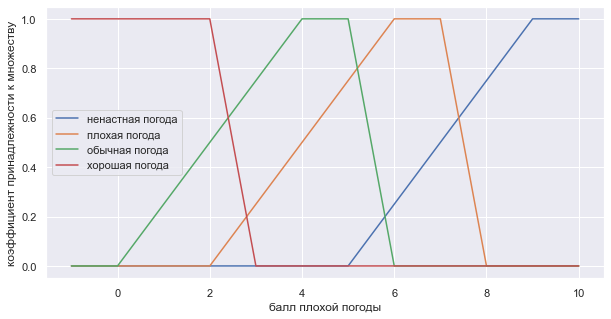

In [1492]:
plt.figure(figsize=(10,5))
ax = bad_weather_domain.very_bad.plot(label = 'ненастная погода')
bad_weather_domain.bad.plot(label='плохая погода')
bad_weather_domain.neutral.plot(label='обычная погода')
bad_weather_domain.good.plot(label='хорошая погода')
plt.xlabel('балл плохой погоды')
plt.ylabel('коэффициент принадлежности к множеству')
plt.legend();

In [1477]:
traffic_jams_domain = DomainCorrected("traffic_jams_domain", 0, 10, res=1)
traffic_jams_domain.no_traffic = rectangular(0, 3)
traffic_jams_domain.some_traffic = trapezoid(2, 4, 6, 7)
traffic_jams_domain.heavy_traffic = rectangular(7, 8)
traffic_jams_domain.traffic_congestion = rectangular(9, 10)

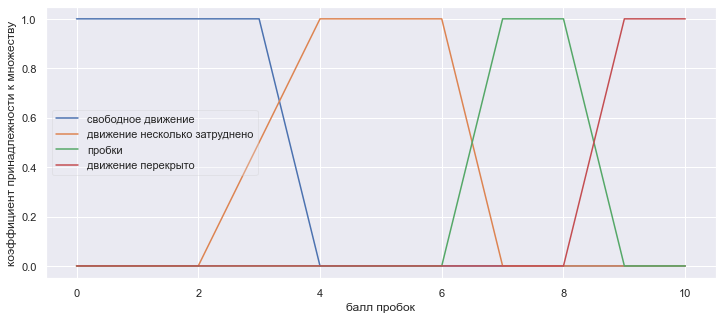

In [1491]:
plt.figure(figsize=(12,5))
traffic_jams_domain.no_traffic.plot(label='свободное движение')
traffic_jams_domain.some_traffic.plot(label='движение несколько затруднено')
traffic_jams_domain.heavy_traffic.plot(label='пробки')
traffic_jams_domain.traffic_congestion.plot(label='движение перекрыто')
plt.xlabel('балл пробок')
plt.ylabel('коэффициент принадлежности к множеству')
plt.legend(loc='center left', framealpha=0.3);

In [707]:
traffic_jams_domain(6)

{Set(<function rectangular.<locals>.f at 0x7fa09f961f70>): 0,
 Set(<function trapezoid.<locals>.f at 0x7fa09f9611f0>): 0.5,
 Set(<function trapezoid.<locals>.f at 0x7fa09f9765e0>): 1,
 Set(<function R.<locals>.f at 0x7fa09f9763a0>): 0}

In [1418]:
wind_domain = DomainCorrected("wind_domain", 0, 40, res=0.01)
wind_domain.no_wind = rectangular(0, 3)
wind_domain.light_breeze = trapezoid(1.50, 5, 7, 9)
wind_domain.moderate_breeze = trapezoid(7, 9, 11, 14)
wind_domain.strong_wind = trapezoid(8, 14, 16, 19)
wind_domain.storm = trapezoid(12, 19, 22, 26)
wind_domain.strong_storm = trapezoid(20, 26, 28, 32)
wind_domain.hurricane = R(28, 40)

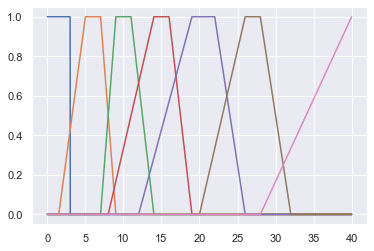

In [1403]:
wind_domain.no_wind.plot()
wind_domain.light_breeze.plot()
wind_domain.moderate_breeze.plot()
wind_domain.strong_wind.plot()
wind_domain.storm.plot()
wind_domain.strong_storm.plot()
wind_domain.hurricane.plot()

In [1419]:
temperature_domain = DomainCorrected("temperature_domain", -35, 40, res=0.01)
temperature_domain.severe_frost = S(-35, -20)
temperature_domain.frost = trapezoid(-25, -22, -19, -15)
temperature_domain.very_cold = trapezoid(-18, -14, -12, -9)
temperature_domain.cold = trapezoid(-12, -9, -6, -4)
temperature_domain.freeze = trapezoid(-5, -2, -0, 3)
temperature_domain.chilly = trapezoid(0, 3, 5, 8)
temperature_domain.warm = trapezoid(6, 10, 12, 16)
temperature_domain.comfortably_warm = trapezoid(15, 18, 20, 23)
temperature_domain.hot = trapezoid(20, 22, 25, 28)
temperature_domain.very_hot = trapezoid(26, 29, 32, 35)
temperature_domain.unbearably_hot = R(33, 40)

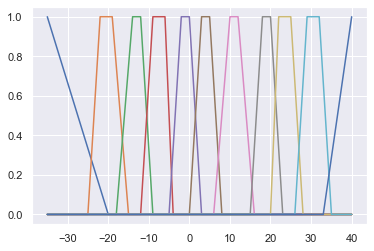

In [711]:
temperature_domain.severe_frost.plot()
temperature_domain.frost.plot()
temperature_domain.very_cold.plot()
temperature_domain.cold.plot()
temperature_domain.freeze.plot()
temperature_domain.chilly.plot()
temperature_domain.warm.plot()
temperature_domain.comfortably_warm.plot()
temperature_domain.hot.plot()
temperature_domain.very_hot.plot()
temperature_domain.unbearably_hot.plot()

In [1420]:
route_type_domain = DomainCorrected("route_type_domain", 0, 7, res=0.01)
route_type_domain.pedestrian = rectangular(0, 3)
route_type_domain.bike =  rectangular(1, 4)
route_type_domain.ot = rectangular(2, 5)
route_type_domain.taxi = rectangular(3, 6)
route_type_domain.car = rectangular(4, 7)

In [955]:
route_type_domain.pedestrian.name

'pedestrian'

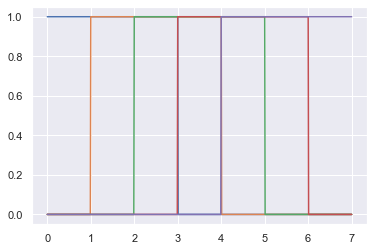

In [956]:
route_type_domain.pedestrian.plot()
route_type_domain.bike.plot()
route_type_domain.ot.plot()
route_type_domain.taxi.plot()
route_type_domain.car.plot()

In [1421]:
def formatRandomCondition(condition):
    return {temperature_domain: condition['температура'],
            wind_domain: condition['ветер'],
            traffic_jams_domain: condition['балл_пробок'],
            bad_weather_domain: condition['дождь'] + condition['дождь'] + \
                    condition['снег'] + condition['туман'] + condition['мгла'] + condition['гроза'] + \
                    condition['метель'] + condition['гололёд'] + condition['изморозь'] + condition['облачный день']}


In [715]:
env.get_env_context()

<ipython-input-592-1e183f844525>:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  days['proba'] = sp.bernoulli.rvs(days[mo])


{'балл_пробок': 6,
 'дождь': 0,
 'снег': 1,
 'туман': 0,
 'мгла': 0,
 'гроза': 0,
 'метель': 1,
 'гололёд': 0,
 'изморозь': 0,
 'ветер': 3.91,
 'облачный день': 1,
 'температура': -3.05}

In [916]:
t_extreme = ['severe_frost', 'frost', 'very_cold', 'cold', 'hot', 'very_hot', 'unbearably_hot']
weather = ['good', 'neutral', 'bad', 'very_bad']
tr_jams = ['no_traffic', 'some_traffic', 'heavy_traffic', 'traffic_congestion']
wind = ['no_wind', 'light_breeze', 'moderate_breeze', 'strong_wind', 'storm', 'strong_storm', 'hurricane']

In [917]:
cnt_extreme_weater = 0
for t in t_extreme:
    for ws in weather:
        for tr in tr_jams:
            for w in wind:
                cnt_extreme_weater+=3
                print('({}_1, temperature_domain.{}, wind_domain.{}, traffic_jams_domain.{}, bad_weather_domain.{}): route_type_domain.taxi,'.format(cnt_extreme_weater, t, w, tr, ws))
                print('({}_2, temperature_domain.{}, wind_domain.{}, traffic_jams_domain.{}, bad_weather_domain.{}): route_type_domain.ot,'.format(cnt_extreme_weater, t, w, tr, ws))
                print('({}_3, temperature_domain.{}, wind_domain.{}, traffic_jams_domain.{}, bad_weather_domain.{}): route_type_domain.car,'.format(cnt_extreme_weater, t, w, tr, ws))

(3_1, temperature_domain.severe_frost, wind_domain.no_wind, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.taxi,
(3_2, temperature_domain.severe_frost, wind_domain.no_wind, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.ot,
(3_3, temperature_domain.severe_frost, wind_domain.no_wind, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.car,
(6_1, temperature_domain.severe_frost, wind_domain.light_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.taxi,
(6_2, temperature_domain.severe_frost, wind_domain.light_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.ot,
(6_3, temperature_domain.severe_frost, wind_domain.light_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.car,
(9_1, temperature_domain.severe_frost, wind_domain.moderate_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_do

(1953_2, temperature_domain.very_hot, wind_domain.hurricane, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(1953_3, temperature_domain.very_hot, wind_domain.hurricane, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(1956_1, temperature_domain.very_hot, wind_domain.no_wind, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(1956_2, temperature_domain.very_hot, wind_domain.no_wind, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(1956_3, temperature_domain.very_hot, wind_domain.no_wind, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(1959_1, temperature_domain.very_hot, wind_domain.light_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(1959_2, temperature_domain.very_hot, wind_domain.light_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.ve

In [918]:
cnt_extreme_weater

2352

In [919]:
temperature = ['freeze', 'chilly', 'warm', 'comfortably_warm']
weather = ['good', 'neutral', 'bad', 'very_bad']
tr_jams = ['no_traffic', 'some_traffic', 'heavy_traffic', 'traffic_congestion']
wind_extreme = ['strong_wind', 'storm', 'strong_storm', 'hurricane']

In [920]:
cnt_extreme_wind_list = []
cnt_extreme_wind = 0
for t in temperature:
    for ws in weather:
        for tr in tr_jams:
            for w in wind_extreme:
                cnt_extreme_wind+=3
                print('({}_1, temperature_domain.{}, wind_domain.{}, traffic_jams_domain.{}, bad_weather_domain.{}): route_type_domain.taxi,'.format(cnt_extreme_wind, t, w, tr, ws))
                print('({}_2, temperature_domain.{}, wind_domain.{}, traffic_jams_domain.{}, bad_weather_domain.{}): route_type_domain.ot,'.format(cnt_extreme_wind, t, w, tr, ws))
                print('({}_3, temperature_domain.{}, wind_domain.{}, traffic_jams_domain.{}, bad_weather_domain.{}): route_type_domain.car,'.format(cnt_extreme_wind, t, w, tr, ws))

(3_1, temperature_domain.freeze, wind_domain.strong_wind, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.taxi,
(3_2, temperature_domain.freeze, wind_domain.strong_wind, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.ot,
(3_3, temperature_domain.freeze, wind_domain.strong_wind, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.car,
(6_1, temperature_domain.freeze, wind_domain.storm, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.taxi,
(6_2, temperature_domain.freeze, wind_domain.storm, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.ot,
(6_3, temperature_domain.freeze, wind_domain.storm, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.car,
(9_1, temperature_domain.freeze, wind_domain.strong_storm, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.taxi,
(9_2, temperature_domain.freeze, wind_domai

In [921]:
cnt_extreme_wind

768

In [931]:
temperature = ['freeze', 'chilly', 'warm', 'comfortably_warm', 'cold']
extreme_weather = ['bad']
tr_jams = ['no_traffic', 'some_traffic', 'heavy_traffic', 'traffic_congestion']
wind = ['no_wind', 'light_breeze', 'moderate_breeze']

In [932]:
cnt_extreme_weather = 0
for t in temperature:
    for ws in extreme_weather:
        for tr in tr_jams:
            for w in wind:
                cnt_extreme_weather+=3
                print('({}_1, temperature_domain.{}, wind_domain.{}, traffic_jams_domain.{}, bad_weather_domain.{}): route_type_domain.taxi,'.format(cnt_extreme_weather, t, w, tr, ws))
                print('({}_2, temperature_domain.{}, wind_domain.{}, traffic_jams_domain.{}, bad_weather_domain.{}): route_type_domain.ot,'.format(cnt_extreme_weather, t, w, tr, ws))
                print('({}_3, temperature_domain.{}, wind_domain.{}, traffic_jams_domain.{}, bad_weather_domain.{}): route_type_domain.car,'.format(cnt_extreme_weather, t, w, tr, ws))

(3_1, temperature_domain.freeze, wind_domain.no_wind, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(3_2, temperature_domain.freeze, wind_domain.no_wind, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.ot,
(3_3, temperature_domain.freeze, wind_domain.no_wind, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.car,
(6_1, temperature_domain.freeze, wind_domain.light_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(6_2, temperature_domain.freeze, wind_domain.light_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.ot,
(6_3, temperature_domain.freeze, wind_domain.light_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.car,
(9_1, temperature_domain.freeze, wind_domain.moderate_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(9_2, temperature_domain.freeze, wind_

In [924]:
cnt_extreme_weather

540

In [928]:
temperature = ['freeze', 'chilly', 'warm', 'comfortably_warm', 'cold', 'hot']
weather = ['good', 'neutral']
tr_jams_extreme = ['heavy_traffic', 'traffic_congestion']
wind = ['no_wind', 'light_breeze'
        , 'moderate_breeze']

In [929]:
cnt_extreme_traffic = 0
for t in temperature:
    for ws in weather:
        for tr in tr_jams_extreme:
            for w in wind:
                cnt_extreme_traffic+=1
                print('({}_1, temperature_domain.{}, wind_domain.{}, traffic_jams_domain.{}, bad_weather_domain.{}): route_type_domain.pedestrian,'.format(cnt_extreme_traffic, t, w, tr, ws))
                print('({}_2, temperature_domain.{}, wind_domain.{}, traffic_jams_domain.{}, bad_weather_domain.{}): route_type_domain.bike,'.format(cnt_extreme_traffic, t, w, tr, ws))

(1_1, temperature_domain.freeze, wind_domain.no_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.pedestrian,
(1_2, temperature_domain.freeze, wind_domain.no_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.bike,
(2_1, temperature_domain.freeze, wind_domain.light_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.pedestrian,
(2_2, temperature_domain.freeze, wind_domain.light_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.bike,
(3_1, temperature_domain.freeze, wind_domain.moderate_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.pedestrian,
(3_2, temperature_domain.freeze, wind_domain.moderate_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.bike,
(4_1, temperature_domain.freeze, wind_domain.no_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): ro

In [930]:
cnt_extreme_traffic

72

In [1531]:
R_extreme = RuleCorrected({(3_1, temperature_domain.severe_frost, wind_domain.no_wind, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.taxi,
(3_2, temperature_domain.severe_frost, wind_domain.no_wind, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.ot,
(3_3, temperature_domain.severe_frost, wind_domain.no_wind, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.car,
(6_1, temperature_domain.severe_frost, wind_domain.light_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.taxi,
(6_2, temperature_domain.severe_frost, wind_domain.light_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.ot,
(6_3, temperature_domain.severe_frost, wind_domain.light_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.car,
(9_1, temperature_domain.severe_frost, wind_domain.moderate_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.taxi,
(9_2, temperature_domain.severe_frost, wind_domain.moderate_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.ot,
(9_3, temperature_domain.severe_frost, wind_domain.moderate_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.car,
(12_1, temperature_domain.severe_frost, wind_domain.strong_wind, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.taxi,
(12_2, temperature_domain.severe_frost, wind_domain.strong_wind, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.ot,
(12_3, temperature_domain.severe_frost, wind_domain.strong_wind, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.car,
(15_1, temperature_domain.severe_frost, wind_domain.storm, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.taxi,
(15_2, temperature_domain.severe_frost, wind_domain.storm, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.ot,
(15_3, temperature_domain.severe_frost, wind_domain.storm, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.car,
(18_1, temperature_domain.severe_frost, wind_domain.strong_storm, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.taxi,
(18_2, temperature_domain.severe_frost, wind_domain.strong_storm, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.ot,
(18_3, temperature_domain.severe_frost, wind_domain.strong_storm, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.car,
(21_1, temperature_domain.severe_frost, wind_domain.hurricane, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.taxi,
(21_2, temperature_domain.severe_frost, wind_domain.hurricane, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.ot,
(21_3, temperature_domain.severe_frost, wind_domain.hurricane, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.car,
(24_1, temperature_domain.severe_frost, wind_domain.no_wind, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.taxi,
(24_2, temperature_domain.severe_frost, wind_domain.no_wind, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.ot,
(24_3, temperature_domain.severe_frost, wind_domain.no_wind, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.car,
(27_1, temperature_domain.severe_frost, wind_domain.light_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.taxi,
(27_2, temperature_domain.severe_frost, wind_domain.light_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.ot,
(27_3, temperature_domain.severe_frost, wind_domain.light_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.car,
(30_1, temperature_domain.severe_frost, wind_domain.moderate_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.taxi,
(30_2, temperature_domain.severe_frost, wind_domain.moderate_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.ot,
(30_3, temperature_domain.severe_frost, wind_domain.moderate_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.car,
(33_1, temperature_domain.severe_frost, wind_domain.strong_wind, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.taxi,
(33_2, temperature_domain.severe_frost, wind_domain.strong_wind, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.ot,
(33_3, temperature_domain.severe_frost, wind_domain.strong_wind, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.car,
(36_1, temperature_domain.severe_frost, wind_domain.storm, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.taxi,
(36_2, temperature_domain.severe_frost, wind_domain.storm, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.ot,
(36_3, temperature_domain.severe_frost, wind_domain.storm, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.car,
(39_1, temperature_domain.severe_frost, wind_domain.strong_storm, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.taxi,
(39_2, temperature_domain.severe_frost, wind_domain.strong_storm, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.ot,
(39_3, temperature_domain.severe_frost, wind_domain.strong_storm, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.car,
(42_1, temperature_domain.severe_frost, wind_domain.hurricane, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.taxi,
(42_2, temperature_domain.severe_frost, wind_domain.hurricane, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.ot,
(42_3, temperature_domain.severe_frost, wind_domain.hurricane, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.car,
(45_1, temperature_domain.severe_frost, wind_domain.no_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.taxi,
(45_2, temperature_domain.severe_frost, wind_domain.no_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.ot,
(45_3, temperature_domain.severe_frost, wind_domain.no_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.car,
(48_1, temperature_domain.severe_frost, wind_domain.light_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.taxi,
(48_2, temperature_domain.severe_frost, wind_domain.light_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.ot,
(48_3, temperature_domain.severe_frost, wind_domain.light_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.car,
(51_1, temperature_domain.severe_frost, wind_domain.moderate_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.taxi,
(51_2, temperature_domain.severe_frost, wind_domain.moderate_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.ot,
(51_3, temperature_domain.severe_frost, wind_domain.moderate_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.car,
(54_1, temperature_domain.severe_frost, wind_domain.strong_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.taxi,
(54_2, temperature_domain.severe_frost, wind_domain.strong_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.ot,
(54_3, temperature_domain.severe_frost, wind_domain.strong_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.car,
(57_1, temperature_domain.severe_frost, wind_domain.storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.taxi,
(57_2, temperature_domain.severe_frost, wind_domain.storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.ot,
(57_3, temperature_domain.severe_frost, wind_domain.storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.car,
(60_1, temperature_domain.severe_frost, wind_domain.strong_storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.taxi,
(60_2, temperature_domain.severe_frost, wind_domain.strong_storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.ot,
(60_3, temperature_domain.severe_frost, wind_domain.strong_storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.car,
(63_1, temperature_domain.severe_frost, wind_domain.hurricane, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.taxi,
(63_2, temperature_domain.severe_frost, wind_domain.hurricane, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.ot,
(63_3, temperature_domain.severe_frost, wind_domain.hurricane, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.car,
(66_1, temperature_domain.severe_frost, wind_domain.no_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.taxi,
(66_2, temperature_domain.severe_frost, wind_domain.no_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.ot,
(66_3, temperature_domain.severe_frost, wind_domain.no_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.car,
(69_1, temperature_domain.severe_frost, wind_domain.light_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.taxi,
(69_2, temperature_domain.severe_frost, wind_domain.light_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.ot,
(69_3, temperature_domain.severe_frost, wind_domain.light_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.car,
(72_1, temperature_domain.severe_frost, wind_domain.moderate_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.taxi,
(72_2, temperature_domain.severe_frost, wind_domain.moderate_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.ot,
(72_3, temperature_domain.severe_frost, wind_domain.moderate_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.car,
(75_1, temperature_domain.severe_frost, wind_domain.strong_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.taxi,
(75_2, temperature_domain.severe_frost, wind_domain.strong_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.ot,
(75_3, temperature_domain.severe_frost, wind_domain.strong_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.car,
(78_1, temperature_domain.severe_frost, wind_domain.storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.taxi,
(78_2, temperature_domain.severe_frost, wind_domain.storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.ot,
(78_3, temperature_domain.severe_frost, wind_domain.storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.car,
(81_1, temperature_domain.severe_frost, wind_domain.strong_storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.taxi,
(81_2, temperature_domain.severe_frost, wind_domain.strong_storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.ot,
(81_3, temperature_domain.severe_frost, wind_domain.strong_storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.car,
(84_1, temperature_domain.severe_frost, wind_domain.hurricane, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.taxi,
(84_2, temperature_domain.severe_frost, wind_domain.hurricane, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.ot,
(84_3, temperature_domain.severe_frost, wind_domain.hurricane, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.car,
(87_1, temperature_domain.severe_frost, wind_domain.no_wind, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(87_2, temperature_domain.severe_frost, wind_domain.no_wind, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(87_3, temperature_domain.severe_frost, wind_domain.no_wind, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.car,
(90_1, temperature_domain.severe_frost, wind_domain.light_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(90_2, temperature_domain.severe_frost, wind_domain.light_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(90_3, temperature_domain.severe_frost, wind_domain.light_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.car,
(93_1, temperature_domain.severe_frost, wind_domain.moderate_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(93_2, temperature_domain.severe_frost, wind_domain.moderate_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(93_3, temperature_domain.severe_frost, wind_domain.moderate_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.car,
(96_1, temperature_domain.severe_frost, wind_domain.strong_wind, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(96_2, temperature_domain.severe_frost, wind_domain.strong_wind, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(96_3, temperature_domain.severe_frost, wind_domain.strong_wind, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.car,
(99_1, temperature_domain.severe_frost, wind_domain.storm, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(99_2, temperature_domain.severe_frost, wind_domain.storm, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(99_3, temperature_domain.severe_frost, wind_domain.storm, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.car,
(102_1, temperature_domain.severe_frost, wind_domain.strong_storm, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(102_2, temperature_domain.severe_frost, wind_domain.strong_storm, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(102_3, temperature_domain.severe_frost, wind_domain.strong_storm, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.car,
(105_1, temperature_domain.severe_frost, wind_domain.hurricane, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(105_2, temperature_domain.severe_frost, wind_domain.hurricane, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(105_3, temperature_domain.severe_frost, wind_domain.hurricane, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.car,
(108_1, temperature_domain.severe_frost, wind_domain.no_wind, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(108_2, temperature_domain.severe_frost, wind_domain.no_wind, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(108_3, temperature_domain.severe_frost, wind_domain.no_wind, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.car,
(111_1, temperature_domain.severe_frost, wind_domain.light_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(111_2, temperature_domain.severe_frost, wind_domain.light_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(111_3, temperature_domain.severe_frost, wind_domain.light_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.car,
(114_1, temperature_domain.severe_frost, wind_domain.moderate_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(114_2, temperature_domain.severe_frost, wind_domain.moderate_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(114_3, temperature_domain.severe_frost, wind_domain.moderate_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.car,
(117_1, temperature_domain.severe_frost, wind_domain.strong_wind, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(117_2, temperature_domain.severe_frost, wind_domain.strong_wind, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(117_3, temperature_domain.severe_frost, wind_domain.strong_wind, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.car,
(120_1, temperature_domain.severe_frost, wind_domain.storm, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(120_2, temperature_domain.severe_frost, wind_domain.storm, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(120_3, temperature_domain.severe_frost, wind_domain.storm, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.car,
(123_1, temperature_domain.severe_frost, wind_domain.strong_storm, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(123_2, temperature_domain.severe_frost, wind_domain.strong_storm, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(123_3, temperature_domain.severe_frost, wind_domain.strong_storm, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.car,
(126_1, temperature_domain.severe_frost, wind_domain.hurricane, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(126_2, temperature_domain.severe_frost, wind_domain.hurricane, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(126_3, temperature_domain.severe_frost, wind_domain.hurricane, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.car,
(129_1, temperature_domain.severe_frost, wind_domain.no_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(129_2, temperature_domain.severe_frost, wind_domain.no_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(129_3, temperature_domain.severe_frost, wind_domain.no_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.car,
(132_1, temperature_domain.severe_frost, wind_domain.light_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(132_2, temperature_domain.severe_frost, wind_domain.light_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(132_3, temperature_domain.severe_frost, wind_domain.light_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.car,
(135_1, temperature_domain.severe_frost, wind_domain.moderate_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(135_2, temperature_domain.severe_frost, wind_domain.moderate_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(135_3, temperature_domain.severe_frost, wind_domain.moderate_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.car,
(138_1, temperature_domain.severe_frost, wind_domain.strong_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(138_2, temperature_domain.severe_frost, wind_domain.strong_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(138_3, temperature_domain.severe_frost, wind_domain.strong_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.car,
(141_1, temperature_domain.severe_frost, wind_domain.storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(141_2, temperature_domain.severe_frost, wind_domain.storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(141_3, temperature_domain.severe_frost, wind_domain.storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.car,
(144_1, temperature_domain.severe_frost, wind_domain.strong_storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(144_2, temperature_domain.severe_frost, wind_domain.strong_storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(144_3, temperature_domain.severe_frost, wind_domain.strong_storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.car,
(147_1, temperature_domain.severe_frost, wind_domain.hurricane, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(147_2, temperature_domain.severe_frost, wind_domain.hurricane, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(147_3, temperature_domain.severe_frost, wind_domain.hurricane, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.car,
(150_1, temperature_domain.severe_frost, wind_domain.no_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.taxi,
(150_2, temperature_domain.severe_frost, wind_domain.no_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.ot,
(150_3, temperature_domain.severe_frost, wind_domain.no_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.car,
(153_1, temperature_domain.severe_frost, wind_domain.light_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.taxi,
(153_2, temperature_domain.severe_frost, wind_domain.light_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.ot,
(153_3, temperature_domain.severe_frost, wind_domain.light_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.car,
(156_1, temperature_domain.severe_frost, wind_domain.moderate_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.taxi,
(156_2, temperature_domain.severe_frost, wind_domain.moderate_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.ot,
(156_3, temperature_domain.severe_frost, wind_domain.moderate_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.car,
(159_1, temperature_domain.severe_frost, wind_domain.strong_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.taxi,
(159_2, temperature_domain.severe_frost, wind_domain.strong_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.ot,
(159_3, temperature_domain.severe_frost, wind_domain.strong_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.car,
(162_1, temperature_domain.severe_frost, wind_domain.storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.taxi,
(162_2, temperature_domain.severe_frost, wind_domain.storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.ot,
(162_3, temperature_domain.severe_frost, wind_domain.storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.car,
(165_1, temperature_domain.severe_frost, wind_domain.strong_storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.taxi,
(165_2, temperature_domain.severe_frost, wind_domain.strong_storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.ot,
(165_3, temperature_domain.severe_frost, wind_domain.strong_storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.car,
(168_1, temperature_domain.severe_frost, wind_domain.hurricane, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.taxi,
(168_2, temperature_domain.severe_frost, wind_domain.hurricane, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.ot,
(168_3, temperature_domain.severe_frost, wind_domain.hurricane, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.car,
(171_1, temperature_domain.severe_frost, wind_domain.no_wind, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(171_2, temperature_domain.severe_frost, wind_domain.no_wind, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.ot,
(171_3, temperature_domain.severe_frost, wind_domain.no_wind, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.car,
(174_1, temperature_domain.severe_frost, wind_domain.light_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(174_2, temperature_domain.severe_frost, wind_domain.light_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.ot,
(174_3, temperature_domain.severe_frost, wind_domain.light_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.car,
(177_1, temperature_domain.severe_frost, wind_domain.moderate_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(177_2, temperature_domain.severe_frost, wind_domain.moderate_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.ot,
(177_3, temperature_domain.severe_frost, wind_domain.moderate_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.car,
(180_1, temperature_domain.severe_frost, wind_domain.strong_wind, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(180_2, temperature_domain.severe_frost, wind_domain.strong_wind, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.ot,
(180_3, temperature_domain.severe_frost, wind_domain.strong_wind, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.car,
(183_1, temperature_domain.severe_frost, wind_domain.storm, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(183_2, temperature_domain.severe_frost, wind_domain.storm, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.ot,
(183_3, temperature_domain.severe_frost, wind_domain.storm, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.car,
(186_1, temperature_domain.severe_frost, wind_domain.strong_storm, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(186_2, temperature_domain.severe_frost, wind_domain.strong_storm, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.ot,
(186_3, temperature_domain.severe_frost, wind_domain.strong_storm, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.car,
(189_1, temperature_domain.severe_frost, wind_domain.hurricane, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(189_2, temperature_domain.severe_frost, wind_domain.hurricane, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.ot,
(189_3, temperature_domain.severe_frost, wind_domain.hurricane, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.car,
(192_1, temperature_domain.severe_frost, wind_domain.no_wind, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(192_2, temperature_domain.severe_frost, wind_domain.no_wind, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.ot,
(192_3, temperature_domain.severe_frost, wind_domain.no_wind, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.car,
(195_1, temperature_domain.severe_frost, wind_domain.light_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(195_2, temperature_domain.severe_frost, wind_domain.light_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.ot,
(195_3, temperature_domain.severe_frost, wind_domain.light_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.car,
(198_1, temperature_domain.severe_frost, wind_domain.moderate_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(198_2, temperature_domain.severe_frost, wind_domain.moderate_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.ot,
(198_3, temperature_domain.severe_frost, wind_domain.moderate_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.car,
(201_1, temperature_domain.severe_frost, wind_domain.strong_wind, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(201_2, temperature_domain.severe_frost, wind_domain.strong_wind, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.ot,
(201_3, temperature_domain.severe_frost, wind_domain.strong_wind, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.car,
(204_1, temperature_domain.severe_frost, wind_domain.storm, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(204_2, temperature_domain.severe_frost, wind_domain.storm, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.ot,
(204_3, temperature_domain.severe_frost, wind_domain.storm, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.car,
(207_1, temperature_domain.severe_frost, wind_domain.strong_storm, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(207_2, temperature_domain.severe_frost, wind_domain.strong_storm, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.ot,
(207_3, temperature_domain.severe_frost, wind_domain.strong_storm, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.car,
(210_1, temperature_domain.severe_frost, wind_domain.hurricane, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(210_2, temperature_domain.severe_frost, wind_domain.hurricane, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.ot,
(210_3, temperature_domain.severe_frost, wind_domain.hurricane, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.car,
(213_1, temperature_domain.severe_frost, wind_domain.no_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(213_2, temperature_domain.severe_frost, wind_domain.no_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.ot,
(213_3, temperature_domain.severe_frost, wind_domain.no_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.car,
(216_1, temperature_domain.severe_frost, wind_domain.light_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(216_2, temperature_domain.severe_frost, wind_domain.light_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.ot,
(216_3, temperature_domain.severe_frost, wind_domain.light_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.car,
(219_1, temperature_domain.severe_frost, wind_domain.moderate_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(219_2, temperature_domain.severe_frost, wind_domain.moderate_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.ot,
(219_3, temperature_domain.severe_frost, wind_domain.moderate_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.car,
(222_1, temperature_domain.severe_frost, wind_domain.strong_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(222_2, temperature_domain.severe_frost, wind_domain.strong_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.ot,
(222_3, temperature_domain.severe_frost, wind_domain.strong_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.car,
(225_1, temperature_domain.severe_frost, wind_domain.storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(225_2, temperature_domain.severe_frost, wind_domain.storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.ot,
(225_3, temperature_domain.severe_frost, wind_domain.storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.car,
(228_1, temperature_domain.severe_frost, wind_domain.strong_storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(228_2, temperature_domain.severe_frost, wind_domain.strong_storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.ot,
(228_3, temperature_domain.severe_frost, wind_domain.strong_storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.car,
(231_1, temperature_domain.severe_frost, wind_domain.hurricane, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(231_2, temperature_domain.severe_frost, wind_domain.hurricane, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.ot,
(231_3, temperature_domain.severe_frost, wind_domain.hurricane, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.car,
(234_1, temperature_domain.severe_frost, wind_domain.no_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.taxi,
(234_2, temperature_domain.severe_frost, wind_domain.no_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.ot,
(234_3, temperature_domain.severe_frost, wind_domain.no_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.car,
(237_1, temperature_domain.severe_frost, wind_domain.light_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.taxi,
(237_2, temperature_domain.severe_frost, wind_domain.light_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.ot,
(237_3, temperature_domain.severe_frost, wind_domain.light_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.car,
(240_1, temperature_domain.severe_frost, wind_domain.moderate_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.taxi,
(240_2, temperature_domain.severe_frost, wind_domain.moderate_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.ot,
(240_3, temperature_domain.severe_frost, wind_domain.moderate_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.car,
(243_1, temperature_domain.severe_frost, wind_domain.strong_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.taxi,
(243_2, temperature_domain.severe_frost, wind_domain.strong_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.ot,
(243_3, temperature_domain.severe_frost, wind_domain.strong_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.car,
(246_1, temperature_domain.severe_frost, wind_domain.storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.taxi,
(246_2, temperature_domain.severe_frost, wind_domain.storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.ot,
(246_3, temperature_domain.severe_frost, wind_domain.storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.car,
(249_1, temperature_domain.severe_frost, wind_domain.strong_storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.taxi,
(249_2, temperature_domain.severe_frost, wind_domain.strong_storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.ot,
(249_3, temperature_domain.severe_frost, wind_domain.strong_storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.car,
(252_1, temperature_domain.severe_frost, wind_domain.hurricane, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.taxi,
(252_2, temperature_domain.severe_frost, wind_domain.hurricane, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.ot,
(252_3, temperature_domain.severe_frost, wind_domain.hurricane, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.car,
(255_1, temperature_domain.severe_frost, wind_domain.no_wind, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(255_2, temperature_domain.severe_frost, wind_domain.no_wind, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(255_3, temperature_domain.severe_frost, wind_domain.no_wind, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(258_1, temperature_domain.severe_frost, wind_domain.light_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(258_2, temperature_domain.severe_frost, wind_domain.light_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(258_3, temperature_domain.severe_frost, wind_domain.light_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(261_1, temperature_domain.severe_frost, wind_domain.moderate_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(261_2, temperature_domain.severe_frost, wind_domain.moderate_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(261_3, temperature_domain.severe_frost, wind_domain.moderate_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(264_1, temperature_domain.severe_frost, wind_domain.strong_wind, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(264_2, temperature_domain.severe_frost, wind_domain.strong_wind, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(264_3, temperature_domain.severe_frost, wind_domain.strong_wind, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(267_1, temperature_domain.severe_frost, wind_domain.storm, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(267_2, temperature_domain.severe_frost, wind_domain.storm, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(267_3, temperature_domain.severe_frost, wind_domain.storm, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(270_1, temperature_domain.severe_frost, wind_domain.strong_storm, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(270_2, temperature_domain.severe_frost, wind_domain.strong_storm, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(270_3, temperature_domain.severe_frost, wind_domain.strong_storm, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(273_1, temperature_domain.severe_frost, wind_domain.hurricane, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(273_2, temperature_domain.severe_frost, wind_domain.hurricane, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(273_3, temperature_domain.severe_frost, wind_domain.hurricane, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(276_1, temperature_domain.severe_frost, wind_domain.no_wind, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(276_2, temperature_domain.severe_frost, wind_domain.no_wind, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(276_3, temperature_domain.severe_frost, wind_domain.no_wind, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(279_1, temperature_domain.severe_frost, wind_domain.light_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(279_2, temperature_domain.severe_frost, wind_domain.light_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(279_3, temperature_domain.severe_frost, wind_domain.light_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(282_1, temperature_domain.severe_frost, wind_domain.moderate_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(282_2, temperature_domain.severe_frost, wind_domain.moderate_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(282_3, temperature_domain.severe_frost, wind_domain.moderate_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(285_1, temperature_domain.severe_frost, wind_domain.strong_wind, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(285_2, temperature_domain.severe_frost, wind_domain.strong_wind, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(285_3, temperature_domain.severe_frost, wind_domain.strong_wind, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(288_1, temperature_domain.severe_frost, wind_domain.storm, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(288_2, temperature_domain.severe_frost, wind_domain.storm, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(288_3, temperature_domain.severe_frost, wind_domain.storm, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(291_1, temperature_domain.severe_frost, wind_domain.strong_storm, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(291_2, temperature_domain.severe_frost, wind_domain.strong_storm, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(291_3, temperature_domain.severe_frost, wind_domain.strong_storm, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(294_1, temperature_domain.severe_frost, wind_domain.hurricane, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(294_2, temperature_domain.severe_frost, wind_domain.hurricane, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(294_3, temperature_domain.severe_frost, wind_domain.hurricane, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(297_1, temperature_domain.severe_frost, wind_domain.no_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(297_2, temperature_domain.severe_frost, wind_domain.no_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(297_3, temperature_domain.severe_frost, wind_domain.no_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(300_1, temperature_domain.severe_frost, wind_domain.light_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(300_2, temperature_domain.severe_frost, wind_domain.light_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(300_3, temperature_domain.severe_frost, wind_domain.light_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(303_1, temperature_domain.severe_frost, wind_domain.moderate_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(303_2, temperature_domain.severe_frost, wind_domain.moderate_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(303_3, temperature_domain.severe_frost, wind_domain.moderate_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(306_1, temperature_domain.severe_frost, wind_domain.strong_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(306_2, temperature_domain.severe_frost, wind_domain.strong_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(306_3, temperature_domain.severe_frost, wind_domain.strong_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(309_1, temperature_domain.severe_frost, wind_domain.storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(309_2, temperature_domain.severe_frost, wind_domain.storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(309_3, temperature_domain.severe_frost, wind_domain.storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(312_1, temperature_domain.severe_frost, wind_domain.strong_storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(312_2, temperature_domain.severe_frost, wind_domain.strong_storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(312_3, temperature_domain.severe_frost, wind_domain.strong_storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(315_1, temperature_domain.severe_frost, wind_domain.hurricane, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(315_2, temperature_domain.severe_frost, wind_domain.hurricane, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(315_3, temperature_domain.severe_frost, wind_domain.hurricane, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(318_1, temperature_domain.severe_frost, wind_domain.no_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.taxi,
(318_2, temperature_domain.severe_frost, wind_domain.no_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.ot,
(318_3, temperature_domain.severe_frost, wind_domain.no_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.car,
(321_1, temperature_domain.severe_frost, wind_domain.light_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.taxi,
(321_2, temperature_domain.severe_frost, wind_domain.light_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.ot,
(321_3, temperature_domain.severe_frost, wind_domain.light_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.car,
(324_1, temperature_domain.severe_frost, wind_domain.moderate_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.taxi,
(324_2, temperature_domain.severe_frost, wind_domain.moderate_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.ot,
(324_3, temperature_domain.severe_frost, wind_domain.moderate_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.car,
(327_1, temperature_domain.severe_frost, wind_domain.strong_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.taxi,
(327_2, temperature_domain.severe_frost, wind_domain.strong_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.ot,
(327_3, temperature_domain.severe_frost, wind_domain.strong_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.car,
(330_1, temperature_domain.severe_frost, wind_domain.storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.taxi,
(330_2, temperature_domain.severe_frost, wind_domain.storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.ot,
(330_3, temperature_domain.severe_frost, wind_domain.storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.car,
(333_1, temperature_domain.severe_frost, wind_domain.strong_storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.taxi,
(333_2, temperature_domain.severe_frost, wind_domain.strong_storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.ot,
(333_3, temperature_domain.severe_frost, wind_domain.strong_storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.car,
(336_1, temperature_domain.severe_frost, wind_domain.hurricane, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.taxi,
(336_2, temperature_domain.severe_frost, wind_domain.hurricane, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.ot,
(336_3, temperature_domain.severe_frost, wind_domain.hurricane, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.car,
(339_1, temperature_domain.frost, wind_domain.no_wind, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.taxi,
(339_2, temperature_domain.frost, wind_domain.no_wind, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.ot,
(339_3, temperature_domain.frost, wind_domain.no_wind, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.car,
(342_1, temperature_domain.frost, wind_domain.light_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.taxi,
(342_2, temperature_domain.frost, wind_domain.light_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.ot,
(342_3, temperature_domain.frost, wind_domain.light_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.car,
(345_1, temperature_domain.frost, wind_domain.moderate_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.taxi,
(345_2, temperature_domain.frost, wind_domain.moderate_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.ot,
(345_3, temperature_domain.frost, wind_domain.moderate_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.car,
(348_1, temperature_domain.frost, wind_domain.strong_wind, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.taxi,
(348_2, temperature_domain.frost, wind_domain.strong_wind, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.ot,
(348_3, temperature_domain.frost, wind_domain.strong_wind, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.car,
(351_1, temperature_domain.frost, wind_domain.storm, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.taxi,
(351_2, temperature_domain.frost, wind_domain.storm, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.ot,
(351_3, temperature_domain.frost, wind_domain.storm, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.car,
(354_1, temperature_domain.frost, wind_domain.strong_storm, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.taxi,
(354_2, temperature_domain.frost, wind_domain.strong_storm, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.ot,
(354_3, temperature_domain.frost, wind_domain.strong_storm, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.car,
(357_1, temperature_domain.frost, wind_domain.hurricane, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.taxi,
(357_2, temperature_domain.frost, wind_domain.hurricane, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.ot,
(357_3, temperature_domain.frost, wind_domain.hurricane, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.car,
(360_1, temperature_domain.frost, wind_domain.no_wind, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.taxi,
(360_2, temperature_domain.frost, wind_domain.no_wind, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.ot,
(360_3, temperature_domain.frost, wind_domain.no_wind, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.car,
(363_1, temperature_domain.frost, wind_domain.light_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.taxi,
(363_2, temperature_domain.frost, wind_domain.light_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.ot,
(363_3, temperature_domain.frost, wind_domain.light_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.car,
(366_1, temperature_domain.frost, wind_domain.moderate_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.taxi,
(366_2, temperature_domain.frost, wind_domain.moderate_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.ot,
(366_3, temperature_domain.frost, wind_domain.moderate_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.car,
(369_1, temperature_domain.frost, wind_domain.strong_wind, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.taxi,
(369_2, temperature_domain.frost, wind_domain.strong_wind, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.ot,
(369_3, temperature_domain.frost, wind_domain.strong_wind, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.car,
(372_1, temperature_domain.frost, wind_domain.storm, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.taxi,
(372_2, temperature_domain.frost, wind_domain.storm, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.ot,
(372_3, temperature_domain.frost, wind_domain.storm, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.car,
(375_1, temperature_domain.frost, wind_domain.strong_storm, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.taxi,
(375_2, temperature_domain.frost, wind_domain.strong_storm, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.ot,
(375_3, temperature_domain.frost, wind_domain.strong_storm, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.car,
(378_1, temperature_domain.frost, wind_domain.hurricane, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.taxi,
(378_2, temperature_domain.frost, wind_domain.hurricane, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.ot,
(378_3, temperature_domain.frost, wind_domain.hurricane, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.car,
(381_1, temperature_domain.frost, wind_domain.no_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.taxi,
(381_2, temperature_domain.frost, wind_domain.no_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.ot,
(381_3, temperature_domain.frost, wind_domain.no_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.car,
(384_1, temperature_domain.frost, wind_domain.light_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.taxi,
(384_2, temperature_domain.frost, wind_domain.light_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.ot,
(384_3, temperature_domain.frost, wind_domain.light_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.car,
(387_1, temperature_domain.frost, wind_domain.moderate_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.taxi,
(387_2, temperature_domain.frost, wind_domain.moderate_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.ot,
(387_3, temperature_domain.frost, wind_domain.moderate_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.car,
(390_1, temperature_domain.frost, wind_domain.strong_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.taxi,
(390_2, temperature_domain.frost, wind_domain.strong_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.ot,
(390_3, temperature_domain.frost, wind_domain.strong_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.car,
(393_1, temperature_domain.frost, wind_domain.storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.taxi,
(393_2, temperature_domain.frost, wind_domain.storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.ot,
(393_3, temperature_domain.frost, wind_domain.storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.car,
(396_1, temperature_domain.frost, wind_domain.strong_storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.taxi,
(396_2, temperature_domain.frost, wind_domain.strong_storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.ot,
(396_3, temperature_domain.frost, wind_domain.strong_storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.car,
(399_1, temperature_domain.frost, wind_domain.hurricane, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.taxi,
(399_2, temperature_domain.frost, wind_domain.hurricane, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.ot,
(399_3, temperature_domain.frost, wind_domain.hurricane, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.car,
(402_1, temperature_domain.frost, wind_domain.no_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.taxi,
(402_2, temperature_domain.frost, wind_domain.no_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.ot,
(402_3, temperature_domain.frost, wind_domain.no_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.car,
(405_1, temperature_domain.frost, wind_domain.light_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.taxi,
(405_2, temperature_domain.frost, wind_domain.light_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.ot,
(405_3, temperature_domain.frost, wind_domain.light_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.car,
(408_1, temperature_domain.frost, wind_domain.moderate_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.taxi,
(408_2, temperature_domain.frost, wind_domain.moderate_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.ot,
(408_3, temperature_domain.frost, wind_domain.moderate_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.car,
(411_1, temperature_domain.frost, wind_domain.strong_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.taxi,
(411_2, temperature_domain.frost, wind_domain.strong_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.ot,
(411_3, temperature_domain.frost, wind_domain.strong_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.car,
(414_1, temperature_domain.frost, wind_domain.storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.taxi,
(414_2, temperature_domain.frost, wind_domain.storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.ot,
(414_3, temperature_domain.frost, wind_domain.storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.car,
(417_1, temperature_domain.frost, wind_domain.strong_storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.taxi,
(417_2, temperature_domain.frost, wind_domain.strong_storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.ot,
(417_3, temperature_domain.frost, wind_domain.strong_storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.car,
(420_1, temperature_domain.frost, wind_domain.hurricane, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.taxi,
(420_2, temperature_domain.frost, wind_domain.hurricane, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.ot,
(420_3, temperature_domain.frost, wind_domain.hurricane, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.car,
(423_1, temperature_domain.frost, wind_domain.no_wind, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(423_2, temperature_domain.frost, wind_domain.no_wind, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(423_3, temperature_domain.frost, wind_domain.no_wind, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.car,
(426_1, temperature_domain.frost, wind_domain.light_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(426_2, temperature_domain.frost, wind_domain.light_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(426_3, temperature_domain.frost, wind_domain.light_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.car,
(429_1, temperature_domain.frost, wind_domain.moderate_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(429_2, temperature_domain.frost, wind_domain.moderate_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(429_3, temperature_domain.frost, wind_domain.moderate_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.car,
(432_1, temperature_domain.frost, wind_domain.strong_wind, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(432_2, temperature_domain.frost, wind_domain.strong_wind, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(432_3, temperature_domain.frost, wind_domain.strong_wind, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.car,
(435_1, temperature_domain.frost, wind_domain.storm, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(435_2, temperature_domain.frost, wind_domain.storm, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(435_3, temperature_domain.frost, wind_domain.storm, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.car,
(438_1, temperature_domain.frost, wind_domain.strong_storm, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(438_2, temperature_domain.frost, wind_domain.strong_storm, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(438_3, temperature_domain.frost, wind_domain.strong_storm, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.car,
(441_1, temperature_domain.frost, wind_domain.hurricane, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(441_2, temperature_domain.frost, wind_domain.hurricane, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(441_3, temperature_domain.frost, wind_domain.hurricane, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.car,
(444_1, temperature_domain.frost, wind_domain.no_wind, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(444_2, temperature_domain.frost, wind_domain.no_wind, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(444_3, temperature_domain.frost, wind_domain.no_wind, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.car,
(447_1, temperature_domain.frost, wind_domain.light_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(447_2, temperature_domain.frost, wind_domain.light_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(447_3, temperature_domain.frost, wind_domain.light_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.car,
(450_1, temperature_domain.frost, wind_domain.moderate_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(450_2, temperature_domain.frost, wind_domain.moderate_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(450_3, temperature_domain.frost, wind_domain.moderate_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.car,
(453_1, temperature_domain.frost, wind_domain.strong_wind, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(453_2, temperature_domain.frost, wind_domain.strong_wind, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(453_3, temperature_domain.frost, wind_domain.strong_wind, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.car,
(456_1, temperature_domain.frost, wind_domain.storm, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(456_2, temperature_domain.frost, wind_domain.storm, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(456_3, temperature_domain.frost, wind_domain.storm, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.car,
(459_1, temperature_domain.frost, wind_domain.strong_storm, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(459_2, temperature_domain.frost, wind_domain.strong_storm, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(459_3, temperature_domain.frost, wind_domain.strong_storm, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.car,
(462_1, temperature_domain.frost, wind_domain.hurricane, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(462_2, temperature_domain.frost, wind_domain.hurricane, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(462_3, temperature_domain.frost, wind_domain.hurricane, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.car,
(465_1, temperature_domain.frost, wind_domain.no_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(465_2, temperature_domain.frost, wind_domain.no_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(465_3, temperature_domain.frost, wind_domain.no_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.car,
(468_1, temperature_domain.frost, wind_domain.light_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(468_2, temperature_domain.frost, wind_domain.light_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(468_3, temperature_domain.frost, wind_domain.light_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.car,
(471_1, temperature_domain.frost, wind_domain.moderate_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(471_2, temperature_domain.frost, wind_domain.moderate_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(471_3, temperature_domain.frost, wind_domain.moderate_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.car,
(474_1, temperature_domain.frost, wind_domain.strong_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(474_2, temperature_domain.frost, wind_domain.strong_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(474_3, temperature_domain.frost, wind_domain.strong_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.car,
(477_1, temperature_domain.frost, wind_domain.storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(477_2, temperature_domain.frost, wind_domain.storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(477_3, temperature_domain.frost, wind_domain.storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.car,
(480_1, temperature_domain.frost, wind_domain.strong_storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(480_2, temperature_domain.frost, wind_domain.strong_storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(480_3, temperature_domain.frost, wind_domain.strong_storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.car,
(483_1, temperature_domain.frost, wind_domain.hurricane, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(483_2, temperature_domain.frost, wind_domain.hurricane, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(483_3, temperature_domain.frost, wind_domain.hurricane, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.car,
(486_1, temperature_domain.frost, wind_domain.no_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.taxi,
(486_2, temperature_domain.frost, wind_domain.no_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.ot,
(486_3, temperature_domain.frost, wind_domain.no_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.car,
(489_1, temperature_domain.frost, wind_domain.light_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.taxi,
(489_2, temperature_domain.frost, wind_domain.light_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.ot,
(489_3, temperature_domain.frost, wind_domain.light_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.car,
(492_1, temperature_domain.frost, wind_domain.moderate_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.taxi,
(492_2, temperature_domain.frost, wind_domain.moderate_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.ot,
(492_3, temperature_domain.frost, wind_domain.moderate_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.car,
(495_1, temperature_domain.frost, wind_domain.strong_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.taxi,
(495_2, temperature_domain.frost, wind_domain.strong_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.ot,
(495_3, temperature_domain.frost, wind_domain.strong_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.car,
(498_1, temperature_domain.frost, wind_domain.storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.taxi,
(498_2, temperature_domain.frost, wind_domain.storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.ot,
(498_3, temperature_domain.frost, wind_domain.storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.car,
(501_1, temperature_domain.frost, wind_domain.strong_storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.taxi,
(501_2, temperature_domain.frost, wind_domain.strong_storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.ot,
(501_3, temperature_domain.frost, wind_domain.strong_storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.car,
(504_1, temperature_domain.frost, wind_domain.hurricane, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.taxi,
(504_2, temperature_domain.frost, wind_domain.hurricane, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.ot,
(504_3, temperature_domain.frost, wind_domain.hurricane, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.car,
(507_1, temperature_domain.frost, wind_domain.no_wind, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(507_2, temperature_domain.frost, wind_domain.no_wind, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.ot,
(507_3, temperature_domain.frost, wind_domain.no_wind, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.car,
(510_1, temperature_domain.frost, wind_domain.light_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(510_2, temperature_domain.frost, wind_domain.light_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.ot,
(510_3, temperature_domain.frost, wind_domain.light_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.car,
(513_1, temperature_domain.frost, wind_domain.moderate_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(513_2, temperature_domain.frost, wind_domain.moderate_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.ot,
(513_3, temperature_domain.frost, wind_domain.moderate_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.car,
(516_1, temperature_domain.frost, wind_domain.strong_wind, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(516_2, temperature_domain.frost, wind_domain.strong_wind, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.ot,
(516_3, temperature_domain.frost, wind_domain.strong_wind, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.car,
(519_1, temperature_domain.frost, wind_domain.storm, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(519_2, temperature_domain.frost, wind_domain.storm, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.ot,
(519_3, temperature_domain.frost, wind_domain.storm, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.car,
(522_1, temperature_domain.frost, wind_domain.strong_storm, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(522_2, temperature_domain.frost, wind_domain.strong_storm, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.ot,
(522_3, temperature_domain.frost, wind_domain.strong_storm, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.car,
(525_1, temperature_domain.frost, wind_domain.hurricane, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(525_2, temperature_domain.frost, wind_domain.hurricane, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.ot,
(525_3, temperature_domain.frost, wind_domain.hurricane, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.car,
(528_1, temperature_domain.frost, wind_domain.no_wind, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(528_2, temperature_domain.frost, wind_domain.no_wind, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.ot,
(528_3, temperature_domain.frost, wind_domain.no_wind, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.car,
(531_1, temperature_domain.frost, wind_domain.light_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(531_2, temperature_domain.frost, wind_domain.light_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.ot,
(531_3, temperature_domain.frost, wind_domain.light_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.car,
(534_1, temperature_domain.frost, wind_domain.moderate_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(534_2, temperature_domain.frost, wind_domain.moderate_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.ot,
(534_3, temperature_domain.frost, wind_domain.moderate_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.car,
(537_1, temperature_domain.frost, wind_domain.strong_wind, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(537_2, temperature_domain.frost, wind_domain.strong_wind, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.ot,
(537_3, temperature_domain.frost, wind_domain.strong_wind, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.car,
(540_1, temperature_domain.frost, wind_domain.storm, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(540_2, temperature_domain.frost, wind_domain.storm, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.ot,
(540_3, temperature_domain.frost, wind_domain.storm, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.car,
(543_1, temperature_domain.frost, wind_domain.strong_storm, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(543_2, temperature_domain.frost, wind_domain.strong_storm, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.ot,
(543_3, temperature_domain.frost, wind_domain.strong_storm, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.car,
(546_1, temperature_domain.frost, wind_domain.hurricane, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(546_2, temperature_domain.frost, wind_domain.hurricane, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.ot,
(546_3, temperature_domain.frost, wind_domain.hurricane, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.car,
(549_1, temperature_domain.frost, wind_domain.no_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(549_2, temperature_domain.frost, wind_domain.no_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.ot,
(549_3, temperature_domain.frost, wind_domain.no_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.car,
(552_1, temperature_domain.frost, wind_domain.light_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(552_2, temperature_domain.frost, wind_domain.light_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.ot,
(552_3, temperature_domain.frost, wind_domain.light_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.car,
(555_1, temperature_domain.frost, wind_domain.moderate_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(555_2, temperature_domain.frost, wind_domain.moderate_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.ot,
(555_3, temperature_domain.frost, wind_domain.moderate_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.car,
(558_1, temperature_domain.frost, wind_domain.strong_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(558_2, temperature_domain.frost, wind_domain.strong_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.ot,
(558_3, temperature_domain.frost, wind_domain.strong_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.car,
(561_1, temperature_domain.frost, wind_domain.storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(561_2, temperature_domain.frost, wind_domain.storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.ot,
(561_3, temperature_domain.frost, wind_domain.storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.car,
(564_1, temperature_domain.frost, wind_domain.strong_storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(564_2, temperature_domain.frost, wind_domain.strong_storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.ot,
(564_3, temperature_domain.frost, wind_domain.strong_storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.car,
(567_1, temperature_domain.frost, wind_domain.hurricane, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(567_2, temperature_domain.frost, wind_domain.hurricane, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.ot,
(567_3, temperature_domain.frost, wind_domain.hurricane, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.car,
(570_1, temperature_domain.frost, wind_domain.no_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.taxi,
(570_2, temperature_domain.frost, wind_domain.no_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.ot,
(570_3, temperature_domain.frost, wind_domain.no_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.car,
(573_1, temperature_domain.frost, wind_domain.light_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.taxi,
(573_2, temperature_domain.frost, wind_domain.light_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.ot,
(573_3, temperature_domain.frost, wind_domain.light_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.car,
(576_1, temperature_domain.frost, wind_domain.moderate_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.taxi,
(576_2, temperature_domain.frost, wind_domain.moderate_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.ot,
(576_3, temperature_domain.frost, wind_domain.moderate_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.car,
(579_1, temperature_domain.frost, wind_domain.strong_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.taxi,
(579_2, temperature_domain.frost, wind_domain.strong_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.ot,
(579_3, temperature_domain.frost, wind_domain.strong_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.car,
(582_1, temperature_domain.frost, wind_domain.storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.taxi,
(582_2, temperature_domain.frost, wind_domain.storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.ot,
(582_3, temperature_domain.frost, wind_domain.storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.car,
(585_1, temperature_domain.frost, wind_domain.strong_storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.taxi,
(585_2, temperature_domain.frost, wind_domain.strong_storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.ot,
(585_3, temperature_domain.frost, wind_domain.strong_storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.car,
(588_1, temperature_domain.frost, wind_domain.hurricane, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.taxi,
(588_2, temperature_domain.frost, wind_domain.hurricane, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.ot,
(588_3, temperature_domain.frost, wind_domain.hurricane, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.car,
(591_1, temperature_domain.frost, wind_domain.no_wind, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(591_2, temperature_domain.frost, wind_domain.no_wind, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(591_3, temperature_domain.frost, wind_domain.no_wind, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(594_1, temperature_domain.frost, wind_domain.light_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(594_2, temperature_domain.frost, wind_domain.light_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(594_3, temperature_domain.frost, wind_domain.light_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(597_1, temperature_domain.frost, wind_domain.moderate_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(597_2, temperature_domain.frost, wind_domain.moderate_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(597_3, temperature_domain.frost, wind_domain.moderate_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(600_1, temperature_domain.frost, wind_domain.strong_wind, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(600_2, temperature_domain.frost, wind_domain.strong_wind, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(600_3, temperature_domain.frost, wind_domain.strong_wind, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(603_1, temperature_domain.frost, wind_domain.storm, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(603_2, temperature_domain.frost, wind_domain.storm, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(603_3, temperature_domain.frost, wind_domain.storm, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(606_1, temperature_domain.frost, wind_domain.strong_storm, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(606_2, temperature_domain.frost, wind_domain.strong_storm, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(606_3, temperature_domain.frost, wind_domain.strong_storm, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(609_1, temperature_domain.frost, wind_domain.hurricane, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(609_2, temperature_domain.frost, wind_domain.hurricane, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(609_3, temperature_domain.frost, wind_domain.hurricane, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(612_1, temperature_domain.frost, wind_domain.no_wind, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(612_2, temperature_domain.frost, wind_domain.no_wind, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(612_3, temperature_domain.frost, wind_domain.no_wind, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(615_1, temperature_domain.frost, wind_domain.light_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(615_2, temperature_domain.frost, wind_domain.light_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(615_3, temperature_domain.frost, wind_domain.light_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(618_1, temperature_domain.frost, wind_domain.moderate_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(618_2, temperature_domain.frost, wind_domain.moderate_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(618_3, temperature_domain.frost, wind_domain.moderate_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(621_1, temperature_domain.frost, wind_domain.strong_wind, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(621_2, temperature_domain.frost, wind_domain.strong_wind, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(621_3, temperature_domain.frost, wind_domain.strong_wind, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(624_1, temperature_domain.frost, wind_domain.storm, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(624_2, temperature_domain.frost, wind_domain.storm, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(624_3, temperature_domain.frost, wind_domain.storm, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(627_1, temperature_domain.frost, wind_domain.strong_storm, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(627_2, temperature_domain.frost, wind_domain.strong_storm, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(627_3, temperature_domain.frost, wind_domain.strong_storm, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(630_1, temperature_domain.frost, wind_domain.hurricane, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(630_2, temperature_domain.frost, wind_domain.hurricane, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(630_3, temperature_domain.frost, wind_domain.hurricane, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(633_1, temperature_domain.frost, wind_domain.no_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(633_2, temperature_domain.frost, wind_domain.no_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(633_3, temperature_domain.frost, wind_domain.no_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(636_1, temperature_domain.frost, wind_domain.light_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(636_2, temperature_domain.frost, wind_domain.light_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(636_3, temperature_domain.frost, wind_domain.light_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(639_1, temperature_domain.frost, wind_domain.moderate_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(639_2, temperature_domain.frost, wind_domain.moderate_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(639_3, temperature_domain.frost, wind_domain.moderate_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(642_1, temperature_domain.frost, wind_domain.strong_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(642_2, temperature_domain.frost, wind_domain.strong_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(642_3, temperature_domain.frost, wind_domain.strong_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(645_1, temperature_domain.frost, wind_domain.storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(645_2, temperature_domain.frost, wind_domain.storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(645_3, temperature_domain.frost, wind_domain.storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(648_1, temperature_domain.frost, wind_domain.strong_storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(648_2, temperature_domain.frost, wind_domain.strong_storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(648_3, temperature_domain.frost, wind_domain.strong_storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(651_1, temperature_domain.frost, wind_domain.hurricane, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(651_2, temperature_domain.frost, wind_domain.hurricane, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(651_3, temperature_domain.frost, wind_domain.hurricane, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(654_1, temperature_domain.frost, wind_domain.no_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.taxi,
(654_2, temperature_domain.frost, wind_domain.no_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.ot,
(654_3, temperature_domain.frost, wind_domain.no_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.car,
(657_1, temperature_domain.frost, wind_domain.light_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.taxi,
(657_2, temperature_domain.frost, wind_domain.light_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.ot,
(657_3, temperature_domain.frost, wind_domain.light_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.car,
(660_1, temperature_domain.frost, wind_domain.moderate_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.taxi,
(660_2, temperature_domain.frost, wind_domain.moderate_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.ot,
(660_3, temperature_domain.frost, wind_domain.moderate_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.car,
(663_1, temperature_domain.frost, wind_domain.strong_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.taxi,
(663_2, temperature_domain.frost, wind_domain.strong_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.ot,
(663_3, temperature_domain.frost, wind_domain.strong_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.car,
(666_1, temperature_domain.frost, wind_domain.storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.taxi,
(666_2, temperature_domain.frost, wind_domain.storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.ot,
(666_3, temperature_domain.frost, wind_domain.storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.car,
(669_1, temperature_domain.frost, wind_domain.strong_storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.taxi,
(669_2, temperature_domain.frost, wind_domain.strong_storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.ot,
(669_3, temperature_domain.frost, wind_domain.strong_storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.car,
(672_1, temperature_domain.frost, wind_domain.hurricane, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.taxi,
(672_2, temperature_domain.frost, wind_domain.hurricane, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.ot,
(672_3, temperature_domain.frost, wind_domain.hurricane, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.car,
(675_1, temperature_domain.very_cold, wind_domain.no_wind, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.taxi,
(675_2, temperature_domain.very_cold, wind_domain.no_wind, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.ot,
(675_3, temperature_domain.very_cold, wind_domain.no_wind, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.car,
(678_1, temperature_domain.very_cold, wind_domain.light_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.taxi,
(678_2, temperature_domain.very_cold, wind_domain.light_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.ot,
(678_3, temperature_domain.very_cold, wind_domain.light_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.car,
(681_1, temperature_domain.very_cold, wind_domain.moderate_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.taxi,
(681_2, temperature_domain.very_cold, wind_domain.moderate_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.ot,
(681_3, temperature_domain.very_cold, wind_domain.moderate_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.car,
(684_1, temperature_domain.very_cold, wind_domain.strong_wind, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.taxi,
(684_2, temperature_domain.very_cold, wind_domain.strong_wind, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.ot,
(684_3, temperature_domain.very_cold, wind_domain.strong_wind, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.car,
(687_1, temperature_domain.very_cold, wind_domain.storm, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.taxi,
(687_2, temperature_domain.very_cold, wind_domain.storm, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.ot,
(687_3, temperature_domain.very_cold, wind_domain.storm, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.car,
(690_1, temperature_domain.very_cold, wind_domain.strong_storm, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.taxi,
(690_2, temperature_domain.very_cold, wind_domain.strong_storm, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.ot,
(690_3, temperature_domain.very_cold, wind_domain.strong_storm, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.car,
(693_1, temperature_domain.very_cold, wind_domain.hurricane, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.taxi,
(693_2, temperature_domain.very_cold, wind_domain.hurricane, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.ot,
(693_3, temperature_domain.very_cold, wind_domain.hurricane, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.car,
(696_1, temperature_domain.very_cold, wind_domain.no_wind, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.taxi,
(696_2, temperature_domain.very_cold, wind_domain.no_wind, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.ot,
(696_3, temperature_domain.very_cold, wind_domain.no_wind, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.car,
(699_1, temperature_domain.very_cold, wind_domain.light_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.taxi,
(699_2, temperature_domain.very_cold, wind_domain.light_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.ot,
(699_3, temperature_domain.very_cold, wind_domain.light_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.car,
(702_1, temperature_domain.very_cold, wind_domain.moderate_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.taxi,
(702_2, temperature_domain.very_cold, wind_domain.moderate_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.ot,
(702_3, temperature_domain.very_cold, wind_domain.moderate_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.car,
(705_1, temperature_domain.very_cold, wind_domain.strong_wind, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.taxi,
(705_2, temperature_domain.very_cold, wind_domain.strong_wind, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.ot,
(705_3, temperature_domain.very_cold, wind_domain.strong_wind, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.car,
(708_1, temperature_domain.very_cold, wind_domain.storm, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.taxi,
(708_2, temperature_domain.very_cold, wind_domain.storm, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.ot,
(708_3, temperature_domain.very_cold, wind_domain.storm, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.car,
(711_1, temperature_domain.very_cold, wind_domain.strong_storm, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.taxi,
(711_2, temperature_domain.very_cold, wind_domain.strong_storm, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.ot,
(711_3, temperature_domain.very_cold, wind_domain.strong_storm, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.car,
(714_1, temperature_domain.very_cold, wind_domain.hurricane, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.taxi,
(714_2, temperature_domain.very_cold, wind_domain.hurricane, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.ot,
(714_3, temperature_domain.very_cold, wind_domain.hurricane, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.car,
(717_1, temperature_domain.very_cold, wind_domain.no_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.taxi,
(717_2, temperature_domain.very_cold, wind_domain.no_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.ot,
(717_3, temperature_domain.very_cold, wind_domain.no_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.car,
(720_1, temperature_domain.very_cold, wind_domain.light_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.taxi,
(720_2, temperature_domain.very_cold, wind_domain.light_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.ot,
(720_3, temperature_domain.very_cold, wind_domain.light_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.car,
(723_1, temperature_domain.very_cold, wind_domain.moderate_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.taxi,
(723_2, temperature_domain.very_cold, wind_domain.moderate_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.ot,
(723_3, temperature_domain.very_cold, wind_domain.moderate_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.car,
(726_1, temperature_domain.very_cold, wind_domain.strong_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.taxi,
(726_2, temperature_domain.very_cold, wind_domain.strong_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.ot,
(726_3, temperature_domain.very_cold, wind_domain.strong_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.car,
(729_1, temperature_domain.very_cold, wind_domain.storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.taxi,
(729_2, temperature_domain.very_cold, wind_domain.storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.ot,
(729_3, temperature_domain.very_cold, wind_domain.storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.car,
(732_1, temperature_domain.very_cold, wind_domain.strong_storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.taxi,
(732_2, temperature_domain.very_cold, wind_domain.strong_storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.ot,
(732_3, temperature_domain.very_cold, wind_domain.strong_storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.car,
(735_1, temperature_domain.very_cold, wind_domain.hurricane, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.taxi,
(735_2, temperature_domain.very_cold, wind_domain.hurricane, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.ot,
(735_3, temperature_domain.very_cold, wind_domain.hurricane, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.car,
(738_1, temperature_domain.very_cold, wind_domain.no_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.taxi,
(738_2, temperature_domain.very_cold, wind_domain.no_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.ot,
(738_3, temperature_domain.very_cold, wind_domain.no_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.car,
(741_1, temperature_domain.very_cold, wind_domain.light_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.taxi,
(741_2, temperature_domain.very_cold, wind_domain.light_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.ot,
(741_3, temperature_domain.very_cold, wind_domain.light_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.car,
(744_1, temperature_domain.very_cold, wind_domain.moderate_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.taxi,
(744_2, temperature_domain.very_cold, wind_domain.moderate_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.ot,
(744_3, temperature_domain.very_cold, wind_domain.moderate_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.car,
(747_1, temperature_domain.very_cold, wind_domain.strong_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.taxi,
(747_2, temperature_domain.very_cold, wind_domain.strong_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.ot,
(747_3, temperature_domain.very_cold, wind_domain.strong_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.car,
(750_1, temperature_domain.very_cold, wind_domain.storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.taxi,
(750_2, temperature_domain.very_cold, wind_domain.storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.ot,
(750_3, temperature_domain.very_cold, wind_domain.storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.car,
(753_1, temperature_domain.very_cold, wind_domain.strong_storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.taxi,
(753_2, temperature_domain.very_cold, wind_domain.strong_storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.ot,
(753_3, temperature_domain.very_cold, wind_domain.strong_storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.car,
(756_1, temperature_domain.very_cold, wind_domain.hurricane, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.taxi,
(756_2, temperature_domain.very_cold, wind_domain.hurricane, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.ot,
(756_3, temperature_domain.very_cold, wind_domain.hurricane, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.car,
(759_1, temperature_domain.very_cold, wind_domain.no_wind, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(759_2, temperature_domain.very_cold, wind_domain.no_wind, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(759_3, temperature_domain.very_cold, wind_domain.no_wind, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.car,
(762_1, temperature_domain.very_cold, wind_domain.light_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(762_2, temperature_domain.very_cold, wind_domain.light_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(762_3, temperature_domain.very_cold, wind_domain.light_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.car,
(765_1, temperature_domain.very_cold, wind_domain.moderate_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(765_2, temperature_domain.very_cold, wind_domain.moderate_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(765_3, temperature_domain.very_cold, wind_domain.moderate_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.car,
(768_1, temperature_domain.very_cold, wind_domain.strong_wind, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(768_2, temperature_domain.very_cold, wind_domain.strong_wind, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(768_3, temperature_domain.very_cold, wind_domain.strong_wind, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.car,
(771_1, temperature_domain.very_cold, wind_domain.storm, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(771_2, temperature_domain.very_cold, wind_domain.storm, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(771_3, temperature_domain.very_cold, wind_domain.storm, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.car,
(774_1, temperature_domain.very_cold, wind_domain.strong_storm, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(774_2, temperature_domain.very_cold, wind_domain.strong_storm, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(774_3, temperature_domain.very_cold, wind_domain.strong_storm, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.car,
(777_1, temperature_domain.very_cold, wind_domain.hurricane, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(777_2, temperature_domain.very_cold, wind_domain.hurricane, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(777_3, temperature_domain.very_cold, wind_domain.hurricane, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.car,
(780_1, temperature_domain.very_cold, wind_domain.no_wind, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(780_2, temperature_domain.very_cold, wind_domain.no_wind, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(780_3, temperature_domain.very_cold, wind_domain.no_wind, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.car,
(783_1, temperature_domain.very_cold, wind_domain.light_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(783_2, temperature_domain.very_cold, wind_domain.light_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(783_3, temperature_domain.very_cold, wind_domain.light_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.car,
(786_1, temperature_domain.very_cold, wind_domain.moderate_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(786_2, temperature_domain.very_cold, wind_domain.moderate_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(786_3, temperature_domain.very_cold, wind_domain.moderate_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.car,
(789_1, temperature_domain.very_cold, wind_domain.strong_wind, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(789_2, temperature_domain.very_cold, wind_domain.strong_wind, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(789_3, temperature_domain.very_cold, wind_domain.strong_wind, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.car,
(792_1, temperature_domain.very_cold, wind_domain.storm, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(792_2, temperature_domain.very_cold, wind_domain.storm, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(792_3, temperature_domain.very_cold, wind_domain.storm, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.car,
(795_1, temperature_domain.very_cold, wind_domain.strong_storm, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(795_2, temperature_domain.very_cold, wind_domain.strong_storm, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(795_3, temperature_domain.very_cold, wind_domain.strong_storm, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.car,
(798_1, temperature_domain.very_cold, wind_domain.hurricane, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(798_2, temperature_domain.very_cold, wind_domain.hurricane, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(798_3, temperature_domain.very_cold, wind_domain.hurricane, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.car,
(801_1, temperature_domain.very_cold, wind_domain.no_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(801_2, temperature_domain.very_cold, wind_domain.no_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(801_3, temperature_domain.very_cold, wind_domain.no_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.car,
(804_1, temperature_domain.very_cold, wind_domain.light_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(804_2, temperature_domain.very_cold, wind_domain.light_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(804_3, temperature_domain.very_cold, wind_domain.light_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.car,
(807_1, temperature_domain.very_cold, wind_domain.moderate_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(807_2, temperature_domain.very_cold, wind_domain.moderate_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(807_3, temperature_domain.very_cold, wind_domain.moderate_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.car,
(810_1, temperature_domain.very_cold, wind_domain.strong_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(810_2, temperature_domain.very_cold, wind_domain.strong_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(810_3, temperature_domain.very_cold, wind_domain.strong_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.car,
(813_1, temperature_domain.very_cold, wind_domain.storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(813_2, temperature_domain.very_cold, wind_domain.storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(813_3, temperature_domain.very_cold, wind_domain.storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.car,
(816_1, temperature_domain.very_cold, wind_domain.strong_storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(816_2, temperature_domain.very_cold, wind_domain.strong_storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(816_3, temperature_domain.very_cold, wind_domain.strong_storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.car,
(819_1, temperature_domain.very_cold, wind_domain.hurricane, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(819_2, temperature_domain.very_cold, wind_domain.hurricane, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(819_3, temperature_domain.very_cold, wind_domain.hurricane, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.car,
(822_1, temperature_domain.very_cold, wind_domain.no_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.taxi,
(822_2, temperature_domain.very_cold, wind_domain.no_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.ot,
(822_3, temperature_domain.very_cold, wind_domain.no_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.car,
(825_1, temperature_domain.very_cold, wind_domain.light_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.taxi,
(825_2, temperature_domain.very_cold, wind_domain.light_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.ot,
(825_3, temperature_domain.very_cold, wind_domain.light_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.car,
(828_1, temperature_domain.very_cold, wind_domain.moderate_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.taxi,
(828_2, temperature_domain.very_cold, wind_domain.moderate_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.ot,
(828_3, temperature_domain.very_cold, wind_domain.moderate_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.car,
(831_1, temperature_domain.very_cold, wind_domain.strong_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.taxi,
(831_2, temperature_domain.very_cold, wind_domain.strong_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.ot,
(831_3, temperature_domain.very_cold, wind_domain.strong_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.car,
(834_1, temperature_domain.very_cold, wind_domain.storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.taxi,
(834_2, temperature_domain.very_cold, wind_domain.storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.ot,
(834_3, temperature_domain.very_cold, wind_domain.storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.car,
(837_1, temperature_domain.very_cold, wind_domain.strong_storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.taxi,
(837_2, temperature_domain.very_cold, wind_domain.strong_storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.ot,
(837_3, temperature_domain.very_cold, wind_domain.strong_storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.car,
(840_1, temperature_domain.very_cold, wind_domain.hurricane, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.taxi,
(840_2, temperature_domain.very_cold, wind_domain.hurricane, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.ot,
(840_3, temperature_domain.very_cold, wind_domain.hurricane, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.car,
(843_1, temperature_domain.very_cold, wind_domain.no_wind, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(843_2, temperature_domain.very_cold, wind_domain.no_wind, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.ot,
(843_3, temperature_domain.very_cold, wind_domain.no_wind, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.car,
(846_1, temperature_domain.very_cold, wind_domain.light_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(846_2, temperature_domain.very_cold, wind_domain.light_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.ot,
(846_3, temperature_domain.very_cold, wind_domain.light_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.car,
(849_1, temperature_domain.very_cold, wind_domain.moderate_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(849_2, temperature_domain.very_cold, wind_domain.moderate_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.ot,
(849_3, temperature_domain.very_cold, wind_domain.moderate_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.car,
(852_1, temperature_domain.very_cold, wind_domain.strong_wind, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(852_2, temperature_domain.very_cold, wind_domain.strong_wind, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.ot,
(852_3, temperature_domain.very_cold, wind_domain.strong_wind, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.car,
(855_1, temperature_domain.very_cold, wind_domain.storm, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(855_2, temperature_domain.very_cold, wind_domain.storm, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.ot,
(855_3, temperature_domain.very_cold, wind_domain.storm, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.car,
(858_1, temperature_domain.very_cold, wind_domain.strong_storm, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(858_2, temperature_domain.very_cold, wind_domain.strong_storm, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.ot,
(858_3, temperature_domain.very_cold, wind_domain.strong_storm, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.car,
(861_1, temperature_domain.very_cold, wind_domain.hurricane, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(861_2, temperature_domain.very_cold, wind_domain.hurricane, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.ot,
(861_3, temperature_domain.very_cold, wind_domain.hurricane, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.car,
(864_1, temperature_domain.very_cold, wind_domain.no_wind, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(864_2, temperature_domain.very_cold, wind_domain.no_wind, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.ot,
(864_3, temperature_domain.very_cold, wind_domain.no_wind, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.car,
(867_1, temperature_domain.very_cold, wind_domain.light_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(867_2, temperature_domain.very_cold, wind_domain.light_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.ot,
(867_3, temperature_domain.very_cold, wind_domain.light_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.car,
(870_1, temperature_domain.very_cold, wind_domain.moderate_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(870_2, temperature_domain.very_cold, wind_domain.moderate_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.ot,
(870_3, temperature_domain.very_cold, wind_domain.moderate_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.car,
(873_1, temperature_domain.very_cold, wind_domain.strong_wind, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(873_2, temperature_domain.very_cold, wind_domain.strong_wind, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.ot,
(873_3, temperature_domain.very_cold, wind_domain.strong_wind, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.car,
(876_1, temperature_domain.very_cold, wind_domain.storm, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(876_2, temperature_domain.very_cold, wind_domain.storm, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.ot,
(876_3, temperature_domain.very_cold, wind_domain.storm, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.car,
(879_1, temperature_domain.very_cold, wind_domain.strong_storm, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(879_2, temperature_domain.very_cold, wind_domain.strong_storm, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.ot,
(879_3, temperature_domain.very_cold, wind_domain.strong_storm, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.car,
(882_1, temperature_domain.very_cold, wind_domain.hurricane, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(882_2, temperature_domain.very_cold, wind_domain.hurricane, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.ot,
(882_3, temperature_domain.very_cold, wind_domain.hurricane, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.car,
(885_1, temperature_domain.very_cold, wind_domain.no_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(885_2, temperature_domain.very_cold, wind_domain.no_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.ot,
(885_3, temperature_domain.very_cold, wind_domain.no_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.car,
(888_1, temperature_domain.very_cold, wind_domain.light_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(888_2, temperature_domain.very_cold, wind_domain.light_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.ot,
(888_3, temperature_domain.very_cold, wind_domain.light_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.car,
(891_1, temperature_domain.very_cold, wind_domain.moderate_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(891_2, temperature_domain.very_cold, wind_domain.moderate_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.ot,
(891_3, temperature_domain.very_cold, wind_domain.moderate_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.car,
(894_1, temperature_domain.very_cold, wind_domain.strong_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(894_2, temperature_domain.very_cold, wind_domain.strong_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.ot,
(894_3, temperature_domain.very_cold, wind_domain.strong_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.car,
(897_1, temperature_domain.very_cold, wind_domain.storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(897_2, temperature_domain.very_cold, wind_domain.storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.ot,
(897_3, temperature_domain.very_cold, wind_domain.storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.car,
(900_1, temperature_domain.very_cold, wind_domain.strong_storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(900_2, temperature_domain.very_cold, wind_domain.strong_storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.ot,
(900_3, temperature_domain.very_cold, wind_domain.strong_storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.car,
(903_1, temperature_domain.very_cold, wind_domain.hurricane, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(903_2, temperature_domain.very_cold, wind_domain.hurricane, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.ot,
(903_3, temperature_domain.very_cold, wind_domain.hurricane, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.car,
(906_1, temperature_domain.very_cold, wind_domain.no_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.taxi,
(906_2, temperature_domain.very_cold, wind_domain.no_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.ot,
(906_3, temperature_domain.very_cold, wind_domain.no_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.car,
(909_1, temperature_domain.very_cold, wind_domain.light_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.taxi,
(909_2, temperature_domain.very_cold, wind_domain.light_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.ot,
(909_3, temperature_domain.very_cold, wind_domain.light_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.car,
(912_1, temperature_domain.very_cold, wind_domain.moderate_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.taxi,
(912_2, temperature_domain.very_cold, wind_domain.moderate_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.ot,
(912_3, temperature_domain.very_cold, wind_domain.moderate_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.car,
(915_1, temperature_domain.very_cold, wind_domain.strong_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.taxi,
(915_2, temperature_domain.very_cold, wind_domain.strong_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.ot,
(915_3, temperature_domain.very_cold, wind_domain.strong_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.car,
(918_1, temperature_domain.very_cold, wind_domain.storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.taxi,
(918_2, temperature_domain.very_cold, wind_domain.storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.ot,
(918_3, temperature_domain.very_cold, wind_domain.storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.car,
(921_1, temperature_domain.very_cold, wind_domain.strong_storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.taxi,
(921_2, temperature_domain.very_cold, wind_domain.strong_storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.ot,
(921_3, temperature_domain.very_cold, wind_domain.strong_storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.car,
(924_1, temperature_domain.very_cold, wind_domain.hurricane, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.taxi,
(924_2, temperature_domain.very_cold, wind_domain.hurricane, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.ot,
(924_3, temperature_domain.very_cold, wind_domain.hurricane, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.car,
(927_1, temperature_domain.very_cold, wind_domain.no_wind, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(927_2, temperature_domain.very_cold, wind_domain.no_wind, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(927_3, temperature_domain.very_cold, wind_domain.no_wind, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(930_1, temperature_domain.very_cold, wind_domain.light_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(930_2, temperature_domain.very_cold, wind_domain.light_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(930_3, temperature_domain.very_cold, wind_domain.light_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(933_1, temperature_domain.very_cold, wind_domain.moderate_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(933_2, temperature_domain.very_cold, wind_domain.moderate_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(933_3, temperature_domain.very_cold, wind_domain.moderate_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(936_1, temperature_domain.very_cold, wind_domain.strong_wind, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(936_2, temperature_domain.very_cold, wind_domain.strong_wind, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(936_3, temperature_domain.very_cold, wind_domain.strong_wind, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(939_1, temperature_domain.very_cold, wind_domain.storm, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(939_2, temperature_domain.very_cold, wind_domain.storm, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(939_3, temperature_domain.very_cold, wind_domain.storm, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(942_1, temperature_domain.very_cold, wind_domain.strong_storm, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(942_2, temperature_domain.very_cold, wind_domain.strong_storm, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(942_3, temperature_domain.very_cold, wind_domain.strong_storm, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(945_1, temperature_domain.very_cold, wind_domain.hurricane, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(945_2, temperature_domain.very_cold, wind_domain.hurricane, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(945_3, temperature_domain.very_cold, wind_domain.hurricane, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(948_1, temperature_domain.very_cold, wind_domain.no_wind, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(948_2, temperature_domain.very_cold, wind_domain.no_wind, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(948_3, temperature_domain.very_cold, wind_domain.no_wind, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(951_1, temperature_domain.very_cold, wind_domain.light_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(951_2, temperature_domain.very_cold, wind_domain.light_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(951_3, temperature_domain.very_cold, wind_domain.light_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(954_1, temperature_domain.very_cold, wind_domain.moderate_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(954_2, temperature_domain.very_cold, wind_domain.moderate_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(954_3, temperature_domain.very_cold, wind_domain.moderate_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(957_1, temperature_domain.very_cold, wind_domain.strong_wind, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(957_2, temperature_domain.very_cold, wind_domain.strong_wind, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(957_3, temperature_domain.very_cold, wind_domain.strong_wind, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(960_1, temperature_domain.very_cold, wind_domain.storm, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(960_2, temperature_domain.very_cold, wind_domain.storm, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(960_3, temperature_domain.very_cold, wind_domain.storm, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(963_1, temperature_domain.very_cold, wind_domain.strong_storm, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(963_2, temperature_domain.very_cold, wind_domain.strong_storm, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(963_3, temperature_domain.very_cold, wind_domain.strong_storm, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(966_1, temperature_domain.very_cold, wind_domain.hurricane, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(966_2, temperature_domain.very_cold, wind_domain.hurricane, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(966_3, temperature_domain.very_cold, wind_domain.hurricane, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(969_1, temperature_domain.very_cold, wind_domain.no_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(969_2, temperature_domain.very_cold, wind_domain.no_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(969_3, temperature_domain.very_cold, wind_domain.no_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(972_1, temperature_domain.very_cold, wind_domain.light_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(972_2, temperature_domain.very_cold, wind_domain.light_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(972_3, temperature_domain.very_cold, wind_domain.light_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(975_1, temperature_domain.very_cold, wind_domain.moderate_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(975_2, temperature_domain.very_cold, wind_domain.moderate_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(975_3, temperature_domain.very_cold, wind_domain.moderate_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(978_1, temperature_domain.very_cold, wind_domain.strong_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(978_2, temperature_domain.very_cold, wind_domain.strong_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(978_3, temperature_domain.very_cold, wind_domain.strong_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(981_1, temperature_domain.very_cold, wind_domain.storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(981_2, temperature_domain.very_cold, wind_domain.storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(981_3, temperature_domain.very_cold, wind_domain.storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(984_1, temperature_domain.very_cold, wind_domain.strong_storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(984_2, temperature_domain.very_cold, wind_domain.strong_storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(984_3, temperature_domain.very_cold, wind_domain.strong_storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(987_1, temperature_domain.very_cold, wind_domain.hurricane, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(987_2, temperature_domain.very_cold, wind_domain.hurricane, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(987_3, temperature_domain.very_cold, wind_domain.hurricane, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(990_1, temperature_domain.very_cold, wind_domain.no_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.taxi,
(990_2, temperature_domain.very_cold, wind_domain.no_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.ot,
(990_3, temperature_domain.very_cold, wind_domain.no_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.car,
(993_1, temperature_domain.very_cold, wind_domain.light_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.taxi,
(993_2, temperature_domain.very_cold, wind_domain.light_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.ot,
(993_3, temperature_domain.very_cold, wind_domain.light_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.car,
(996_1, temperature_domain.very_cold, wind_domain.moderate_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.taxi,
(996_2, temperature_domain.very_cold, wind_domain.moderate_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.ot,
(996_3, temperature_domain.very_cold, wind_domain.moderate_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.car,
(999_1, temperature_domain.very_cold, wind_domain.strong_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.taxi,
(999_2, temperature_domain.very_cold, wind_domain.strong_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.ot,
(999_3, temperature_domain.very_cold, wind_domain.strong_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.car,
(1002_1, temperature_domain.very_cold, wind_domain.storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.taxi,
(1002_2, temperature_domain.very_cold, wind_domain.storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.ot,
(1002_3, temperature_domain.very_cold, wind_domain.storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.car,
(1005_1, temperature_domain.very_cold, wind_domain.strong_storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.taxi,
(1005_2, temperature_domain.very_cold, wind_domain.strong_storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.ot,
(1005_3, temperature_domain.very_cold, wind_domain.strong_storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.car,
(1008_1, temperature_domain.very_cold, wind_domain.hurricane, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.taxi,
(1008_2, temperature_domain.very_cold, wind_domain.hurricane, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.ot,
(1008_3, temperature_domain.very_cold, wind_domain.hurricane, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.car,
(1011_1, temperature_domain.cold, wind_domain.no_wind, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.taxi,
(1011_2, temperature_domain.cold, wind_domain.no_wind, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.ot,
(1011_3, temperature_domain.cold, wind_domain.no_wind, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.car,
(1014_1, temperature_domain.cold, wind_domain.light_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.taxi,
(1014_2, temperature_domain.cold, wind_domain.light_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.ot,
(1014_3, temperature_domain.cold, wind_domain.light_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.car,
(1017_1, temperature_domain.cold, wind_domain.moderate_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.taxi,
(1017_2, temperature_domain.cold, wind_domain.moderate_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.ot,
(1017_3, temperature_domain.cold, wind_domain.moderate_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.car,
(1020_1, temperature_domain.cold, wind_domain.strong_wind, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.taxi,
(1020_2, temperature_domain.cold, wind_domain.strong_wind, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.ot,
(1020_3, temperature_domain.cold, wind_domain.strong_wind, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.car,
(1023_1, temperature_domain.cold, wind_domain.storm, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.taxi,
(1023_2, temperature_domain.cold, wind_domain.storm, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.ot,
(1023_3, temperature_domain.cold, wind_domain.storm, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.car,
(1026_1, temperature_domain.cold, wind_domain.strong_storm, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.taxi,
(1026_2, temperature_domain.cold, wind_domain.strong_storm, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.ot,
(1026_3, temperature_domain.cold, wind_domain.strong_storm, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.car,
(1029_1, temperature_domain.cold, wind_domain.hurricane, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.taxi,
(1029_2, temperature_domain.cold, wind_domain.hurricane, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.ot,
(1029_3, temperature_domain.cold, wind_domain.hurricane, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.car,
(1032_1, temperature_domain.cold, wind_domain.no_wind, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.taxi,
(1032_2, temperature_domain.cold, wind_domain.no_wind, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.ot,
(1032_3, temperature_domain.cold, wind_domain.no_wind, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.car,
(1035_1, temperature_domain.cold, wind_domain.light_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.taxi,
(1035_2, temperature_domain.cold, wind_domain.light_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.ot,
(1035_3, temperature_domain.cold, wind_domain.light_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.car,
(1038_1, temperature_domain.cold, wind_domain.moderate_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.taxi,
(1038_2, temperature_domain.cold, wind_domain.moderate_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.ot,
(1038_3, temperature_domain.cold, wind_domain.moderate_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.car,
(1041_1, temperature_domain.cold, wind_domain.strong_wind, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.taxi,
(1041_2, temperature_domain.cold, wind_domain.strong_wind, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.ot,
(1041_3, temperature_domain.cold, wind_domain.strong_wind, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.car,
(1044_1, temperature_domain.cold, wind_domain.storm, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.taxi,
(1044_2, temperature_domain.cold, wind_domain.storm, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.ot,
(1044_3, temperature_domain.cold, wind_domain.storm, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.car,
(1047_1, temperature_domain.cold, wind_domain.strong_storm, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.taxi,
(1047_2, temperature_domain.cold, wind_domain.strong_storm, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.ot,
(1047_3, temperature_domain.cold, wind_domain.strong_storm, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.car,
(1050_1, temperature_domain.cold, wind_domain.hurricane, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.taxi,
(1050_2, temperature_domain.cold, wind_domain.hurricane, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.ot,
(1050_3, temperature_domain.cold, wind_domain.hurricane, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.car,
(1053_1, temperature_domain.cold, wind_domain.no_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.taxi,
(1053_2, temperature_domain.cold, wind_domain.no_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.ot,
(1053_3, temperature_domain.cold, wind_domain.no_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.car,
(1056_1, temperature_domain.cold, wind_domain.light_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.taxi,
(1056_2, temperature_domain.cold, wind_domain.light_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.ot,
(1056_3, temperature_domain.cold, wind_domain.light_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.car,
(1059_1, temperature_domain.cold, wind_domain.moderate_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.taxi,
(1059_2, temperature_domain.cold, wind_domain.moderate_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.ot,
(1059_3, temperature_domain.cold, wind_domain.moderate_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.car,
(1062_1, temperature_domain.cold, wind_domain.strong_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.taxi,
(1062_2, temperature_domain.cold, wind_domain.strong_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.ot,
(1062_3, temperature_domain.cold, wind_domain.strong_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.car,
(1065_1, temperature_domain.cold, wind_domain.storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.taxi,
(1065_2, temperature_domain.cold, wind_domain.storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.ot,
(1065_3, temperature_domain.cold, wind_domain.storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.car,
(1068_1, temperature_domain.cold, wind_domain.strong_storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.taxi,
(1068_2, temperature_domain.cold, wind_domain.strong_storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.ot,
(1068_3, temperature_domain.cold, wind_domain.strong_storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.car,
(1071_1, temperature_domain.cold, wind_domain.hurricane, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.taxi,
(1071_2, temperature_domain.cold, wind_domain.hurricane, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.ot,
(1071_3, temperature_domain.cold, wind_domain.hurricane, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.car,
(1074_1, temperature_domain.cold, wind_domain.no_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.taxi,
(1074_2, temperature_domain.cold, wind_domain.no_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.ot,
(1074_3, temperature_domain.cold, wind_domain.no_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.car,
(1077_1, temperature_domain.cold, wind_domain.light_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.taxi,
(1077_2, temperature_domain.cold, wind_domain.light_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.ot,
(1077_3, temperature_domain.cold, wind_domain.light_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.car,
(1080_1, temperature_domain.cold, wind_domain.moderate_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.taxi,
(1080_2, temperature_domain.cold, wind_domain.moderate_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.ot,
(1080_3, temperature_domain.cold, wind_domain.moderate_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.car,
(1083_1, temperature_domain.cold, wind_domain.strong_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.taxi,
(1083_2, temperature_domain.cold, wind_domain.strong_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.ot,
(1083_3, temperature_domain.cold, wind_domain.strong_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.car,
(1086_1, temperature_domain.cold, wind_domain.storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.taxi,
(1086_2, temperature_domain.cold, wind_domain.storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.ot,
(1086_3, temperature_domain.cold, wind_domain.storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.car,
(1089_1, temperature_domain.cold, wind_domain.strong_storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.taxi,
(1089_2, temperature_domain.cold, wind_domain.strong_storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.ot,
(1089_3, temperature_domain.cold, wind_domain.strong_storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.car,
(1092_1, temperature_domain.cold, wind_domain.hurricane, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.taxi,
(1092_2, temperature_domain.cold, wind_domain.hurricane, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.ot,
(1092_3, temperature_domain.cold, wind_domain.hurricane, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.car,
(1095_1, temperature_domain.cold, wind_domain.no_wind, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(1095_2, temperature_domain.cold, wind_domain.no_wind, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(1095_3, temperature_domain.cold, wind_domain.no_wind, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.car,
(1098_1, temperature_domain.cold, wind_domain.light_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(1098_2, temperature_domain.cold, wind_domain.light_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(1098_3, temperature_domain.cold, wind_domain.light_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.car,
(1101_1, temperature_domain.cold, wind_domain.moderate_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(1101_2, temperature_domain.cold, wind_domain.moderate_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(1101_3, temperature_domain.cold, wind_domain.moderate_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.car,
(1104_1, temperature_domain.cold, wind_domain.strong_wind, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(1104_2, temperature_domain.cold, wind_domain.strong_wind, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(1104_3, temperature_domain.cold, wind_domain.strong_wind, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.car,
(1107_1, temperature_domain.cold, wind_domain.storm, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(1107_2, temperature_domain.cold, wind_domain.storm, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(1107_3, temperature_domain.cold, wind_domain.storm, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.car,
(1110_1, temperature_domain.cold, wind_domain.strong_storm, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(1110_2, temperature_domain.cold, wind_domain.strong_storm, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(1110_3, temperature_domain.cold, wind_domain.strong_storm, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.car,
(1113_1, temperature_domain.cold, wind_domain.hurricane, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(1113_2, temperature_domain.cold, wind_domain.hurricane, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(1113_3, temperature_domain.cold, wind_domain.hurricane, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.car,
(1116_1, temperature_domain.cold, wind_domain.no_wind, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(1116_2, temperature_domain.cold, wind_domain.no_wind, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(1116_3, temperature_domain.cold, wind_domain.no_wind, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.car,
(1119_1, temperature_domain.cold, wind_domain.light_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(1119_2, temperature_domain.cold, wind_domain.light_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(1119_3, temperature_domain.cold, wind_domain.light_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.car,
(1122_1, temperature_domain.cold, wind_domain.moderate_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(1122_2, temperature_domain.cold, wind_domain.moderate_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(1122_3, temperature_domain.cold, wind_domain.moderate_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.car,
(1125_1, temperature_domain.cold, wind_domain.strong_wind, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(1125_2, temperature_domain.cold, wind_domain.strong_wind, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(1125_3, temperature_domain.cold, wind_domain.strong_wind, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.car,
(1128_1, temperature_domain.cold, wind_domain.storm, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(1128_2, temperature_domain.cold, wind_domain.storm, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(1128_3, temperature_domain.cold, wind_domain.storm, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.car,
(1131_1, temperature_domain.cold, wind_domain.strong_storm, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(1131_2, temperature_domain.cold, wind_domain.strong_storm, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(1131_3, temperature_domain.cold, wind_domain.strong_storm, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.car,
(1134_1, temperature_domain.cold, wind_domain.hurricane, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(1134_2, temperature_domain.cold, wind_domain.hurricane, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(1134_3, temperature_domain.cold, wind_domain.hurricane, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.car,
(1137_1, temperature_domain.cold, wind_domain.no_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(1137_2, temperature_domain.cold, wind_domain.no_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(1137_3, temperature_domain.cold, wind_domain.no_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.car,
(1140_1, temperature_domain.cold, wind_domain.light_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(1140_2, temperature_domain.cold, wind_domain.light_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(1140_3, temperature_domain.cold, wind_domain.light_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.car,
(1143_1, temperature_domain.cold, wind_domain.moderate_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(1143_2, temperature_domain.cold, wind_domain.moderate_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(1143_3, temperature_domain.cold, wind_domain.moderate_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.car,
(1146_1, temperature_domain.cold, wind_domain.strong_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(1146_2, temperature_domain.cold, wind_domain.strong_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(1146_3, temperature_domain.cold, wind_domain.strong_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.car,
(1149_1, temperature_domain.cold, wind_domain.storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(1149_2, temperature_domain.cold, wind_domain.storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(1149_3, temperature_domain.cold, wind_domain.storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.car,
(1152_1, temperature_domain.cold, wind_domain.strong_storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(1152_2, temperature_domain.cold, wind_domain.strong_storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(1152_3, temperature_domain.cold, wind_domain.strong_storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.car,
(1155_1, temperature_domain.cold, wind_domain.hurricane, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(1155_2, temperature_domain.cold, wind_domain.hurricane, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(1155_3, temperature_domain.cold, wind_domain.hurricane, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.car,
(1158_1, temperature_domain.cold, wind_domain.no_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.taxi,
(1158_2, temperature_domain.cold, wind_domain.no_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.ot,
(1158_3, temperature_domain.cold, wind_domain.no_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.car,
(1161_1, temperature_domain.cold, wind_domain.light_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.taxi,
(1161_2, temperature_domain.cold, wind_domain.light_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.ot,
(1161_3, temperature_domain.cold, wind_domain.light_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.car,
(1164_1, temperature_domain.cold, wind_domain.moderate_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.taxi,
(1164_2, temperature_domain.cold, wind_domain.moderate_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.ot,
(1164_3, temperature_domain.cold, wind_domain.moderate_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.car,
(1167_1, temperature_domain.cold, wind_domain.strong_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.taxi,
(1167_2, temperature_domain.cold, wind_domain.strong_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.ot,
(1167_3, temperature_domain.cold, wind_domain.strong_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.car,
(1170_1, temperature_domain.cold, wind_domain.storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.taxi,
(1170_2, temperature_domain.cold, wind_domain.storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.ot,
(1170_3, temperature_domain.cold, wind_domain.storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.car,
(1173_1, temperature_domain.cold, wind_domain.strong_storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.taxi,
(1173_2, temperature_domain.cold, wind_domain.strong_storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.ot,
(1173_3, temperature_domain.cold, wind_domain.strong_storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.car,
(1176_1, temperature_domain.cold, wind_domain.hurricane, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.taxi,
(1176_2, temperature_domain.cold, wind_domain.hurricane, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.ot,
(1176_3, temperature_domain.cold, wind_domain.hurricane, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.car,
(1179_1, temperature_domain.cold, wind_domain.no_wind, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(1179_2, temperature_domain.cold, wind_domain.no_wind, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.ot,
(1179_3, temperature_domain.cold, wind_domain.no_wind, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.car,
(1182_1, temperature_domain.cold, wind_domain.light_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(1182_2, temperature_domain.cold, wind_domain.light_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.ot,
(1182_3, temperature_domain.cold, wind_domain.light_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.car,
(1185_1, temperature_domain.cold, wind_domain.moderate_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(1185_2, temperature_domain.cold, wind_domain.moderate_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.ot,
(1185_3, temperature_domain.cold, wind_domain.moderate_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.car,
(1188_1, temperature_domain.cold, wind_domain.strong_wind, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(1188_2, temperature_domain.cold, wind_domain.strong_wind, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.ot,
(1188_3, temperature_domain.cold, wind_domain.strong_wind, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.car,
(1191_1, temperature_domain.cold, wind_domain.storm, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(1191_2, temperature_domain.cold, wind_domain.storm, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.ot,
(1191_3, temperature_domain.cold, wind_domain.storm, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.car,
(1194_1, temperature_domain.cold, wind_domain.strong_storm, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(1194_2, temperature_domain.cold, wind_domain.strong_storm, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.ot,
(1194_3, temperature_domain.cold, wind_domain.strong_storm, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.car,
(1197_1, temperature_domain.cold, wind_domain.hurricane, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(1197_2, temperature_domain.cold, wind_domain.hurricane, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.ot,
(1197_3, temperature_domain.cold, wind_domain.hurricane, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.car,
(1200_1, temperature_domain.cold, wind_domain.no_wind, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(1200_2, temperature_domain.cold, wind_domain.no_wind, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.ot,
(1200_3, temperature_domain.cold, wind_domain.no_wind, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.car,
(1203_1, temperature_domain.cold, wind_domain.light_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(1203_2, temperature_domain.cold, wind_domain.light_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.ot,
(1203_3, temperature_domain.cold, wind_domain.light_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.car,
(1206_1, temperature_domain.cold, wind_domain.moderate_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(1206_2, temperature_domain.cold, wind_domain.moderate_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.ot,
(1206_3, temperature_domain.cold, wind_domain.moderate_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.car,
(1209_1, temperature_domain.cold, wind_domain.strong_wind, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(1209_2, temperature_domain.cold, wind_domain.strong_wind, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.ot,
(1209_3, temperature_domain.cold, wind_domain.strong_wind, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.car,
(1212_1, temperature_domain.cold, wind_domain.storm, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(1212_2, temperature_domain.cold, wind_domain.storm, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.ot,
(1212_3, temperature_domain.cold, wind_domain.storm, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.car,
(1215_1, temperature_domain.cold, wind_domain.strong_storm, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(1215_2, temperature_domain.cold, wind_domain.strong_storm, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.ot,
(1215_3, temperature_domain.cold, wind_domain.strong_storm, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.car,
(1218_1, temperature_domain.cold, wind_domain.hurricane, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(1218_2, temperature_domain.cold, wind_domain.hurricane, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.ot,
(1218_3, temperature_domain.cold, wind_domain.hurricane, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.car,
(1221_1, temperature_domain.cold, wind_domain.no_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(1221_2, temperature_domain.cold, wind_domain.no_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.ot,
(1221_3, temperature_domain.cold, wind_domain.no_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.car,
(1224_1, temperature_domain.cold, wind_domain.light_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(1224_2, temperature_domain.cold, wind_domain.light_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.ot,
(1224_3, temperature_domain.cold, wind_domain.light_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.car,
(1227_1, temperature_domain.cold, wind_domain.moderate_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(1227_2, temperature_domain.cold, wind_domain.moderate_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.ot,
(1227_3, temperature_domain.cold, wind_domain.moderate_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.car,
(1230_1, temperature_domain.cold, wind_domain.strong_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(1230_2, temperature_domain.cold, wind_domain.strong_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.ot,
(1230_3, temperature_domain.cold, wind_domain.strong_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.car,
(1233_1, temperature_domain.cold, wind_domain.storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(1233_2, temperature_domain.cold, wind_domain.storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.ot,
(1233_3, temperature_domain.cold, wind_domain.storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.car,
(1236_1, temperature_domain.cold, wind_domain.strong_storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(1236_2, temperature_domain.cold, wind_domain.strong_storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.ot,
(1236_3, temperature_domain.cold, wind_domain.strong_storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.car,
(1239_1, temperature_domain.cold, wind_domain.hurricane, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(1239_2, temperature_domain.cold, wind_domain.hurricane, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.ot,
(1239_3, temperature_domain.cold, wind_domain.hurricane, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.car,
(1242_1, temperature_domain.cold, wind_domain.no_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.taxi,
(1242_2, temperature_domain.cold, wind_domain.no_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.ot,
(1242_3, temperature_domain.cold, wind_domain.no_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.car,
(1245_1, temperature_domain.cold, wind_domain.light_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.taxi,
(1245_2, temperature_domain.cold, wind_domain.light_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.ot,
(1245_3, temperature_domain.cold, wind_domain.light_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.car,
(1248_1, temperature_domain.cold, wind_domain.moderate_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.taxi,
(1248_2, temperature_domain.cold, wind_domain.moderate_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.ot,
(1248_3, temperature_domain.cold, wind_domain.moderate_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.car,
(1251_1, temperature_domain.cold, wind_domain.strong_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.taxi,
(1251_2, temperature_domain.cold, wind_domain.strong_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.ot,
(1251_3, temperature_domain.cold, wind_domain.strong_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.car,
(1254_1, temperature_domain.cold, wind_domain.storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.taxi,
(1254_2, temperature_domain.cold, wind_domain.storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.ot,
(1254_3, temperature_domain.cold, wind_domain.storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.car,
(1257_1, temperature_domain.cold, wind_domain.strong_storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.taxi,
(1257_2, temperature_domain.cold, wind_domain.strong_storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.ot,
(1257_3, temperature_domain.cold, wind_domain.strong_storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.car,
(1260_1, temperature_domain.cold, wind_domain.hurricane, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.taxi,
(1260_2, temperature_domain.cold, wind_domain.hurricane, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.ot,
(1260_3, temperature_domain.cold, wind_domain.hurricane, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.car,
(1263_1, temperature_domain.cold, wind_domain.no_wind, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(1263_2, temperature_domain.cold, wind_domain.no_wind, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(1263_3, temperature_domain.cold, wind_domain.no_wind, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(1266_1, temperature_domain.cold, wind_domain.light_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(1266_2, temperature_domain.cold, wind_domain.light_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(1266_3, temperature_domain.cold, wind_domain.light_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(1269_1, temperature_domain.cold, wind_domain.moderate_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(1269_2, temperature_domain.cold, wind_domain.moderate_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(1269_3, temperature_domain.cold, wind_domain.moderate_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(1272_1, temperature_domain.cold, wind_domain.strong_wind, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(1272_2, temperature_domain.cold, wind_domain.strong_wind, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(1272_3, temperature_domain.cold, wind_domain.strong_wind, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(1275_1, temperature_domain.cold, wind_domain.storm, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(1275_2, temperature_domain.cold, wind_domain.storm, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(1275_3, temperature_domain.cold, wind_domain.storm, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(1278_1, temperature_domain.cold, wind_domain.strong_storm, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(1278_2, temperature_domain.cold, wind_domain.strong_storm, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(1278_3, temperature_domain.cold, wind_domain.strong_storm, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(1281_1, temperature_domain.cold, wind_domain.hurricane, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(1281_2, temperature_domain.cold, wind_domain.hurricane, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(1281_3, temperature_domain.cold, wind_domain.hurricane, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(1284_1, temperature_domain.cold, wind_domain.no_wind, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(1284_2, temperature_domain.cold, wind_domain.no_wind, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(1284_3, temperature_domain.cold, wind_domain.no_wind, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(1287_1, temperature_domain.cold, wind_domain.light_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(1287_2, temperature_domain.cold, wind_domain.light_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(1287_3, temperature_domain.cold, wind_domain.light_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(1290_1, temperature_domain.cold, wind_domain.moderate_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(1290_2, temperature_domain.cold, wind_domain.moderate_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(1290_3, temperature_domain.cold, wind_domain.moderate_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(1293_1, temperature_domain.cold, wind_domain.strong_wind, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(1293_2, temperature_domain.cold, wind_domain.strong_wind, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(1293_3, temperature_domain.cold, wind_domain.strong_wind, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(1296_1, temperature_domain.cold, wind_domain.storm, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(1296_2, temperature_domain.cold, wind_domain.storm, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(1296_3, temperature_domain.cold, wind_domain.storm, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(1299_1, temperature_domain.cold, wind_domain.strong_storm, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(1299_2, temperature_domain.cold, wind_domain.strong_storm, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(1299_3, temperature_domain.cold, wind_domain.strong_storm, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(1302_1, temperature_domain.cold, wind_domain.hurricane, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(1302_2, temperature_domain.cold, wind_domain.hurricane, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(1302_3, temperature_domain.cold, wind_domain.hurricane, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(1305_1, temperature_domain.cold, wind_domain.no_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(1305_2, temperature_domain.cold, wind_domain.no_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(1305_3, temperature_domain.cold, wind_domain.no_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(1308_1, temperature_domain.cold, wind_domain.light_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(1308_2, temperature_domain.cold, wind_domain.light_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(1308_3, temperature_domain.cold, wind_domain.light_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(1311_1, temperature_domain.cold, wind_domain.moderate_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(1311_2, temperature_domain.cold, wind_domain.moderate_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(1311_3, temperature_domain.cold, wind_domain.moderate_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(1314_1, temperature_domain.cold, wind_domain.strong_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(1314_2, temperature_domain.cold, wind_domain.strong_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(1314_3, temperature_domain.cold, wind_domain.strong_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(1317_1, temperature_domain.cold, wind_domain.storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(1317_2, temperature_domain.cold, wind_domain.storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(1317_3, temperature_domain.cold, wind_domain.storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(1320_1, temperature_domain.cold, wind_domain.strong_storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(1320_2, temperature_domain.cold, wind_domain.strong_storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(1320_3, temperature_domain.cold, wind_domain.strong_storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(1323_1, temperature_domain.cold, wind_domain.hurricane, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(1323_2, temperature_domain.cold, wind_domain.hurricane, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(1323_3, temperature_domain.cold, wind_domain.hurricane, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(1326_1, temperature_domain.cold, wind_domain.no_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.taxi,
(1326_2, temperature_domain.cold, wind_domain.no_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.ot,
(1326_3, temperature_domain.cold, wind_domain.no_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.car,
(1329_1, temperature_domain.cold, wind_domain.light_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.taxi,
(1329_2, temperature_domain.cold, wind_domain.light_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.ot,
(1329_3, temperature_domain.cold, wind_domain.light_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.car,
(1332_1, temperature_domain.cold, wind_domain.moderate_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.taxi,
(1332_2, temperature_domain.cold, wind_domain.moderate_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.ot,
(1332_3, temperature_domain.cold, wind_domain.moderate_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.car,
(1335_1, temperature_domain.cold, wind_domain.strong_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.taxi,
(1335_2, temperature_domain.cold, wind_domain.strong_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.ot,
(1335_3, temperature_domain.cold, wind_domain.strong_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.car,
(1338_1, temperature_domain.cold, wind_domain.storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.taxi,
(1338_2, temperature_domain.cold, wind_domain.storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.ot,
(1338_3, temperature_domain.cold, wind_domain.storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.car,
(1341_1, temperature_domain.cold, wind_domain.strong_storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.taxi,
(1341_2, temperature_domain.cold, wind_domain.strong_storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.ot,
(1341_3, temperature_domain.cold, wind_domain.strong_storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.car,
(1344_1, temperature_domain.cold, wind_domain.hurricane, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.taxi,
(1344_2, temperature_domain.cold, wind_domain.hurricane, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.ot,
(1344_3, temperature_domain.cold, wind_domain.hurricane, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.car,
(1347_1, temperature_domain.hot, wind_domain.no_wind, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.taxi,
(1347_2, temperature_domain.hot, wind_domain.no_wind, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.ot,
(1347_3, temperature_domain.hot, wind_domain.no_wind, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.car,
(1350_1, temperature_domain.hot, wind_domain.light_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.taxi,
(1350_2, temperature_domain.hot, wind_domain.light_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.ot,
(1350_3, temperature_domain.hot, wind_domain.light_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.car,
(1353_1, temperature_domain.hot, wind_domain.moderate_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.taxi,
(1353_2, temperature_domain.hot, wind_domain.moderate_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.ot,
(1353_3, temperature_domain.hot, wind_domain.moderate_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.car,
(1356_1, temperature_domain.hot, wind_domain.strong_wind, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.taxi,
(1356_2, temperature_domain.hot, wind_domain.strong_wind, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.ot,
(1356_3, temperature_domain.hot, wind_domain.strong_wind, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.car,
(1359_1, temperature_domain.hot, wind_domain.storm, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.taxi,
(1359_2, temperature_domain.hot, wind_domain.storm, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.ot,
(1359_3, temperature_domain.hot, wind_domain.storm, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.car,
(1362_1, temperature_domain.hot, wind_domain.strong_storm, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.taxi,
(1362_2, temperature_domain.hot, wind_domain.strong_storm, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.ot,
(1362_3, temperature_domain.hot, wind_domain.strong_storm, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.car,
(1365_1, temperature_domain.hot, wind_domain.hurricane, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.taxi,
(1365_2, temperature_domain.hot, wind_domain.hurricane, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.ot,
(1365_3, temperature_domain.hot, wind_domain.hurricane, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.car,
(1368_1, temperature_domain.hot, wind_domain.no_wind, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.taxi,
(1368_2, temperature_domain.hot, wind_domain.no_wind, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.ot,
(1368_3, temperature_domain.hot, wind_domain.no_wind, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.car,
(1371_1, temperature_domain.hot, wind_domain.light_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.taxi,
(1371_2, temperature_domain.hot, wind_domain.light_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.ot,
(1371_3, temperature_domain.hot, wind_domain.light_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.car,
(1374_1, temperature_domain.hot, wind_domain.moderate_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.taxi,
(1374_2, temperature_domain.hot, wind_domain.moderate_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.ot,
(1374_3, temperature_domain.hot, wind_domain.moderate_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.car,
(1377_1, temperature_domain.hot, wind_domain.strong_wind, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.taxi,
(1377_2, temperature_domain.hot, wind_domain.strong_wind, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.ot,
(1377_3, temperature_domain.hot, wind_domain.strong_wind, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.car,
(1380_1, temperature_domain.hot, wind_domain.storm, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.taxi,
(1380_2, temperature_domain.hot, wind_domain.storm, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.ot,
(1380_3, temperature_domain.hot, wind_domain.storm, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.car,
(1383_1, temperature_domain.hot, wind_domain.strong_storm, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.taxi,
(1383_2, temperature_domain.hot, wind_domain.strong_storm, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.ot,
(1383_3, temperature_domain.hot, wind_domain.strong_storm, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.car,
(1386_1, temperature_domain.hot, wind_domain.hurricane, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.taxi,
(1386_2, temperature_domain.hot, wind_domain.hurricane, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.ot,
(1386_3, temperature_domain.hot, wind_domain.hurricane, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.car,
(1389_1, temperature_domain.hot, wind_domain.no_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.taxi,
(1389_2, temperature_domain.hot, wind_domain.no_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.ot,
(1389_3, temperature_domain.hot, wind_domain.no_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.car,
(1392_1, temperature_domain.hot, wind_domain.light_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.taxi,
(1392_2, temperature_domain.hot, wind_domain.light_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.ot,
(1392_3, temperature_domain.hot, wind_domain.light_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.car,
(1395_1, temperature_domain.hot, wind_domain.moderate_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.taxi,
(1395_2, temperature_domain.hot, wind_domain.moderate_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.ot,
(1395_3, temperature_domain.hot, wind_domain.moderate_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.car,
(1398_1, temperature_domain.hot, wind_domain.strong_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.taxi,
(1398_2, temperature_domain.hot, wind_domain.strong_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.ot,
(1398_3, temperature_domain.hot, wind_domain.strong_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.car,
(1401_1, temperature_domain.hot, wind_domain.storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.taxi,
(1401_2, temperature_domain.hot, wind_domain.storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.ot,
(1401_3, temperature_domain.hot, wind_domain.storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.car,
(1404_1, temperature_domain.hot, wind_domain.strong_storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.taxi,
(1404_2, temperature_domain.hot, wind_domain.strong_storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.ot,
(1404_3, temperature_domain.hot, wind_domain.strong_storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.car,
(1407_1, temperature_domain.hot, wind_domain.hurricane, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.taxi,
(1407_2, temperature_domain.hot, wind_domain.hurricane, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.ot,
(1407_3, temperature_domain.hot, wind_domain.hurricane, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.car,
(1410_1, temperature_domain.hot, wind_domain.no_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.taxi,
(1410_2, temperature_domain.hot, wind_domain.no_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.ot,
(1410_3, temperature_domain.hot, wind_domain.no_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.car,
(1413_1, temperature_domain.hot, wind_domain.light_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.taxi,
(1413_2, temperature_domain.hot, wind_domain.light_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.ot,
(1413_3, temperature_domain.hot, wind_domain.light_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.car,
(1416_1, temperature_domain.hot, wind_domain.moderate_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.taxi,
(1416_2, temperature_domain.hot, wind_domain.moderate_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.ot,
(1416_3, temperature_domain.hot, wind_domain.moderate_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.car,
(1419_1, temperature_domain.hot, wind_domain.strong_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.taxi,
(1419_2, temperature_domain.hot, wind_domain.strong_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.ot,
(1419_3, temperature_domain.hot, wind_domain.strong_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.car,
(1422_1, temperature_domain.hot, wind_domain.storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.taxi,
(1422_2, temperature_domain.hot, wind_domain.storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.ot,
(1422_3, temperature_domain.hot, wind_domain.storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.car,
(1425_1, temperature_domain.hot, wind_domain.strong_storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.taxi,
(1425_2, temperature_domain.hot, wind_domain.strong_storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.ot,
(1425_3, temperature_domain.hot, wind_domain.strong_storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.car,
(1428_1, temperature_domain.hot, wind_domain.hurricane, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.taxi,
(1428_2, temperature_domain.hot, wind_domain.hurricane, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.ot,
(1428_3, temperature_domain.hot, wind_domain.hurricane, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.car,
(1431_1, temperature_domain.hot, wind_domain.no_wind, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(1431_2, temperature_domain.hot, wind_domain.no_wind, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(1431_3, temperature_domain.hot, wind_domain.no_wind, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.car,
(1434_1, temperature_domain.hot, wind_domain.light_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(1434_2, temperature_domain.hot, wind_domain.light_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(1434_3, temperature_domain.hot, wind_domain.light_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.car,
(1437_1, temperature_domain.hot, wind_domain.moderate_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(1437_2, temperature_domain.hot, wind_domain.moderate_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(1437_3, temperature_domain.hot, wind_domain.moderate_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.car,
(1440_1, temperature_domain.hot, wind_domain.strong_wind, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(1440_2, temperature_domain.hot, wind_domain.strong_wind, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(1440_3, temperature_domain.hot, wind_domain.strong_wind, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.car,
(1443_1, temperature_domain.hot, wind_domain.storm, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(1443_2, temperature_domain.hot, wind_domain.storm, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(1443_3, temperature_domain.hot, wind_domain.storm, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.car,
(1446_1, temperature_domain.hot, wind_domain.strong_storm, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(1446_2, temperature_domain.hot, wind_domain.strong_storm, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(1446_3, temperature_domain.hot, wind_domain.strong_storm, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.car,
(1449_1, temperature_domain.hot, wind_domain.hurricane, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(1449_2, temperature_domain.hot, wind_domain.hurricane, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(1449_3, temperature_domain.hot, wind_domain.hurricane, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.car,
(1452_1, temperature_domain.hot, wind_domain.no_wind, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(1452_2, temperature_domain.hot, wind_domain.no_wind, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(1452_3, temperature_domain.hot, wind_domain.no_wind, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.car,
(1455_1, temperature_domain.hot, wind_domain.light_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(1455_2, temperature_domain.hot, wind_domain.light_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(1455_3, temperature_domain.hot, wind_domain.light_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.car,
(1458_1, temperature_domain.hot, wind_domain.moderate_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(1458_2, temperature_domain.hot, wind_domain.moderate_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(1458_3, temperature_domain.hot, wind_domain.moderate_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.car,
(1461_1, temperature_domain.hot, wind_domain.strong_wind, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(1461_2, temperature_domain.hot, wind_domain.strong_wind, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(1461_3, temperature_domain.hot, wind_domain.strong_wind, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.car,
(1464_1, temperature_domain.hot, wind_domain.storm, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(1464_2, temperature_domain.hot, wind_domain.storm, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(1464_3, temperature_domain.hot, wind_domain.storm, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.car,
(1467_1, temperature_domain.hot, wind_domain.strong_storm, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(1467_2, temperature_domain.hot, wind_domain.strong_storm, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(1467_3, temperature_domain.hot, wind_domain.strong_storm, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.car,
(1470_1, temperature_domain.hot, wind_domain.hurricane, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(1470_2, temperature_domain.hot, wind_domain.hurricane, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(1470_3, temperature_domain.hot, wind_domain.hurricane, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.car,
(1473_1, temperature_domain.hot, wind_domain.no_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(1473_2, temperature_domain.hot, wind_domain.no_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(1473_3, temperature_domain.hot, wind_domain.no_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.car,
(1476_1, temperature_domain.hot, wind_domain.light_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(1476_2, temperature_domain.hot, wind_domain.light_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(1476_3, temperature_domain.hot, wind_domain.light_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.car,
(1479_1, temperature_domain.hot, wind_domain.moderate_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(1479_2, temperature_domain.hot, wind_domain.moderate_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(1479_3, temperature_domain.hot, wind_domain.moderate_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.car,
(1482_1, temperature_domain.hot, wind_domain.strong_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(1482_2, temperature_domain.hot, wind_domain.strong_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(1482_3, temperature_domain.hot, wind_domain.strong_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.car,
(1485_1, temperature_domain.hot, wind_domain.storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(1485_2, temperature_domain.hot, wind_domain.storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(1485_3, temperature_domain.hot, wind_domain.storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.car,
(1488_1, temperature_domain.hot, wind_domain.strong_storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(1488_2, temperature_domain.hot, wind_domain.strong_storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(1488_3, temperature_domain.hot, wind_domain.strong_storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.car,
(1491_1, temperature_domain.hot, wind_domain.hurricane, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(1491_2, temperature_domain.hot, wind_domain.hurricane, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(1491_3, temperature_domain.hot, wind_domain.hurricane, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.car,
(1494_1, temperature_domain.hot, wind_domain.no_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.taxi,
(1494_2, temperature_domain.hot, wind_domain.no_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.ot,
(1494_3, temperature_domain.hot, wind_domain.no_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.car,
(1497_1, temperature_domain.hot, wind_domain.light_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.taxi,
(1497_2, temperature_domain.hot, wind_domain.light_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.ot,
(1497_3, temperature_domain.hot, wind_domain.light_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.car,
(1500_1, temperature_domain.hot, wind_domain.moderate_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.taxi,
(1500_2, temperature_domain.hot, wind_domain.moderate_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.ot,
(1500_3, temperature_domain.hot, wind_domain.moderate_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.car,
(1503_1, temperature_domain.hot, wind_domain.strong_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.taxi,
(1503_2, temperature_domain.hot, wind_domain.strong_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.ot,
(1503_3, temperature_domain.hot, wind_domain.strong_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.car,
(1506_1, temperature_domain.hot, wind_domain.storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.taxi,
(1506_2, temperature_domain.hot, wind_domain.storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.ot,
(1506_3, temperature_domain.hot, wind_domain.storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.car,
(1509_1, temperature_domain.hot, wind_domain.strong_storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.taxi,
(1509_2, temperature_domain.hot, wind_domain.strong_storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.ot,
(1509_3, temperature_domain.hot, wind_domain.strong_storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.car,
(1512_1, temperature_domain.hot, wind_domain.hurricane, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.taxi,
(1512_2, temperature_domain.hot, wind_domain.hurricane, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.ot,
(1512_3, temperature_domain.hot, wind_domain.hurricane, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.car,
(1515_1, temperature_domain.hot, wind_domain.no_wind, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(1515_2, temperature_domain.hot, wind_domain.no_wind, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.ot,
(1515_3, temperature_domain.hot, wind_domain.no_wind, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.car,
(1518_1, temperature_domain.hot, wind_domain.light_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(1518_2, temperature_domain.hot, wind_domain.light_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.ot,
(1518_3, temperature_domain.hot, wind_domain.light_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.car,
(1521_1, temperature_domain.hot, wind_domain.moderate_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(1521_2, temperature_domain.hot, wind_domain.moderate_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.ot,
(1521_3, temperature_domain.hot, wind_domain.moderate_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.car,
(1524_1, temperature_domain.hot, wind_domain.strong_wind, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(1524_2, temperature_domain.hot, wind_domain.strong_wind, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.ot,
(1524_3, temperature_domain.hot, wind_domain.strong_wind, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.car,
(1527_1, temperature_domain.hot, wind_domain.storm, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(1527_2, temperature_domain.hot, wind_domain.storm, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.ot,
(1527_3, temperature_domain.hot, wind_domain.storm, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.car,
(1530_1, temperature_domain.hot, wind_domain.strong_storm, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(1530_2, temperature_domain.hot, wind_domain.strong_storm, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.ot,
(1530_3, temperature_domain.hot, wind_domain.strong_storm, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.car,
(1533_1, temperature_domain.hot, wind_domain.hurricane, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(1533_2, temperature_domain.hot, wind_domain.hurricane, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.ot,
(1533_3, temperature_domain.hot, wind_domain.hurricane, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.car,
(1536_1, temperature_domain.hot, wind_domain.no_wind, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(1536_2, temperature_domain.hot, wind_domain.no_wind, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.ot,
(1536_3, temperature_domain.hot, wind_domain.no_wind, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.car,
(1539_1, temperature_domain.hot, wind_domain.light_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(1539_2, temperature_domain.hot, wind_domain.light_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.ot,
(1539_3, temperature_domain.hot, wind_domain.light_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.car,
(1542_1, temperature_domain.hot, wind_domain.moderate_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(1542_2, temperature_domain.hot, wind_domain.moderate_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.ot,
(1542_3, temperature_domain.hot, wind_domain.moderate_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.car,
(1545_1, temperature_domain.hot, wind_domain.strong_wind, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(1545_2, temperature_domain.hot, wind_domain.strong_wind, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.ot,
(1545_3, temperature_domain.hot, wind_domain.strong_wind, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.car,
(1548_1, temperature_domain.hot, wind_domain.storm, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(1548_2, temperature_domain.hot, wind_domain.storm, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.ot,
(1548_3, temperature_domain.hot, wind_domain.storm, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.car,
(1551_1, temperature_domain.hot, wind_domain.strong_storm, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(1551_2, temperature_domain.hot, wind_domain.strong_storm, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.ot,
(1551_3, temperature_domain.hot, wind_domain.strong_storm, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.car,
(1554_1, temperature_domain.hot, wind_domain.hurricane, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(1554_2, temperature_domain.hot, wind_domain.hurricane, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.ot,
(1554_3, temperature_domain.hot, wind_domain.hurricane, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.car,
(1557_1, temperature_domain.hot, wind_domain.no_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(1557_2, temperature_domain.hot, wind_domain.no_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.ot,
(1557_3, temperature_domain.hot, wind_domain.no_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.car,
(1560_1, temperature_domain.hot, wind_domain.light_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(1560_2, temperature_domain.hot, wind_domain.light_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.ot,
(1560_3, temperature_domain.hot, wind_domain.light_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.car,
(1563_1, temperature_domain.hot, wind_domain.moderate_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(1563_2, temperature_domain.hot, wind_domain.moderate_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.ot,
(1563_3, temperature_domain.hot, wind_domain.moderate_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.car,
(1566_1, temperature_domain.hot, wind_domain.strong_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(1566_2, temperature_domain.hot, wind_domain.strong_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.ot,
(1566_3, temperature_domain.hot, wind_domain.strong_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.car,
(1569_1, temperature_domain.hot, wind_domain.storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(1569_2, temperature_domain.hot, wind_domain.storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.ot,
(1569_3, temperature_domain.hot, wind_domain.storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.car,
(1572_1, temperature_domain.hot, wind_domain.strong_storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(1572_2, temperature_domain.hot, wind_domain.strong_storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.ot,
(1572_3, temperature_domain.hot, wind_domain.strong_storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.car,
(1575_1, temperature_domain.hot, wind_domain.hurricane, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(1575_2, temperature_domain.hot, wind_domain.hurricane, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.ot,
(1575_3, temperature_domain.hot, wind_domain.hurricane, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.car,
(1578_1, temperature_domain.hot, wind_domain.no_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.taxi,
(1578_2, temperature_domain.hot, wind_domain.no_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.ot,
(1578_3, temperature_domain.hot, wind_domain.no_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.car,
(1581_1, temperature_domain.hot, wind_domain.light_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.taxi,
(1581_2, temperature_domain.hot, wind_domain.light_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.ot,
(1581_3, temperature_domain.hot, wind_domain.light_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.car,
(1584_1, temperature_domain.hot, wind_domain.moderate_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.taxi,
(1584_2, temperature_domain.hot, wind_domain.moderate_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.ot,
(1584_3, temperature_domain.hot, wind_domain.moderate_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.car,
(1587_1, temperature_domain.hot, wind_domain.strong_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.taxi,
(1587_2, temperature_domain.hot, wind_domain.strong_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.ot,
(1587_3, temperature_domain.hot, wind_domain.strong_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.car,
(1590_1, temperature_domain.hot, wind_domain.storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.taxi,
(1590_2, temperature_domain.hot, wind_domain.storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.ot,
(1590_3, temperature_domain.hot, wind_domain.storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.car,
(1593_1, temperature_domain.hot, wind_domain.strong_storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.taxi,
(1593_2, temperature_domain.hot, wind_domain.strong_storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.ot,
(1593_3, temperature_domain.hot, wind_domain.strong_storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.car,
(1596_1, temperature_domain.hot, wind_domain.hurricane, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.taxi,
(1596_2, temperature_domain.hot, wind_domain.hurricane, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.ot,
(1596_3, temperature_domain.hot, wind_domain.hurricane, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.car,
(1599_1, temperature_domain.hot, wind_domain.no_wind, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(1599_2, temperature_domain.hot, wind_domain.no_wind, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(1599_3, temperature_domain.hot, wind_domain.no_wind, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(1602_1, temperature_domain.hot, wind_domain.light_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(1602_2, temperature_domain.hot, wind_domain.light_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(1602_3, temperature_domain.hot, wind_domain.light_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(1605_1, temperature_domain.hot, wind_domain.moderate_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(1605_2, temperature_domain.hot, wind_domain.moderate_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(1605_3, temperature_domain.hot, wind_domain.moderate_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(1608_1, temperature_domain.hot, wind_domain.strong_wind, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(1608_2, temperature_domain.hot, wind_domain.strong_wind, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(1608_3, temperature_domain.hot, wind_domain.strong_wind, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(1611_1, temperature_domain.hot, wind_domain.storm, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(1611_2, temperature_domain.hot, wind_domain.storm, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(1611_3, temperature_domain.hot, wind_domain.storm, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(1614_1, temperature_domain.hot, wind_domain.strong_storm, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(1614_2, temperature_domain.hot, wind_domain.strong_storm, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(1614_3, temperature_domain.hot, wind_domain.strong_storm, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(1617_1, temperature_domain.hot, wind_domain.hurricane, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(1617_2, temperature_domain.hot, wind_domain.hurricane, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(1617_3, temperature_domain.hot, wind_domain.hurricane, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(1620_1, temperature_domain.hot, wind_domain.no_wind, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(1620_2, temperature_domain.hot, wind_domain.no_wind, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(1620_3, temperature_domain.hot, wind_domain.no_wind, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(1623_1, temperature_domain.hot, wind_domain.light_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(1623_2, temperature_domain.hot, wind_domain.light_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(1623_3, temperature_domain.hot, wind_domain.light_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(1626_1, temperature_domain.hot, wind_domain.moderate_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(1626_2, temperature_domain.hot, wind_domain.moderate_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(1626_3, temperature_domain.hot, wind_domain.moderate_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(1629_1, temperature_domain.hot, wind_domain.strong_wind, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(1629_2, temperature_domain.hot, wind_domain.strong_wind, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(1629_3, temperature_domain.hot, wind_domain.strong_wind, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(1632_1, temperature_domain.hot, wind_domain.storm, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(1632_2, temperature_domain.hot, wind_domain.storm, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(1632_3, temperature_domain.hot, wind_domain.storm, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(1635_1, temperature_domain.hot, wind_domain.strong_storm, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(1635_2, temperature_domain.hot, wind_domain.strong_storm, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(1635_3, temperature_domain.hot, wind_domain.strong_storm, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(1638_1, temperature_domain.hot, wind_domain.hurricane, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(1638_2, temperature_domain.hot, wind_domain.hurricane, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(1638_3, temperature_domain.hot, wind_domain.hurricane, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(1641_1, temperature_domain.hot, wind_domain.no_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(1641_2, temperature_domain.hot, wind_domain.no_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(1641_3, temperature_domain.hot, wind_domain.no_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(1644_1, temperature_domain.hot, wind_domain.light_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(1644_2, temperature_domain.hot, wind_domain.light_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(1644_3, temperature_domain.hot, wind_domain.light_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(1647_1, temperature_domain.hot, wind_domain.moderate_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(1647_2, temperature_domain.hot, wind_domain.moderate_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(1647_3, temperature_domain.hot, wind_domain.moderate_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(1650_1, temperature_domain.hot, wind_domain.strong_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(1650_2, temperature_domain.hot, wind_domain.strong_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(1650_3, temperature_domain.hot, wind_domain.strong_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(1653_1, temperature_domain.hot, wind_domain.storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(1653_2, temperature_domain.hot, wind_domain.storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(1653_3, temperature_domain.hot, wind_domain.storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(1656_1, temperature_domain.hot, wind_domain.strong_storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(1656_2, temperature_domain.hot, wind_domain.strong_storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(1656_3, temperature_domain.hot, wind_domain.strong_storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(1659_1, temperature_domain.hot, wind_domain.hurricane, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(1659_2, temperature_domain.hot, wind_domain.hurricane, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(1659_3, temperature_domain.hot, wind_domain.hurricane, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(1662_1, temperature_domain.hot, wind_domain.no_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.taxi,
(1662_2, temperature_domain.hot, wind_domain.no_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.ot,
(1662_3, temperature_domain.hot, wind_domain.no_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.car,
(1665_1, temperature_domain.hot, wind_domain.light_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.taxi,
(1665_2, temperature_domain.hot, wind_domain.light_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.ot,
(1665_3, temperature_domain.hot, wind_domain.light_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.car,
(1668_1, temperature_domain.hot, wind_domain.moderate_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.taxi,
(1668_2, temperature_domain.hot, wind_domain.moderate_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.ot,
(1668_3, temperature_domain.hot, wind_domain.moderate_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.car,
(1671_1, temperature_domain.hot, wind_domain.strong_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.taxi,
(1671_2, temperature_domain.hot, wind_domain.strong_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.ot,
(1671_3, temperature_domain.hot, wind_domain.strong_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.car,
(1674_1, temperature_domain.hot, wind_domain.storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.taxi,
(1674_2, temperature_domain.hot, wind_domain.storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.ot,
(1674_3, temperature_domain.hot, wind_domain.storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.car,
(1677_1, temperature_domain.hot, wind_domain.strong_storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.taxi,
(1677_2, temperature_domain.hot, wind_domain.strong_storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.ot,
(1677_3, temperature_domain.hot, wind_domain.strong_storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.car,
(1680_1, temperature_domain.hot, wind_domain.hurricane, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.taxi,
(1680_2, temperature_domain.hot, wind_domain.hurricane, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.ot,
(1680_3, temperature_domain.hot, wind_domain.hurricane, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.car,
(1683_1, temperature_domain.very_hot, wind_domain.no_wind, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.taxi,
(1683_2, temperature_domain.very_hot, wind_domain.no_wind, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.ot,
(1683_3, temperature_domain.very_hot, wind_domain.no_wind, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.car,
(1686_1, temperature_domain.very_hot, wind_domain.light_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.taxi,
(1686_2, temperature_domain.very_hot, wind_domain.light_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.ot,
(1686_3, temperature_domain.very_hot, wind_domain.light_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.car,
(1689_1, temperature_domain.very_hot, wind_domain.moderate_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.taxi,
(1689_2, temperature_domain.very_hot, wind_domain.moderate_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.ot,
(1689_3, temperature_domain.very_hot, wind_domain.moderate_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.car,
(1692_1, temperature_domain.very_hot, wind_domain.strong_wind, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.taxi,
(1692_2, temperature_domain.very_hot, wind_domain.strong_wind, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.ot,
(1692_3, temperature_domain.very_hot, wind_domain.strong_wind, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.car,
(1695_1, temperature_domain.very_hot, wind_domain.storm, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.taxi,
(1695_2, temperature_domain.very_hot, wind_domain.storm, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.ot,
(1695_3, temperature_domain.very_hot, wind_domain.storm, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.car,
(1698_1, temperature_domain.very_hot, wind_domain.strong_storm, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.taxi,
(1698_2, temperature_domain.very_hot, wind_domain.strong_storm, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.ot,
(1698_3, temperature_domain.very_hot, wind_domain.strong_storm, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.car,
(1701_1, temperature_domain.very_hot, wind_domain.hurricane, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.taxi,
(1701_2, temperature_domain.very_hot, wind_domain.hurricane, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.ot,
(1701_3, temperature_domain.very_hot, wind_domain.hurricane, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.car,
(1704_1, temperature_domain.very_hot, wind_domain.no_wind, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.taxi,
(1704_2, temperature_domain.very_hot, wind_domain.no_wind, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.ot,
(1704_3, temperature_domain.very_hot, wind_domain.no_wind, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.car,
(1707_1, temperature_domain.very_hot, wind_domain.light_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.taxi,
(1707_2, temperature_domain.very_hot, wind_domain.light_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.ot,
(1707_3, temperature_domain.very_hot, wind_domain.light_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.car,
(1710_1, temperature_domain.very_hot, wind_domain.moderate_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.taxi,
(1710_2, temperature_domain.very_hot, wind_domain.moderate_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.ot,
(1710_3, temperature_domain.very_hot, wind_domain.moderate_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.car,
(1713_1, temperature_domain.very_hot, wind_domain.strong_wind, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.taxi,
(1713_2, temperature_domain.very_hot, wind_domain.strong_wind, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.ot,
(1713_3, temperature_domain.very_hot, wind_domain.strong_wind, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.car,
(1716_1, temperature_domain.very_hot, wind_domain.storm, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.taxi,
(1716_2, temperature_domain.very_hot, wind_domain.storm, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.ot,
(1716_3, temperature_domain.very_hot, wind_domain.storm, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.car,
(1719_1, temperature_domain.very_hot, wind_domain.strong_storm, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.taxi,
(1719_2, temperature_domain.very_hot, wind_domain.strong_storm, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.ot,
(1719_3, temperature_domain.very_hot, wind_domain.strong_storm, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.car,
(1722_1, temperature_domain.very_hot, wind_domain.hurricane, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.taxi,
(1722_2, temperature_domain.very_hot, wind_domain.hurricane, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.ot,
(1722_3, temperature_domain.very_hot, wind_domain.hurricane, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.car,
(1725_1, temperature_domain.very_hot, wind_domain.no_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.taxi,
(1725_2, temperature_domain.very_hot, wind_domain.no_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.ot,
(1725_3, temperature_domain.very_hot, wind_domain.no_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.car,
(1728_1, temperature_domain.very_hot, wind_domain.light_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.taxi,
(1728_2, temperature_domain.very_hot, wind_domain.light_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.ot,
(1728_3, temperature_domain.very_hot, wind_domain.light_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.car,
(1731_1, temperature_domain.very_hot, wind_domain.moderate_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.taxi,
(1731_2, temperature_domain.very_hot, wind_domain.moderate_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.ot,
(1731_3, temperature_domain.very_hot, wind_domain.moderate_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.car,
(1734_1, temperature_domain.very_hot, wind_domain.strong_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.taxi,
(1734_2, temperature_domain.very_hot, wind_domain.strong_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.ot,
(1734_3, temperature_domain.very_hot, wind_domain.strong_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.car,
(1737_1, temperature_domain.very_hot, wind_domain.storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.taxi,
(1737_2, temperature_domain.very_hot, wind_domain.storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.ot,
(1737_3, temperature_domain.very_hot, wind_domain.storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.car,
(1740_1, temperature_domain.very_hot, wind_domain.strong_storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.taxi,
(1740_2, temperature_domain.very_hot, wind_domain.strong_storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.ot,
(1740_3, temperature_domain.very_hot, wind_domain.strong_storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.car,
(1743_1, temperature_domain.very_hot, wind_domain.hurricane, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.taxi,
(1743_2, temperature_domain.very_hot, wind_domain.hurricane, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.ot,
(1743_3, temperature_domain.very_hot, wind_domain.hurricane, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.car,
(1746_1, temperature_domain.very_hot, wind_domain.no_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.taxi,
(1746_2, temperature_domain.very_hot, wind_domain.no_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.ot,
(1746_3, temperature_domain.very_hot, wind_domain.no_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.car,
(1749_1, temperature_domain.very_hot, wind_domain.light_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.taxi,
(1749_2, temperature_domain.very_hot, wind_domain.light_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.ot,
(1749_3, temperature_domain.very_hot, wind_domain.light_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.car,
(1752_1, temperature_domain.very_hot, wind_domain.moderate_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.taxi,
(1752_2, temperature_domain.very_hot, wind_domain.moderate_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.ot,
(1752_3, temperature_domain.very_hot, wind_domain.moderate_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.car,
(1755_1, temperature_domain.very_hot, wind_domain.strong_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.taxi,
(1755_2, temperature_domain.very_hot, wind_domain.strong_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.ot,
(1755_3, temperature_domain.very_hot, wind_domain.strong_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.car,
(1758_1, temperature_domain.very_hot, wind_domain.storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.taxi,
(1758_2, temperature_domain.very_hot, wind_domain.storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.ot,
(1758_3, temperature_domain.very_hot, wind_domain.storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.car,
(1761_1, temperature_domain.very_hot, wind_domain.strong_storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.taxi,
(1761_2, temperature_domain.very_hot, wind_domain.strong_storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.ot,
(1761_3, temperature_domain.very_hot, wind_domain.strong_storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.car,
(1764_1, temperature_domain.very_hot, wind_domain.hurricane, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.taxi,
(1764_2, temperature_domain.very_hot, wind_domain.hurricane, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.ot,
(1764_3, temperature_domain.very_hot, wind_domain.hurricane, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.car,
(1767_1, temperature_domain.very_hot, wind_domain.no_wind, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(1767_2, temperature_domain.very_hot, wind_domain.no_wind, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(1767_3, temperature_domain.very_hot, wind_domain.no_wind, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.car,
(1770_1, temperature_domain.very_hot, wind_domain.light_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(1770_2, temperature_domain.very_hot, wind_domain.light_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(1770_3, temperature_domain.very_hot, wind_domain.light_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.car,
(1773_1, temperature_domain.very_hot, wind_domain.moderate_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(1773_2, temperature_domain.very_hot, wind_domain.moderate_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(1773_3, temperature_domain.very_hot, wind_domain.moderate_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.car,
(1776_1, temperature_domain.very_hot, wind_domain.strong_wind, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(1776_2, temperature_domain.very_hot, wind_domain.strong_wind, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(1776_3, temperature_domain.very_hot, wind_domain.strong_wind, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.car,
(1779_1, temperature_domain.very_hot, wind_domain.storm, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(1779_2, temperature_domain.very_hot, wind_domain.storm, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(1779_3, temperature_domain.very_hot, wind_domain.storm, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.car,
(1782_1, temperature_domain.very_hot, wind_domain.strong_storm, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(1782_2, temperature_domain.very_hot, wind_domain.strong_storm, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(1782_3, temperature_domain.very_hot, wind_domain.strong_storm, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.car,
(1785_1, temperature_domain.very_hot, wind_domain.hurricane, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(1785_2, temperature_domain.very_hot, wind_domain.hurricane, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(1785_3, temperature_domain.very_hot, wind_domain.hurricane, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.car,
(1788_1, temperature_domain.very_hot, wind_domain.no_wind, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(1788_2, temperature_domain.very_hot, wind_domain.no_wind, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(1788_3, temperature_domain.very_hot, wind_domain.no_wind, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.car,
(1791_1, temperature_domain.very_hot, wind_domain.light_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(1791_2, temperature_domain.very_hot, wind_domain.light_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(1791_3, temperature_domain.very_hot, wind_domain.light_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.car,
(1794_1, temperature_domain.very_hot, wind_domain.moderate_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(1794_2, temperature_domain.very_hot, wind_domain.moderate_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(1794_3, temperature_domain.very_hot, wind_domain.moderate_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.car,
(1797_1, temperature_domain.very_hot, wind_domain.strong_wind, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(1797_2, temperature_domain.very_hot, wind_domain.strong_wind, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(1797_3, temperature_domain.very_hot, wind_domain.strong_wind, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.car,
(1800_1, temperature_domain.very_hot, wind_domain.storm, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(1800_2, temperature_domain.very_hot, wind_domain.storm, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(1800_3, temperature_domain.very_hot, wind_domain.storm, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.car,
(1803_1, temperature_domain.very_hot, wind_domain.strong_storm, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(1803_2, temperature_domain.very_hot, wind_domain.strong_storm, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(1803_3, temperature_domain.very_hot, wind_domain.strong_storm, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.car,
(1806_1, temperature_domain.very_hot, wind_domain.hurricane, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(1806_2, temperature_domain.very_hot, wind_domain.hurricane, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(1806_3, temperature_domain.very_hot, wind_domain.hurricane, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.car,
(1809_1, temperature_domain.very_hot, wind_domain.no_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(1809_2, temperature_domain.very_hot, wind_domain.no_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(1809_3, temperature_domain.very_hot, wind_domain.no_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.car,
(1812_1, temperature_domain.very_hot, wind_domain.light_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(1812_2, temperature_domain.very_hot, wind_domain.light_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(1812_3, temperature_domain.very_hot, wind_domain.light_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.car,
(1815_1, temperature_domain.very_hot, wind_domain.moderate_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(1815_2, temperature_domain.very_hot, wind_domain.moderate_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(1815_3, temperature_domain.very_hot, wind_domain.moderate_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.car,
(1818_1, temperature_domain.very_hot, wind_domain.strong_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(1818_2, temperature_domain.very_hot, wind_domain.strong_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(1818_3, temperature_domain.very_hot, wind_domain.strong_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.car,
(1821_1, temperature_domain.very_hot, wind_domain.storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(1821_2, temperature_domain.very_hot, wind_domain.storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(1821_3, temperature_domain.very_hot, wind_domain.storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.car,
(1824_1, temperature_domain.very_hot, wind_domain.strong_storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(1824_2, temperature_domain.very_hot, wind_domain.strong_storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(1824_3, temperature_domain.very_hot, wind_domain.strong_storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.car,
(1827_1, temperature_domain.very_hot, wind_domain.hurricane, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(1827_2, temperature_domain.very_hot, wind_domain.hurricane, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(1827_3, temperature_domain.very_hot, wind_domain.hurricane, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.car,
(1830_1, temperature_domain.very_hot, wind_domain.no_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.taxi,
(1830_2, temperature_domain.very_hot, wind_domain.no_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.ot,
(1830_3, temperature_domain.very_hot, wind_domain.no_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.car,
(1833_1, temperature_domain.very_hot, wind_domain.light_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.taxi,
(1833_2, temperature_domain.very_hot, wind_domain.light_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.ot,
(1833_3, temperature_domain.very_hot, wind_domain.light_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.car,
(1836_1, temperature_domain.very_hot, wind_domain.moderate_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.taxi,
(1836_2, temperature_domain.very_hot, wind_domain.moderate_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.ot,
(1836_3, temperature_domain.very_hot, wind_domain.moderate_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.car,
(1839_1, temperature_domain.very_hot, wind_domain.strong_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.taxi,
(1839_2, temperature_domain.very_hot, wind_domain.strong_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.ot,
(1839_3, temperature_domain.very_hot, wind_domain.strong_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.car,
(1842_1, temperature_domain.very_hot, wind_domain.storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.taxi,
(1842_2, temperature_domain.very_hot, wind_domain.storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.ot,
(1842_3, temperature_domain.very_hot, wind_domain.storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.car,
(1845_1, temperature_domain.very_hot, wind_domain.strong_storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.taxi,
(1845_2, temperature_domain.very_hot, wind_domain.strong_storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.ot,
(1845_3, temperature_domain.very_hot, wind_domain.strong_storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.car,
(1848_1, temperature_domain.very_hot, wind_domain.hurricane, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.taxi,
(1848_2, temperature_domain.very_hot, wind_domain.hurricane, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.ot,
(1848_3, temperature_domain.very_hot, wind_domain.hurricane, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.car,
(1851_1, temperature_domain.very_hot, wind_domain.no_wind, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(1851_2, temperature_domain.very_hot, wind_domain.no_wind, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.ot,
(1851_3, temperature_domain.very_hot, wind_domain.no_wind, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.car,
(1854_1, temperature_domain.very_hot, wind_domain.light_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(1854_2, temperature_domain.very_hot, wind_domain.light_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.ot,
(1854_3, temperature_domain.very_hot, wind_domain.light_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.car,
(1857_1, temperature_domain.very_hot, wind_domain.moderate_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(1857_2, temperature_domain.very_hot, wind_domain.moderate_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.ot,
(1857_3, temperature_domain.very_hot, wind_domain.moderate_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.car,
(1860_1, temperature_domain.very_hot, wind_domain.strong_wind, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(1860_2, temperature_domain.very_hot, wind_domain.strong_wind, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.ot,
(1860_3, temperature_domain.very_hot, wind_domain.strong_wind, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.car,
(1863_1, temperature_domain.very_hot, wind_domain.storm, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(1863_2, temperature_domain.very_hot, wind_domain.storm, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.ot,
(1863_3, temperature_domain.very_hot, wind_domain.storm, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.car,
(1866_1, temperature_domain.very_hot, wind_domain.strong_storm, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(1866_2, temperature_domain.very_hot, wind_domain.strong_storm, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.ot,
(1866_3, temperature_domain.very_hot, wind_domain.strong_storm, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.car,
(1869_1, temperature_domain.very_hot, wind_domain.hurricane, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(1869_2, temperature_domain.very_hot, wind_domain.hurricane, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.ot,
(1869_3, temperature_domain.very_hot, wind_domain.hurricane, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.car,
(1872_1, temperature_domain.very_hot, wind_domain.no_wind, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(1872_2, temperature_domain.very_hot, wind_domain.no_wind, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.ot,
(1872_3, temperature_domain.very_hot, wind_domain.no_wind, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.car,
(1875_1, temperature_domain.very_hot, wind_domain.light_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(1875_2, temperature_domain.very_hot, wind_domain.light_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.ot,
(1875_3, temperature_domain.very_hot, wind_domain.light_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.car,
(1878_1, temperature_domain.very_hot, wind_domain.moderate_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(1878_2, temperature_domain.very_hot, wind_domain.moderate_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.ot,
(1878_3, temperature_domain.very_hot, wind_domain.moderate_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.car,
(1881_1, temperature_domain.very_hot, wind_domain.strong_wind, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(1881_2, temperature_domain.very_hot, wind_domain.strong_wind, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.ot,
(1881_3, temperature_domain.very_hot, wind_domain.strong_wind, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.car,
(1884_1, temperature_domain.very_hot, wind_domain.storm, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(1884_2, temperature_domain.very_hot, wind_domain.storm, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.ot,
(1884_3, temperature_domain.very_hot, wind_domain.storm, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.car,
(1887_1, temperature_domain.very_hot, wind_domain.strong_storm, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(1887_2, temperature_domain.very_hot, wind_domain.strong_storm, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.ot,
(1887_3, temperature_domain.very_hot, wind_domain.strong_storm, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.car,
(1890_1, temperature_domain.very_hot, wind_domain.hurricane, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(1890_2, temperature_domain.very_hot, wind_domain.hurricane, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.ot,
(1890_3, temperature_domain.very_hot, wind_domain.hurricane, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.car,
(1893_1, temperature_domain.very_hot, wind_domain.no_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(1893_2, temperature_domain.very_hot, wind_domain.no_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.ot,
(1893_3, temperature_domain.very_hot, wind_domain.no_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.car,
(1896_1, temperature_domain.very_hot, wind_domain.light_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(1896_2, temperature_domain.very_hot, wind_domain.light_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.ot,
(1896_3, temperature_domain.very_hot, wind_domain.light_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.car,
(1899_1, temperature_domain.very_hot, wind_domain.moderate_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(1899_2, temperature_domain.very_hot, wind_domain.moderate_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.ot,
(1899_3, temperature_domain.very_hot, wind_domain.moderate_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.car,
(1902_1, temperature_domain.very_hot, wind_domain.strong_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(1902_2, temperature_domain.very_hot, wind_domain.strong_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.ot,
(1902_3, temperature_domain.very_hot, wind_domain.strong_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.car,
(1905_1, temperature_domain.very_hot, wind_domain.storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(1905_2, temperature_domain.very_hot, wind_domain.storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.ot,
(1905_3, temperature_domain.very_hot, wind_domain.storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.car,
(1908_1, temperature_domain.very_hot, wind_domain.strong_storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(1908_2, temperature_domain.very_hot, wind_domain.strong_storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.ot,
(1908_3, temperature_domain.very_hot, wind_domain.strong_storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.car,
(1911_1, temperature_domain.very_hot, wind_domain.hurricane, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(1911_2, temperature_domain.very_hot, wind_domain.hurricane, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.ot,
(1911_3, temperature_domain.very_hot, wind_domain.hurricane, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.car,
(1914_1, temperature_domain.very_hot, wind_domain.no_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.taxi,
(1914_2, temperature_domain.very_hot, wind_domain.no_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.ot,
(1914_3, temperature_domain.very_hot, wind_domain.no_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.car,
(1917_1, temperature_domain.very_hot, wind_domain.light_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.taxi,
(1917_2, temperature_domain.very_hot, wind_domain.light_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.ot,
(1917_3, temperature_domain.very_hot, wind_domain.light_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.car,
(1920_1, temperature_domain.very_hot, wind_domain.moderate_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.taxi,
(1920_2, temperature_domain.very_hot, wind_domain.moderate_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.ot,
(1920_3, temperature_domain.very_hot, wind_domain.moderate_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.car,
(1923_1, temperature_domain.very_hot, wind_domain.strong_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.taxi,
(1923_2, temperature_domain.very_hot, wind_domain.strong_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.ot,
(1923_3, temperature_domain.very_hot, wind_domain.strong_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.car,
(1926_1, temperature_domain.very_hot, wind_domain.storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.taxi,
(1926_2, temperature_domain.very_hot, wind_domain.storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.ot,
(1926_3, temperature_domain.very_hot, wind_domain.storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.car,
(1929_1, temperature_domain.very_hot, wind_domain.strong_storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.taxi,
(1929_2, temperature_domain.very_hot, wind_domain.strong_storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.ot,
(1929_3, temperature_domain.very_hot, wind_domain.strong_storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.car,
(1932_1, temperature_domain.very_hot, wind_domain.hurricane, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.taxi,
(1932_2, temperature_domain.very_hot, wind_domain.hurricane, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.ot,
(1932_3, temperature_domain.very_hot, wind_domain.hurricane, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.car,
(1935_1, temperature_domain.very_hot, wind_domain.no_wind, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(1935_2, temperature_domain.very_hot, wind_domain.no_wind, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(1935_3, temperature_domain.very_hot, wind_domain.no_wind, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(1938_1, temperature_domain.very_hot, wind_domain.light_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(1938_2, temperature_domain.very_hot, wind_domain.light_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(1938_3, temperature_domain.very_hot, wind_domain.light_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(1941_1, temperature_domain.very_hot, wind_domain.moderate_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(1941_2, temperature_domain.very_hot, wind_domain.moderate_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(1941_3, temperature_domain.very_hot, wind_domain.moderate_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(1944_1, temperature_domain.very_hot, wind_domain.strong_wind, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(1944_2, temperature_domain.very_hot, wind_domain.strong_wind, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(1944_3, temperature_domain.very_hot, wind_domain.strong_wind, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(1947_1, temperature_domain.very_hot, wind_domain.storm, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(1947_2, temperature_domain.very_hot, wind_domain.storm, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(1947_3, temperature_domain.very_hot, wind_domain.storm, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(1950_1, temperature_domain.very_hot, wind_domain.strong_storm, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(1950_2, temperature_domain.very_hot, wind_domain.strong_storm, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(1950_3, temperature_domain.very_hot, wind_domain.strong_storm, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(1953_1, temperature_domain.very_hot, wind_domain.hurricane, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(1953_2, temperature_domain.very_hot, wind_domain.hurricane, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(1953_3, temperature_domain.very_hot, wind_domain.hurricane, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(1956_1, temperature_domain.very_hot, wind_domain.no_wind, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(1956_2, temperature_domain.very_hot, wind_domain.no_wind, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(1956_3, temperature_domain.very_hot, wind_domain.no_wind, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(1959_1, temperature_domain.very_hot, wind_domain.light_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(1959_2, temperature_domain.very_hot, wind_domain.light_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(1959_3, temperature_domain.very_hot, wind_domain.light_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(1962_1, temperature_domain.very_hot, wind_domain.moderate_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(1962_2, temperature_domain.very_hot, wind_domain.moderate_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(1962_3, temperature_domain.very_hot, wind_domain.moderate_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(1965_1, temperature_domain.very_hot, wind_domain.strong_wind, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(1965_2, temperature_domain.very_hot, wind_domain.strong_wind, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(1965_3, temperature_domain.very_hot, wind_domain.strong_wind, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(1968_1, temperature_domain.very_hot, wind_domain.storm, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(1968_2, temperature_domain.very_hot, wind_domain.storm, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(1968_3, temperature_domain.very_hot, wind_domain.storm, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(1971_1, temperature_domain.very_hot, wind_domain.strong_storm, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(1971_2, temperature_domain.very_hot, wind_domain.strong_storm, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(1971_3, temperature_domain.very_hot, wind_domain.strong_storm, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(1974_1, temperature_domain.very_hot, wind_domain.hurricane, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(1974_2, temperature_domain.very_hot, wind_domain.hurricane, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(1974_3, temperature_domain.very_hot, wind_domain.hurricane, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(1977_1, temperature_domain.very_hot, wind_domain.no_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(1977_2, temperature_domain.very_hot, wind_domain.no_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(1977_3, temperature_domain.very_hot, wind_domain.no_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(1980_1, temperature_domain.very_hot, wind_domain.light_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(1980_2, temperature_domain.very_hot, wind_domain.light_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(1980_3, temperature_domain.very_hot, wind_domain.light_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(1983_1, temperature_domain.very_hot, wind_domain.moderate_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(1983_2, temperature_domain.very_hot, wind_domain.moderate_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(1983_3, temperature_domain.very_hot, wind_domain.moderate_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(1986_1, temperature_domain.very_hot, wind_domain.strong_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(1986_2, temperature_domain.very_hot, wind_domain.strong_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(1986_3, temperature_domain.very_hot, wind_domain.strong_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(1989_1, temperature_domain.very_hot, wind_domain.storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(1989_2, temperature_domain.very_hot, wind_domain.storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(1989_3, temperature_domain.very_hot, wind_domain.storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(1992_1, temperature_domain.very_hot, wind_domain.strong_storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(1992_2, temperature_domain.very_hot, wind_domain.strong_storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(1992_3, temperature_domain.very_hot, wind_domain.strong_storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(1995_1, temperature_domain.very_hot, wind_domain.hurricane, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(1995_2, temperature_domain.very_hot, wind_domain.hurricane, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(1995_3, temperature_domain.very_hot, wind_domain.hurricane, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(1998_1, temperature_domain.very_hot, wind_domain.no_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.taxi,
(1998_2, temperature_domain.very_hot, wind_domain.no_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.ot,
(1998_3, temperature_domain.very_hot, wind_domain.no_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.car,
(2001_1, temperature_domain.very_hot, wind_domain.light_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.taxi,
(2001_2, temperature_domain.very_hot, wind_domain.light_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.ot,
(2001_3, temperature_domain.very_hot, wind_domain.light_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.car,
(2004_1, temperature_domain.very_hot, wind_domain.moderate_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.taxi,
(2004_2, temperature_domain.very_hot, wind_domain.moderate_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.ot,
(2004_3, temperature_domain.very_hot, wind_domain.moderate_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.car,
(2007_1, temperature_domain.very_hot, wind_domain.strong_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.taxi,
(2007_2, temperature_domain.very_hot, wind_domain.strong_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.ot,
(2007_3, temperature_domain.very_hot, wind_domain.strong_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.car,
(2010_1, temperature_domain.very_hot, wind_domain.storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.taxi,
(2010_2, temperature_domain.very_hot, wind_domain.storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.ot,
(2010_3, temperature_domain.very_hot, wind_domain.storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.car,
(2013_1, temperature_domain.very_hot, wind_domain.strong_storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.taxi,
(2013_2, temperature_domain.very_hot, wind_domain.strong_storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.ot,
(2013_3, temperature_domain.very_hot, wind_domain.strong_storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.car,
(2016_1, temperature_domain.very_hot, wind_domain.hurricane, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.taxi,
(2016_2, temperature_domain.very_hot, wind_domain.hurricane, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.ot,
(2016_3, temperature_domain.very_hot, wind_domain.hurricane, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.car,
(2019_1, temperature_domain.unbearably_hot, wind_domain.no_wind, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.taxi,
(2019_2, temperature_domain.unbearably_hot, wind_domain.no_wind, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.ot,
(2019_3, temperature_domain.unbearably_hot, wind_domain.no_wind, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.car,
(2022_1, temperature_domain.unbearably_hot, wind_domain.light_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.taxi,
(2022_2, temperature_domain.unbearably_hot, wind_domain.light_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.ot,
(2022_3, temperature_domain.unbearably_hot, wind_domain.light_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.car,
(2025_1, temperature_domain.unbearably_hot, wind_domain.moderate_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.taxi,
(2025_2, temperature_domain.unbearably_hot, wind_domain.moderate_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.ot,
(2025_3, temperature_domain.unbearably_hot, wind_domain.moderate_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.car,
(2028_1, temperature_domain.unbearably_hot, wind_domain.strong_wind, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.taxi,
(2028_2, temperature_domain.unbearably_hot, wind_domain.strong_wind, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.ot,
(2028_3, temperature_domain.unbearably_hot, wind_domain.strong_wind, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.car,
(2031_1, temperature_domain.unbearably_hot, wind_domain.storm, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.taxi,
(2031_2, temperature_domain.unbearably_hot, wind_domain.storm, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.ot,
(2031_3, temperature_domain.unbearably_hot, wind_domain.storm, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.car,
(2034_1, temperature_domain.unbearably_hot, wind_domain.strong_storm, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.taxi,
(2034_2, temperature_domain.unbearably_hot, wind_domain.strong_storm, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.ot,
(2034_3, temperature_domain.unbearably_hot, wind_domain.strong_storm, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.car,
(2037_1, temperature_domain.unbearably_hot, wind_domain.hurricane, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.taxi,
(2037_2, temperature_domain.unbearably_hot, wind_domain.hurricane, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.ot,
(2037_3, temperature_domain.unbearably_hot, wind_domain.hurricane, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.car,
(2040_1, temperature_domain.unbearably_hot, wind_domain.no_wind, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.taxi,
(2040_2, temperature_domain.unbearably_hot, wind_domain.no_wind, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.ot,
(2040_3, temperature_domain.unbearably_hot, wind_domain.no_wind, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.car,
(2043_1, temperature_domain.unbearably_hot, wind_domain.light_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.taxi,
(2043_2, temperature_domain.unbearably_hot, wind_domain.light_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.ot,
(2043_3, temperature_domain.unbearably_hot, wind_domain.light_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.car,
(2046_1, temperature_domain.unbearably_hot, wind_domain.moderate_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.taxi,
(2046_2, temperature_domain.unbearably_hot, wind_domain.moderate_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.ot,
(2046_3, temperature_domain.unbearably_hot, wind_domain.moderate_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.car,
(2049_1, temperature_domain.unbearably_hot, wind_domain.strong_wind, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.taxi,
(2049_2, temperature_domain.unbearably_hot, wind_domain.strong_wind, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.ot,
(2049_3, temperature_domain.unbearably_hot, wind_domain.strong_wind, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.car,
(2052_1, temperature_domain.unbearably_hot, wind_domain.storm, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.taxi,
(2052_2, temperature_domain.unbearably_hot, wind_domain.storm, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.ot,
(2052_3, temperature_domain.unbearably_hot, wind_domain.storm, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.car,
(2055_1, temperature_domain.unbearably_hot, wind_domain.strong_storm, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.taxi,
(2055_2, temperature_domain.unbearably_hot, wind_domain.strong_storm, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.ot,
(2055_3, temperature_domain.unbearably_hot, wind_domain.strong_storm, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.car,
(2058_1, temperature_domain.unbearably_hot, wind_domain.hurricane, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.taxi,
(2058_2, temperature_domain.unbearably_hot, wind_domain.hurricane, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.ot,
(2058_3, temperature_domain.unbearably_hot, wind_domain.hurricane, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.car,
(2061_1, temperature_domain.unbearably_hot, wind_domain.no_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.taxi,
(2061_2, temperature_domain.unbearably_hot, wind_domain.no_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.ot,
(2061_3, temperature_domain.unbearably_hot, wind_domain.no_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.car,
(2064_1, temperature_domain.unbearably_hot, wind_domain.light_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.taxi,
(2064_2, temperature_domain.unbearably_hot, wind_domain.light_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.ot,
(2064_3, temperature_domain.unbearably_hot, wind_domain.light_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.car,
(2067_1, temperature_domain.unbearably_hot, wind_domain.moderate_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.taxi,
(2067_2, temperature_domain.unbearably_hot, wind_domain.moderate_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.ot,
(2067_3, temperature_domain.unbearably_hot, wind_domain.moderate_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.car,
(2070_1, temperature_domain.unbearably_hot, wind_domain.strong_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.taxi,
(2070_2, temperature_domain.unbearably_hot, wind_domain.strong_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.ot,
(2070_3, temperature_domain.unbearably_hot, wind_domain.strong_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.car,
(2073_1, temperature_domain.unbearably_hot, wind_domain.storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.taxi,
(2073_2, temperature_domain.unbearably_hot, wind_domain.storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.ot,
(2073_3, temperature_domain.unbearably_hot, wind_domain.storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.car,
(2076_1, temperature_domain.unbearably_hot, wind_domain.strong_storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.taxi,
(2076_2, temperature_domain.unbearably_hot, wind_domain.strong_storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.ot,
(2076_3, temperature_domain.unbearably_hot, wind_domain.strong_storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.car,
(2079_1, temperature_domain.unbearably_hot, wind_domain.hurricane, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.taxi,
(2079_2, temperature_domain.unbearably_hot, wind_domain.hurricane, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.ot,
(2079_3, temperature_domain.unbearably_hot, wind_domain.hurricane, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.car,
(2082_1, temperature_domain.unbearably_hot, wind_domain.no_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.taxi,
(2082_2, temperature_domain.unbearably_hot, wind_domain.no_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.ot,
(2082_3, temperature_domain.unbearably_hot, wind_domain.no_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.car,
(2085_1, temperature_domain.unbearably_hot, wind_domain.light_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.taxi,
(2085_2, temperature_domain.unbearably_hot, wind_domain.light_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.ot,
(2085_3, temperature_domain.unbearably_hot, wind_domain.light_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.car,
(2088_1, temperature_domain.unbearably_hot, wind_domain.moderate_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.taxi,
(2088_2, temperature_domain.unbearably_hot, wind_domain.moderate_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.ot,
(2088_3, temperature_domain.unbearably_hot, wind_domain.moderate_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.car,
(2091_1, temperature_domain.unbearably_hot, wind_domain.strong_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.taxi,
(2091_2, temperature_domain.unbearably_hot, wind_domain.strong_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.ot,
(2091_3, temperature_domain.unbearably_hot, wind_domain.strong_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.car,
(2094_1, temperature_domain.unbearably_hot, wind_domain.storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.taxi,
(2094_2, temperature_domain.unbearably_hot, wind_domain.storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.ot,
(2094_3, temperature_domain.unbearably_hot, wind_domain.storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.car,
(2097_1, temperature_domain.unbearably_hot, wind_domain.strong_storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.taxi,
(2097_2, temperature_domain.unbearably_hot, wind_domain.strong_storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.ot,
(2097_3, temperature_domain.unbearably_hot, wind_domain.strong_storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.car,
(2100_1, temperature_domain.unbearably_hot, wind_domain.hurricane, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.taxi,
(2100_2, temperature_domain.unbearably_hot, wind_domain.hurricane, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.ot,
(2100_3, temperature_domain.unbearably_hot, wind_domain.hurricane, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.car,
(2103_1, temperature_domain.unbearably_hot, wind_domain.no_wind, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(2103_2, temperature_domain.unbearably_hot, wind_domain.no_wind, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(2103_3, temperature_domain.unbearably_hot, wind_domain.no_wind, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.car,
(2106_1, temperature_domain.unbearably_hot, wind_domain.light_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(2106_2, temperature_domain.unbearably_hot, wind_domain.light_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(2106_3, temperature_domain.unbearably_hot, wind_domain.light_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.car,
(2109_1, temperature_domain.unbearably_hot, wind_domain.moderate_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(2109_2, temperature_domain.unbearably_hot, wind_domain.moderate_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(2109_3, temperature_domain.unbearably_hot, wind_domain.moderate_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.car,
(2112_1, temperature_domain.unbearably_hot, wind_domain.strong_wind, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(2112_2, temperature_domain.unbearably_hot, wind_domain.strong_wind, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(2112_3, temperature_domain.unbearably_hot, wind_domain.strong_wind, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.car,
(2115_1, temperature_domain.unbearably_hot, wind_domain.storm, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(2115_2, temperature_domain.unbearably_hot, wind_domain.storm, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(2115_3, temperature_domain.unbearably_hot, wind_domain.storm, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.car,
(2118_1, temperature_domain.unbearably_hot, wind_domain.strong_storm, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(2118_2, temperature_domain.unbearably_hot, wind_domain.strong_storm, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(2118_3, temperature_domain.unbearably_hot, wind_domain.strong_storm, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.car,
(2121_1, temperature_domain.unbearably_hot, wind_domain.hurricane, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(2121_2, temperature_domain.unbearably_hot, wind_domain.hurricane, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(2121_3, temperature_domain.unbearably_hot, wind_domain.hurricane, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.car,
(2124_1, temperature_domain.unbearably_hot, wind_domain.no_wind, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(2124_2, temperature_domain.unbearably_hot, wind_domain.no_wind, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(2124_3, temperature_domain.unbearably_hot, wind_domain.no_wind, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.car,
(2127_1, temperature_domain.unbearably_hot, wind_domain.light_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(2127_2, temperature_domain.unbearably_hot, wind_domain.light_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(2127_3, temperature_domain.unbearably_hot, wind_domain.light_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.car,
(2130_1, temperature_domain.unbearably_hot, wind_domain.moderate_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(2130_2, temperature_domain.unbearably_hot, wind_domain.moderate_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(2130_3, temperature_domain.unbearably_hot, wind_domain.moderate_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.car,
(2133_1, temperature_domain.unbearably_hot, wind_domain.strong_wind, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(2133_2, temperature_domain.unbearably_hot, wind_domain.strong_wind, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(2133_3, temperature_domain.unbearably_hot, wind_domain.strong_wind, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.car,
(2136_1, temperature_domain.unbearably_hot, wind_domain.storm, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(2136_2, temperature_domain.unbearably_hot, wind_domain.storm, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(2136_3, temperature_domain.unbearably_hot, wind_domain.storm, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.car,
(2139_1, temperature_domain.unbearably_hot, wind_domain.strong_storm, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(2139_2, temperature_domain.unbearably_hot, wind_domain.strong_storm, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(2139_3, temperature_domain.unbearably_hot, wind_domain.strong_storm, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.car,
(2142_1, temperature_domain.unbearably_hot, wind_domain.hurricane, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(2142_2, temperature_domain.unbearably_hot, wind_domain.hurricane, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(2142_3, temperature_domain.unbearably_hot, wind_domain.hurricane, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.car,
(2145_1, temperature_domain.unbearably_hot, wind_domain.no_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(2145_2, temperature_domain.unbearably_hot, wind_domain.no_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(2145_3, temperature_domain.unbearably_hot, wind_domain.no_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.car,
(2148_1, temperature_domain.unbearably_hot, wind_domain.light_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(2148_2, temperature_domain.unbearably_hot, wind_domain.light_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(2148_3, temperature_domain.unbearably_hot, wind_domain.light_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.car,
(2151_1, temperature_domain.unbearably_hot, wind_domain.moderate_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(2151_2, temperature_domain.unbearably_hot, wind_domain.moderate_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(2151_3, temperature_domain.unbearably_hot, wind_domain.moderate_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.car,
(2154_1, temperature_domain.unbearably_hot, wind_domain.strong_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(2154_2, temperature_domain.unbearably_hot, wind_domain.strong_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(2154_3, temperature_domain.unbearably_hot, wind_domain.strong_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.car,
(2157_1, temperature_domain.unbearably_hot, wind_domain.storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(2157_2, temperature_domain.unbearably_hot, wind_domain.storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(2157_3, temperature_domain.unbearably_hot, wind_domain.storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.car,
(2160_1, temperature_domain.unbearably_hot, wind_domain.strong_storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(2160_2, temperature_domain.unbearably_hot, wind_domain.strong_storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(2160_3, temperature_domain.unbearably_hot, wind_domain.strong_storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.car,
(2163_1, temperature_domain.unbearably_hot, wind_domain.hurricane, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(2163_2, temperature_domain.unbearably_hot, wind_domain.hurricane, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(2163_3, temperature_domain.unbearably_hot, wind_domain.hurricane, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.car,
(2166_1, temperature_domain.unbearably_hot, wind_domain.no_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.taxi,
(2166_2, temperature_domain.unbearably_hot, wind_domain.no_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.ot,
(2166_3, temperature_domain.unbearably_hot, wind_domain.no_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.car,
(2169_1, temperature_domain.unbearably_hot, wind_domain.light_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.taxi,
(2169_2, temperature_domain.unbearably_hot, wind_domain.light_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.ot,
(2169_3, temperature_domain.unbearably_hot, wind_domain.light_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.car,
(2172_1, temperature_domain.unbearably_hot, wind_domain.moderate_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.taxi,
(2172_2, temperature_domain.unbearably_hot, wind_domain.moderate_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.ot,
(2172_3, temperature_domain.unbearably_hot, wind_domain.moderate_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.car,
(2175_1, temperature_domain.unbearably_hot, wind_domain.strong_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.taxi,
(2175_2, temperature_domain.unbearably_hot, wind_domain.strong_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.ot,
(2175_3, temperature_domain.unbearably_hot, wind_domain.strong_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.car,
(2178_1, temperature_domain.unbearably_hot, wind_domain.storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.taxi,
(2178_2, temperature_domain.unbearably_hot, wind_domain.storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.ot,
(2178_3, temperature_domain.unbearably_hot, wind_domain.storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.car,
(2181_1, temperature_domain.unbearably_hot, wind_domain.strong_storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.taxi,
(2181_2, temperature_domain.unbearably_hot, wind_domain.strong_storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.ot,
(2181_3, temperature_domain.unbearably_hot, wind_domain.strong_storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.car,
(2184_1, temperature_domain.unbearably_hot, wind_domain.hurricane, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.taxi,
(2184_2, temperature_domain.unbearably_hot, wind_domain.hurricane, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.ot,
(2184_3, temperature_domain.unbearably_hot, wind_domain.hurricane, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.car,
(2187_1, temperature_domain.unbearably_hot, wind_domain.no_wind, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(2187_2, temperature_domain.unbearably_hot, wind_domain.no_wind, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.ot,
(2187_3, temperature_domain.unbearably_hot, wind_domain.no_wind, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.car,
(2190_1, temperature_domain.unbearably_hot, wind_domain.light_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(2190_2, temperature_domain.unbearably_hot, wind_domain.light_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.ot,
(2190_3, temperature_domain.unbearably_hot, wind_domain.light_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.car,
(2193_1, temperature_domain.unbearably_hot, wind_domain.moderate_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(2193_2, temperature_domain.unbearably_hot, wind_domain.moderate_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.ot,
(2193_3, temperature_domain.unbearably_hot, wind_domain.moderate_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.car,
(2196_1, temperature_domain.unbearably_hot, wind_domain.strong_wind, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(2196_2, temperature_domain.unbearably_hot, wind_domain.strong_wind, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.ot,
(2196_3, temperature_domain.unbearably_hot, wind_domain.strong_wind, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.car,
(2199_1, temperature_domain.unbearably_hot, wind_domain.storm, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(2199_2, temperature_domain.unbearably_hot, wind_domain.storm, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.ot,
(2199_3, temperature_domain.unbearably_hot, wind_domain.storm, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.car,
(2202_1, temperature_domain.unbearably_hot, wind_domain.strong_storm, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(2202_2, temperature_domain.unbearably_hot, wind_domain.strong_storm, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.ot,
(2202_3, temperature_domain.unbearably_hot, wind_domain.strong_storm, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.car,
(2205_1, temperature_domain.unbearably_hot, wind_domain.hurricane, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(2205_2, temperature_domain.unbearably_hot, wind_domain.hurricane, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.ot,
(2205_3, temperature_domain.unbearably_hot, wind_domain.hurricane, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.car,
(2208_1, temperature_domain.unbearably_hot, wind_domain.no_wind, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(2208_2, temperature_domain.unbearably_hot, wind_domain.no_wind, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.ot,
(2208_3, temperature_domain.unbearably_hot, wind_domain.no_wind, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.car,
(2211_1, temperature_domain.unbearably_hot, wind_domain.light_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(2211_2, temperature_domain.unbearably_hot, wind_domain.light_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.ot,
(2211_3, temperature_domain.unbearably_hot, wind_domain.light_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.car,
(2214_1, temperature_domain.unbearably_hot, wind_domain.moderate_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(2214_2, temperature_domain.unbearably_hot, wind_domain.moderate_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.ot,
(2214_3, temperature_domain.unbearably_hot, wind_domain.moderate_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.car,
(2217_1, temperature_domain.unbearably_hot, wind_domain.strong_wind, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(2217_2, temperature_domain.unbearably_hot, wind_domain.strong_wind, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.ot,
(2217_3, temperature_domain.unbearably_hot, wind_domain.strong_wind, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.car,
(2220_1, temperature_domain.unbearably_hot, wind_domain.storm, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(2220_2, temperature_domain.unbearably_hot, wind_domain.storm, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.ot,
(2220_3, temperature_domain.unbearably_hot, wind_domain.storm, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.car,
(2223_1, temperature_domain.unbearably_hot, wind_domain.strong_storm, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(2223_2, temperature_domain.unbearably_hot, wind_domain.strong_storm, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.ot,
(2223_3, temperature_domain.unbearably_hot, wind_domain.strong_storm, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.car,
(2226_1, temperature_domain.unbearably_hot, wind_domain.hurricane, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(2226_2, temperature_domain.unbearably_hot, wind_domain.hurricane, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.ot,
(2226_3, temperature_domain.unbearably_hot, wind_domain.hurricane, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.car,
(2229_1, temperature_domain.unbearably_hot, wind_domain.no_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(2229_2, temperature_domain.unbearably_hot, wind_domain.no_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.ot,
(2229_3, temperature_domain.unbearably_hot, wind_domain.no_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.car,
(2232_1, temperature_domain.unbearably_hot, wind_domain.light_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(2232_2, temperature_domain.unbearably_hot, wind_domain.light_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.ot,
(2232_3, temperature_domain.unbearably_hot, wind_domain.light_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.car,
(2235_1, temperature_domain.unbearably_hot, wind_domain.moderate_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(2235_2, temperature_domain.unbearably_hot, wind_domain.moderate_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.ot,
(2235_3, temperature_domain.unbearably_hot, wind_domain.moderate_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.car,
(2238_1, temperature_domain.unbearably_hot, wind_domain.strong_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(2238_2, temperature_domain.unbearably_hot, wind_domain.strong_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.ot,
(2238_3, temperature_domain.unbearably_hot, wind_domain.strong_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.car,
(2241_1, temperature_domain.unbearably_hot, wind_domain.storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(2241_2, temperature_domain.unbearably_hot, wind_domain.storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.ot,
(2241_3, temperature_domain.unbearably_hot, wind_domain.storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.car,
(2244_1, temperature_domain.unbearably_hot, wind_domain.strong_storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(2244_2, temperature_domain.unbearably_hot, wind_domain.strong_storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.ot,
(2244_3, temperature_domain.unbearably_hot, wind_domain.strong_storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.car,
(2247_1, temperature_domain.unbearably_hot, wind_domain.hurricane, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(2247_2, temperature_domain.unbearably_hot, wind_domain.hurricane, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.ot,
(2247_3, temperature_domain.unbearably_hot, wind_domain.hurricane, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.car,
(2250_1, temperature_domain.unbearably_hot, wind_domain.no_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.taxi,
(2250_2, temperature_domain.unbearably_hot, wind_domain.no_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.ot,
(2250_3, temperature_domain.unbearably_hot, wind_domain.no_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.car,
(2253_1, temperature_domain.unbearably_hot, wind_domain.light_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.taxi,
(2253_2, temperature_domain.unbearably_hot, wind_domain.light_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.ot,
(2253_3, temperature_domain.unbearably_hot, wind_domain.light_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.car,
(2256_1, temperature_domain.unbearably_hot, wind_domain.moderate_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.taxi,
(2256_2, temperature_domain.unbearably_hot, wind_domain.moderate_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.ot,
(2256_3, temperature_domain.unbearably_hot, wind_domain.moderate_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.car,
(2259_1, temperature_domain.unbearably_hot, wind_domain.strong_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.taxi,
(2259_2, temperature_domain.unbearably_hot, wind_domain.strong_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.ot,
(2259_3, temperature_domain.unbearably_hot, wind_domain.strong_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.car,
(2262_1, temperature_domain.unbearably_hot, wind_domain.storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.taxi,
(2262_2, temperature_domain.unbearably_hot, wind_domain.storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.ot,
(2262_3, temperature_domain.unbearably_hot, wind_domain.storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.car,
(2265_1, temperature_domain.unbearably_hot, wind_domain.strong_storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.taxi,
(2265_2, temperature_domain.unbearably_hot, wind_domain.strong_storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.ot,
(2265_3, temperature_domain.unbearably_hot, wind_domain.strong_storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.car,
(2268_1, temperature_domain.unbearably_hot, wind_domain.hurricane, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.taxi,
(2268_2, temperature_domain.unbearably_hot, wind_domain.hurricane, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.ot,
(2268_3, temperature_domain.unbearably_hot, wind_domain.hurricane, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.car,
(2271_1, temperature_domain.unbearably_hot, wind_domain.no_wind, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(2271_2, temperature_domain.unbearably_hot, wind_domain.no_wind, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(2271_3, temperature_domain.unbearably_hot, wind_domain.no_wind, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(2274_1, temperature_domain.unbearably_hot, wind_domain.light_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(2274_2, temperature_domain.unbearably_hot, wind_domain.light_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(2274_3, temperature_domain.unbearably_hot, wind_domain.light_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(2277_1, temperature_domain.unbearably_hot, wind_domain.moderate_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(2277_2, temperature_domain.unbearably_hot, wind_domain.moderate_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(2277_3, temperature_domain.unbearably_hot, wind_domain.moderate_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(2280_1, temperature_domain.unbearably_hot, wind_domain.strong_wind, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(2280_2, temperature_domain.unbearably_hot, wind_domain.strong_wind, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(2280_3, temperature_domain.unbearably_hot, wind_domain.strong_wind, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(2283_1, temperature_domain.unbearably_hot, wind_domain.storm, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(2283_2, temperature_domain.unbearably_hot, wind_domain.storm, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(2283_3, temperature_domain.unbearably_hot, wind_domain.storm, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(2286_1, temperature_domain.unbearably_hot, wind_domain.strong_storm, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(2286_2, temperature_domain.unbearably_hot, wind_domain.strong_storm, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(2286_3, temperature_domain.unbearably_hot, wind_domain.strong_storm, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(2289_1, temperature_domain.unbearably_hot, wind_domain.hurricane, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(2289_2, temperature_domain.unbearably_hot, wind_domain.hurricane, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(2289_3, temperature_domain.unbearably_hot, wind_domain.hurricane, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(2292_1, temperature_domain.unbearably_hot, wind_domain.no_wind, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(2292_2, temperature_domain.unbearably_hot, wind_domain.no_wind, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(2292_3, temperature_domain.unbearably_hot, wind_domain.no_wind, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(2295_1, temperature_domain.unbearably_hot, wind_domain.light_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(2295_2, temperature_domain.unbearably_hot, wind_domain.light_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(2295_3, temperature_domain.unbearably_hot, wind_domain.light_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(2298_1, temperature_domain.unbearably_hot, wind_domain.moderate_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(2298_2, temperature_domain.unbearably_hot, wind_domain.moderate_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(2298_3, temperature_domain.unbearably_hot, wind_domain.moderate_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(2301_1, temperature_domain.unbearably_hot, wind_domain.strong_wind, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(2301_2, temperature_domain.unbearably_hot, wind_domain.strong_wind, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(2301_3, temperature_domain.unbearably_hot, wind_domain.strong_wind, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(2304_1, temperature_domain.unbearably_hot, wind_domain.storm, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(2304_2, temperature_domain.unbearably_hot, wind_domain.storm, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(2304_3, temperature_domain.unbearably_hot, wind_domain.storm, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(2307_1, temperature_domain.unbearably_hot, wind_domain.strong_storm, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(2307_2, temperature_domain.unbearably_hot, wind_domain.strong_storm, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(2307_3, temperature_domain.unbearably_hot, wind_domain.strong_storm, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(2310_1, temperature_domain.unbearably_hot, wind_domain.hurricane, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(2310_2, temperature_domain.unbearably_hot, wind_domain.hurricane, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(2310_3, temperature_domain.unbearably_hot, wind_domain.hurricane, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(2313_1, temperature_domain.unbearably_hot, wind_domain.no_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(2313_2, temperature_domain.unbearably_hot, wind_domain.no_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(2313_3, temperature_domain.unbearably_hot, wind_domain.no_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(2316_1, temperature_domain.unbearably_hot, wind_domain.light_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(2316_2, temperature_domain.unbearably_hot, wind_domain.light_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(2316_3, temperature_domain.unbearably_hot, wind_domain.light_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(2319_1, temperature_domain.unbearably_hot, wind_domain.moderate_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(2319_2, temperature_domain.unbearably_hot, wind_domain.moderate_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(2319_3, temperature_domain.unbearably_hot, wind_domain.moderate_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(2322_1, temperature_domain.unbearably_hot, wind_domain.strong_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(2322_2, temperature_domain.unbearably_hot, wind_domain.strong_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(2322_3, temperature_domain.unbearably_hot, wind_domain.strong_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(2325_1, temperature_domain.unbearably_hot, wind_domain.storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(2325_2, temperature_domain.unbearably_hot, wind_domain.storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(2325_3, temperature_domain.unbearably_hot, wind_domain.storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(2328_1, temperature_domain.unbearably_hot, wind_domain.strong_storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(2328_2, temperature_domain.unbearably_hot, wind_domain.strong_storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(2328_3, temperature_domain.unbearably_hot, wind_domain.strong_storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(2331_1, temperature_domain.unbearably_hot, wind_domain.hurricane, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(2331_2, temperature_domain.unbearably_hot, wind_domain.hurricane, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(2331_3, temperature_domain.unbearably_hot, wind_domain.hurricane, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(2334_1, temperature_domain.unbearably_hot, wind_domain.no_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.taxi,
(2334_2, temperature_domain.unbearably_hot, wind_domain.no_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.ot,
(2334_3, temperature_domain.unbearably_hot, wind_domain.no_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.car,
(2337_1, temperature_domain.unbearably_hot, wind_domain.light_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.taxi,
(2337_2, temperature_domain.unbearably_hot, wind_domain.light_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.ot,
(2337_3, temperature_domain.unbearably_hot, wind_domain.light_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.car,
(2340_1, temperature_domain.unbearably_hot, wind_domain.moderate_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.taxi,
(2340_2, temperature_domain.unbearably_hot, wind_domain.moderate_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.ot,
(2340_3, temperature_domain.unbearably_hot, wind_domain.moderate_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.car,
(2343_1, temperature_domain.unbearably_hot, wind_domain.strong_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.taxi,
(2343_2, temperature_domain.unbearably_hot, wind_domain.strong_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.ot,
(2343_3, temperature_domain.unbearably_hot, wind_domain.strong_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.car,
(2346_1, temperature_domain.unbearably_hot, wind_domain.storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.taxi,
(2346_2, temperature_domain.unbearably_hot, wind_domain.storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.ot,
(2346_3, temperature_domain.unbearably_hot, wind_domain.storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.car,
(2349_1, temperature_domain.unbearably_hot, wind_domain.strong_storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.taxi,
(2349_2, temperature_domain.unbearably_hot, wind_domain.strong_storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.ot,
(2349_3, temperature_domain.unbearably_hot, wind_domain.strong_storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.car,
(2352_1, temperature_domain.unbearably_hot, wind_domain.hurricane, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.taxi,
(2352_2, temperature_domain.unbearably_hot, wind_domain.hurricane, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.ot,
(2352_3, temperature_domain.unbearably_hot, wind_domain.hurricane, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.car,
(3_1, temperature_domain.freeze, wind_domain.strong_wind, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.taxi,
(3_2, temperature_domain.freeze, wind_domain.strong_wind, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.ot,
(3_3, temperature_domain.freeze, wind_domain.strong_wind, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.car,
(6_1, temperature_domain.freeze, wind_domain.storm, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.taxi,
(6_2, temperature_domain.freeze, wind_domain.storm, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.ot,
(6_3, temperature_domain.freeze, wind_domain.storm, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.car,
(9_1, temperature_domain.freeze, wind_domain.strong_storm, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.taxi,
(9_2, temperature_domain.freeze, wind_domain.strong_storm, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.ot,
(9_3, temperature_domain.freeze, wind_domain.strong_storm, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.car,
(12_1, temperature_domain.freeze, wind_domain.hurricane, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.taxi,
(12_2, temperature_domain.freeze, wind_domain.hurricane, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.ot,
(12_3, temperature_domain.freeze, wind_domain.hurricane, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.car,
(15_1, temperature_domain.freeze, wind_domain.strong_wind, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.taxi,
(15_2, temperature_domain.freeze, wind_domain.strong_wind, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.ot,
(15_3, temperature_domain.freeze, wind_domain.strong_wind, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.car,
(18_1, temperature_domain.freeze, wind_domain.storm, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.taxi,
(18_2, temperature_domain.freeze, wind_domain.storm, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.ot,
(18_3, temperature_domain.freeze, wind_domain.storm, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.car,
(21_1, temperature_domain.freeze, wind_domain.strong_storm, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.taxi,
(21_2, temperature_domain.freeze, wind_domain.strong_storm, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.ot,
(21_3, temperature_domain.freeze, wind_domain.strong_storm, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.car,
(24_1, temperature_domain.freeze, wind_domain.hurricane, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.taxi,
(24_2, temperature_domain.freeze, wind_domain.hurricane, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.ot,
(24_3, temperature_domain.freeze, wind_domain.hurricane, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.car,
(27_1, temperature_domain.freeze, wind_domain.strong_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.taxi,
(27_2, temperature_domain.freeze, wind_domain.strong_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.ot,
(27_3, temperature_domain.freeze, wind_domain.strong_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.car,
(30_1, temperature_domain.freeze, wind_domain.storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.taxi,
(30_2, temperature_domain.freeze, wind_domain.storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.ot,
(30_3, temperature_domain.freeze, wind_domain.storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.car,
(33_1, temperature_domain.freeze, wind_domain.strong_storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.taxi,
(33_2, temperature_domain.freeze, wind_domain.strong_storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.ot,
(33_3, temperature_domain.freeze, wind_domain.strong_storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.car,
(36_1, temperature_domain.freeze, wind_domain.hurricane, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.taxi,
(36_2, temperature_domain.freeze, wind_domain.hurricane, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.ot,
(36_3, temperature_domain.freeze, wind_domain.hurricane, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.car,
(39_1, temperature_domain.freeze, wind_domain.strong_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.taxi,
(39_2, temperature_domain.freeze, wind_domain.strong_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.ot,
(39_3, temperature_domain.freeze, wind_domain.strong_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.car,
(42_1, temperature_domain.freeze, wind_domain.storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.taxi,
(42_2, temperature_domain.freeze, wind_domain.storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.ot,
(42_3, temperature_domain.freeze, wind_domain.storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.car,
(45_1, temperature_domain.freeze, wind_domain.strong_storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.taxi,
(45_2, temperature_domain.freeze, wind_domain.strong_storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.ot,
(45_3, temperature_domain.freeze, wind_domain.strong_storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.car,
(48_1, temperature_domain.freeze, wind_domain.hurricane, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.taxi,
(48_2, temperature_domain.freeze, wind_domain.hurricane, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.ot,
(48_3, temperature_domain.freeze, wind_domain.hurricane, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.car,
(51_1, temperature_domain.freeze, wind_domain.strong_wind, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(51_2, temperature_domain.freeze, wind_domain.strong_wind, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(51_3, temperature_domain.freeze, wind_domain.strong_wind, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.car,
(54_1, temperature_domain.freeze, wind_domain.storm, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(54_2, temperature_domain.freeze, wind_domain.storm, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(54_3, temperature_domain.freeze, wind_domain.storm, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.car,
(57_1, temperature_domain.freeze, wind_domain.strong_storm, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(57_2, temperature_domain.freeze, wind_domain.strong_storm, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(57_3, temperature_domain.freeze, wind_domain.strong_storm, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.car,
(60_1, temperature_domain.freeze, wind_domain.hurricane, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(60_2, temperature_domain.freeze, wind_domain.hurricane, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(60_3, temperature_domain.freeze, wind_domain.hurricane, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.car,
(63_1, temperature_domain.freeze, wind_domain.strong_wind, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(63_2, temperature_domain.freeze, wind_domain.strong_wind, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(63_3, temperature_domain.freeze, wind_domain.strong_wind, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.car,
(66_1, temperature_domain.freeze, wind_domain.storm, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(66_2, temperature_domain.freeze, wind_domain.storm, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(66_3, temperature_domain.freeze, wind_domain.storm, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.car,
(69_1, temperature_domain.freeze, wind_domain.strong_storm, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(69_2, temperature_domain.freeze, wind_domain.strong_storm, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(69_3, temperature_domain.freeze, wind_domain.strong_storm, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.car,
(72_1, temperature_domain.freeze, wind_domain.hurricane, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(72_2, temperature_domain.freeze, wind_domain.hurricane, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(72_3, temperature_domain.freeze, wind_domain.hurricane, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.car,
(75_1, temperature_domain.freeze, wind_domain.strong_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(75_2, temperature_domain.freeze, wind_domain.strong_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(75_3, temperature_domain.freeze, wind_domain.strong_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.car,
(78_1, temperature_domain.freeze, wind_domain.storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(78_2, temperature_domain.freeze, wind_domain.storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(78_3, temperature_domain.freeze, wind_domain.storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.car,
(81_1, temperature_domain.freeze, wind_domain.strong_storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(81_2, temperature_domain.freeze, wind_domain.strong_storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(81_3, temperature_domain.freeze, wind_domain.strong_storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.car,
(84_1, temperature_domain.freeze, wind_domain.hurricane, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(84_2, temperature_domain.freeze, wind_domain.hurricane, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(84_3, temperature_domain.freeze, wind_domain.hurricane, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.car,
(87_1, temperature_domain.freeze, wind_domain.strong_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.taxi,
(87_2, temperature_domain.freeze, wind_domain.strong_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.ot,
(87_3, temperature_domain.freeze, wind_domain.strong_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.car,
(90_1, temperature_domain.freeze, wind_domain.storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.taxi,
(90_2, temperature_domain.freeze, wind_domain.storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.ot,
(90_3, temperature_domain.freeze, wind_domain.storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.car,
(93_1, temperature_domain.freeze, wind_domain.strong_storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.taxi,
(93_2, temperature_domain.freeze, wind_domain.strong_storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.ot,
(93_3, temperature_domain.freeze, wind_domain.strong_storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.car,
(96_1, temperature_domain.freeze, wind_domain.hurricane, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.taxi,
(96_2, temperature_domain.freeze, wind_domain.hurricane, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.ot,
(96_3, temperature_domain.freeze, wind_domain.hurricane, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.car,
(99_1, temperature_domain.freeze, wind_domain.strong_wind, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(99_2, temperature_domain.freeze, wind_domain.strong_wind, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.ot,
(99_3, temperature_domain.freeze, wind_domain.strong_wind, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.car,
(102_1, temperature_domain.freeze, wind_domain.storm, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(102_2, temperature_domain.freeze, wind_domain.storm, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.ot,
(102_3, temperature_domain.freeze, wind_domain.storm, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.car,
(105_1, temperature_domain.freeze, wind_domain.strong_storm, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(105_2, temperature_domain.freeze, wind_domain.strong_storm, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.ot,
(105_3, temperature_domain.freeze, wind_domain.strong_storm, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.car,
(108_1, temperature_domain.freeze, wind_domain.hurricane, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(108_2, temperature_domain.freeze, wind_domain.hurricane, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.ot,
(108_3, temperature_domain.freeze, wind_domain.hurricane, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.car,
(111_1, temperature_domain.freeze, wind_domain.strong_wind, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(111_2, temperature_domain.freeze, wind_domain.strong_wind, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.ot,
(111_3, temperature_domain.freeze, wind_domain.strong_wind, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.car,
(114_1, temperature_domain.freeze, wind_domain.storm, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(114_2, temperature_domain.freeze, wind_domain.storm, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.ot,
(114_3, temperature_domain.freeze, wind_domain.storm, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.car,
(117_1, temperature_domain.freeze, wind_domain.strong_storm, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(117_2, temperature_domain.freeze, wind_domain.strong_storm, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.ot,
(117_3, temperature_domain.freeze, wind_domain.strong_storm, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.car,
(120_1, temperature_domain.freeze, wind_domain.hurricane, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(120_2, temperature_domain.freeze, wind_domain.hurricane, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.ot,
(120_3, temperature_domain.freeze, wind_domain.hurricane, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.car,
(123_1, temperature_domain.freeze, wind_domain.strong_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(123_2, temperature_domain.freeze, wind_domain.strong_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.ot,
(123_3, temperature_domain.freeze, wind_domain.strong_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.car,
(126_1, temperature_domain.freeze, wind_domain.storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(126_2, temperature_domain.freeze, wind_domain.storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.ot,
(126_3, temperature_domain.freeze, wind_domain.storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.car,
(129_1, temperature_domain.freeze, wind_domain.strong_storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(129_2, temperature_domain.freeze, wind_domain.strong_storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.ot,
(129_3, temperature_domain.freeze, wind_domain.strong_storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.car,
(132_1, temperature_domain.freeze, wind_domain.hurricane, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(132_2, temperature_domain.freeze, wind_domain.hurricane, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.ot,
(132_3, temperature_domain.freeze, wind_domain.hurricane, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.car,
(135_1, temperature_domain.freeze, wind_domain.strong_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.taxi,
(135_2, temperature_domain.freeze, wind_domain.strong_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.ot,
(135_3, temperature_domain.freeze, wind_domain.strong_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.car,
(138_1, temperature_domain.freeze, wind_domain.storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.taxi,
(138_2, temperature_domain.freeze, wind_domain.storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.ot,
(138_3, temperature_domain.freeze, wind_domain.storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.car,
(141_1, temperature_domain.freeze, wind_domain.strong_storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.taxi,
(141_2, temperature_domain.freeze, wind_domain.strong_storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.ot,
(141_3, temperature_domain.freeze, wind_domain.strong_storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.car,
(144_1, temperature_domain.freeze, wind_domain.hurricane, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.taxi,
(144_2, temperature_domain.freeze, wind_domain.hurricane, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.ot,
(144_3, temperature_domain.freeze, wind_domain.hurricane, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.car,
(147_1, temperature_domain.freeze, wind_domain.strong_wind, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(147_2, temperature_domain.freeze, wind_domain.strong_wind, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(147_3, temperature_domain.freeze, wind_domain.strong_wind, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(150_1, temperature_domain.freeze, wind_domain.storm, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(150_2, temperature_domain.freeze, wind_domain.storm, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(150_3, temperature_domain.freeze, wind_domain.storm, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(153_1, temperature_domain.freeze, wind_domain.strong_storm, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(153_2, temperature_domain.freeze, wind_domain.strong_storm, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(153_3, temperature_domain.freeze, wind_domain.strong_storm, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(156_1, temperature_domain.freeze, wind_domain.hurricane, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(156_2, temperature_domain.freeze, wind_domain.hurricane, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(156_3, temperature_domain.freeze, wind_domain.hurricane, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(159_1, temperature_domain.freeze, wind_domain.strong_wind, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(159_2, temperature_domain.freeze, wind_domain.strong_wind, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(159_3, temperature_domain.freeze, wind_domain.strong_wind, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(162_1, temperature_domain.freeze, wind_domain.storm, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(162_2, temperature_domain.freeze, wind_domain.storm, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(162_3, temperature_domain.freeze, wind_domain.storm, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(165_1, temperature_domain.freeze, wind_domain.strong_storm, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(165_2, temperature_domain.freeze, wind_domain.strong_storm, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(165_3, temperature_domain.freeze, wind_domain.strong_storm, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(168_1, temperature_domain.freeze, wind_domain.hurricane, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(168_2, temperature_domain.freeze, wind_domain.hurricane, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(168_3, temperature_domain.freeze, wind_domain.hurricane, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(171_1, temperature_domain.freeze, wind_domain.strong_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(171_2, temperature_domain.freeze, wind_domain.strong_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(171_3, temperature_domain.freeze, wind_domain.strong_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(174_1, temperature_domain.freeze, wind_domain.storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(174_2, temperature_domain.freeze, wind_domain.storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(174_3, temperature_domain.freeze, wind_domain.storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(177_1, temperature_domain.freeze, wind_domain.strong_storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(177_2, temperature_domain.freeze, wind_domain.strong_storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(177_3, temperature_domain.freeze, wind_domain.strong_storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(180_1, temperature_domain.freeze, wind_domain.hurricane, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(180_2, temperature_domain.freeze, wind_domain.hurricane, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(180_3, temperature_domain.freeze, wind_domain.hurricane, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(183_1, temperature_domain.freeze, wind_domain.strong_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.taxi,
(183_2, temperature_domain.freeze, wind_domain.strong_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.ot,
(183_3, temperature_domain.freeze, wind_domain.strong_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.car,
(186_1, temperature_domain.freeze, wind_domain.storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.taxi,
(186_2, temperature_domain.freeze, wind_domain.storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.ot,
(186_3, temperature_domain.freeze, wind_domain.storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.car,
(189_1, temperature_domain.freeze, wind_domain.strong_storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.taxi,
(189_2, temperature_domain.freeze, wind_domain.strong_storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.ot,
(189_3, temperature_domain.freeze, wind_domain.strong_storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.car,
(192_1, temperature_domain.freeze, wind_domain.hurricane, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.taxi,
(192_2, temperature_domain.freeze, wind_domain.hurricane, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.ot,
(192_3, temperature_domain.freeze, wind_domain.hurricane, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.car,
(195_1, temperature_domain.chilly, wind_domain.strong_wind, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.taxi,
(195_2, temperature_domain.chilly, wind_domain.strong_wind, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.ot,
(195_3, temperature_domain.chilly, wind_domain.strong_wind, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.car,
(198_1, temperature_domain.chilly, wind_domain.storm, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.taxi,
(198_2, temperature_domain.chilly, wind_domain.storm, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.ot,
(198_3, temperature_domain.chilly, wind_domain.storm, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.car,
(201_1, temperature_domain.chilly, wind_domain.strong_storm, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.taxi,
(201_2, temperature_domain.chilly, wind_domain.strong_storm, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.ot,
(201_3, temperature_domain.chilly, wind_domain.strong_storm, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.car,
(204_1, temperature_domain.chilly, wind_domain.hurricane, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.taxi,
(204_2, temperature_domain.chilly, wind_domain.hurricane, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.ot,
(204_3, temperature_domain.chilly, wind_domain.hurricane, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.car,
(207_1, temperature_domain.chilly, wind_domain.strong_wind, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.taxi,
(207_2, temperature_domain.chilly, wind_domain.strong_wind, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.ot,
(207_3, temperature_domain.chilly, wind_domain.strong_wind, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.car,
(210_1, temperature_domain.chilly, wind_domain.storm, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.taxi,
(210_2, temperature_domain.chilly, wind_domain.storm, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.ot,
(210_3, temperature_domain.chilly, wind_domain.storm, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.car,
(213_1, temperature_domain.chilly, wind_domain.strong_storm, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.taxi,
(213_2, temperature_domain.chilly, wind_domain.strong_storm, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.ot,
(213_3, temperature_domain.chilly, wind_domain.strong_storm, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.car,
(216_1, temperature_domain.chilly, wind_domain.hurricane, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.taxi,
(216_2, temperature_domain.chilly, wind_domain.hurricane, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.ot,
(216_3, temperature_domain.chilly, wind_domain.hurricane, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.car,
(219_1, temperature_domain.chilly, wind_domain.strong_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.taxi,
(219_2, temperature_domain.chilly, wind_domain.strong_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.ot,
(219_3, temperature_domain.chilly, wind_domain.strong_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.car,
(222_1, temperature_domain.chilly, wind_domain.storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.taxi,
(222_2, temperature_domain.chilly, wind_domain.storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.ot,
(222_3, temperature_domain.chilly, wind_domain.storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.car,
(225_1, temperature_domain.chilly, wind_domain.strong_storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.taxi,
(225_2, temperature_domain.chilly, wind_domain.strong_storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.ot,
(225_3, temperature_domain.chilly, wind_domain.strong_storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.car,
(228_1, temperature_domain.chilly, wind_domain.hurricane, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.taxi,
(228_2, temperature_domain.chilly, wind_domain.hurricane, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.ot,
(228_3, temperature_domain.chilly, wind_domain.hurricane, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.car,
(231_1, temperature_domain.chilly, wind_domain.strong_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.taxi,
(231_2, temperature_domain.chilly, wind_domain.strong_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.ot,
(231_3, temperature_domain.chilly, wind_domain.strong_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.car,
(234_1, temperature_domain.chilly, wind_domain.storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.taxi,
(234_2, temperature_domain.chilly, wind_domain.storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.ot,
(234_3, temperature_domain.chilly, wind_domain.storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.car,
(237_1, temperature_domain.chilly, wind_domain.strong_storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.taxi,
(237_2, temperature_domain.chilly, wind_domain.strong_storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.ot,
(237_3, temperature_domain.chilly, wind_domain.strong_storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.car,
(240_1, temperature_domain.chilly, wind_domain.hurricane, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.taxi,
(240_2, temperature_domain.chilly, wind_domain.hurricane, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.ot,
(240_3, temperature_domain.chilly, wind_domain.hurricane, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.car,
(243_1, temperature_domain.chilly, wind_domain.strong_wind, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(243_2, temperature_domain.chilly, wind_domain.strong_wind, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(243_3, temperature_domain.chilly, wind_domain.strong_wind, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.car,
(246_1, temperature_domain.chilly, wind_domain.storm, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(246_2, temperature_domain.chilly, wind_domain.storm, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(246_3, temperature_domain.chilly, wind_domain.storm, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.car,
(249_1, temperature_domain.chilly, wind_domain.strong_storm, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(249_2, temperature_domain.chilly, wind_domain.strong_storm, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(249_3, temperature_domain.chilly, wind_domain.strong_storm, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.car,
(252_1, temperature_domain.chilly, wind_domain.hurricane, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(252_2, temperature_domain.chilly, wind_domain.hurricane, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(252_3, temperature_domain.chilly, wind_domain.hurricane, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.car,
(255_1, temperature_domain.chilly, wind_domain.strong_wind, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(255_2, temperature_domain.chilly, wind_domain.strong_wind, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(255_3, temperature_domain.chilly, wind_domain.strong_wind, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.car,
(258_1, temperature_domain.chilly, wind_domain.storm, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(258_2, temperature_domain.chilly, wind_domain.storm, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(258_3, temperature_domain.chilly, wind_domain.storm, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.car,
(261_1, temperature_domain.chilly, wind_domain.strong_storm, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(261_2, temperature_domain.chilly, wind_domain.strong_storm, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(261_3, temperature_domain.chilly, wind_domain.strong_storm, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.car,
(264_1, temperature_domain.chilly, wind_domain.hurricane, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(264_2, temperature_domain.chilly, wind_domain.hurricane, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(264_3, temperature_domain.chilly, wind_domain.hurricane, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.car,
(267_1, temperature_domain.chilly, wind_domain.strong_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(267_2, temperature_domain.chilly, wind_domain.strong_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(267_3, temperature_domain.chilly, wind_domain.strong_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.car,
(270_1, temperature_domain.chilly, wind_domain.storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(270_2, temperature_domain.chilly, wind_domain.storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(270_3, temperature_domain.chilly, wind_domain.storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.car,
(273_1, temperature_domain.chilly, wind_domain.strong_storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(273_2, temperature_domain.chilly, wind_domain.strong_storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(273_3, temperature_domain.chilly, wind_domain.strong_storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.car,
(276_1, temperature_domain.chilly, wind_domain.hurricane, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(276_2, temperature_domain.chilly, wind_domain.hurricane, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(276_3, temperature_domain.chilly, wind_domain.hurricane, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.car,
(279_1, temperature_domain.chilly, wind_domain.strong_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.taxi,
(279_2, temperature_domain.chilly, wind_domain.strong_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.ot,
(279_3, temperature_domain.chilly, wind_domain.strong_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.car,
(282_1, temperature_domain.chilly, wind_domain.storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.taxi,
(282_2, temperature_domain.chilly, wind_domain.storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.ot,
(282_3, temperature_domain.chilly, wind_domain.storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.car,
(285_1, temperature_domain.chilly, wind_domain.strong_storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.taxi,
(285_2, temperature_domain.chilly, wind_domain.strong_storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.ot,
(285_3, temperature_domain.chilly, wind_domain.strong_storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.car,
(288_1, temperature_domain.chilly, wind_domain.hurricane, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.taxi,
(288_2, temperature_domain.chilly, wind_domain.hurricane, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.ot,
(288_3, temperature_domain.chilly, wind_domain.hurricane, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.car,
(291_1, temperature_domain.chilly, wind_domain.strong_wind, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(291_2, temperature_domain.chilly, wind_domain.strong_wind, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.ot,
(291_3, temperature_domain.chilly, wind_domain.strong_wind, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.car,
(294_1, temperature_domain.chilly, wind_domain.storm, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(294_2, temperature_domain.chilly, wind_domain.storm, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.ot,
(294_3, temperature_domain.chilly, wind_domain.storm, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.car,
(297_1, temperature_domain.chilly, wind_domain.strong_storm, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(297_2, temperature_domain.chilly, wind_domain.strong_storm, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.ot,
(297_3, temperature_domain.chilly, wind_domain.strong_storm, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.car,
(300_1, temperature_domain.chilly, wind_domain.hurricane, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(300_2, temperature_domain.chilly, wind_domain.hurricane, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.ot,
(300_3, temperature_domain.chilly, wind_domain.hurricane, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.car,
(303_1, temperature_domain.chilly, wind_domain.strong_wind, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(303_2, temperature_domain.chilly, wind_domain.strong_wind, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.ot,
(303_3, temperature_domain.chilly, wind_domain.strong_wind, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.car,
(306_1, temperature_domain.chilly, wind_domain.storm, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(306_2, temperature_domain.chilly, wind_domain.storm, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.ot,
(306_3, temperature_domain.chilly, wind_domain.storm, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.car,
(309_1, temperature_domain.chilly, wind_domain.strong_storm, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(309_2, temperature_domain.chilly, wind_domain.strong_storm, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.ot,
(309_3, temperature_domain.chilly, wind_domain.strong_storm, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.car,
(312_1, temperature_domain.chilly, wind_domain.hurricane, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(312_2, temperature_domain.chilly, wind_domain.hurricane, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.ot,
(312_3, temperature_domain.chilly, wind_domain.hurricane, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.car,
(315_1, temperature_domain.chilly, wind_domain.strong_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(315_2, temperature_domain.chilly, wind_domain.strong_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.ot,
(315_3, temperature_domain.chilly, wind_domain.strong_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.car,
(318_1, temperature_domain.chilly, wind_domain.storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(318_2, temperature_domain.chilly, wind_domain.storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.ot,
(318_3, temperature_domain.chilly, wind_domain.storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.car,
(321_1, temperature_domain.chilly, wind_domain.strong_storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(321_2, temperature_domain.chilly, wind_domain.strong_storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.ot,
(321_3, temperature_domain.chilly, wind_domain.strong_storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.car,
(324_1, temperature_domain.chilly, wind_domain.hurricane, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(324_2, temperature_domain.chilly, wind_domain.hurricane, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.ot,
(324_3, temperature_domain.chilly, wind_domain.hurricane, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.car,
(327_1, temperature_domain.chilly, wind_domain.strong_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.taxi,
(327_2, temperature_domain.chilly, wind_domain.strong_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.ot,
(327_3, temperature_domain.chilly, wind_domain.strong_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.car,
(330_1, temperature_domain.chilly, wind_domain.storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.taxi,
(330_2, temperature_domain.chilly, wind_domain.storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.ot,
(330_3, temperature_domain.chilly, wind_domain.storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.car,
(333_1, temperature_domain.chilly, wind_domain.strong_storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.taxi,
(333_2, temperature_domain.chilly, wind_domain.strong_storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.ot,
(333_3, temperature_domain.chilly, wind_domain.strong_storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.car,
(336_1, temperature_domain.chilly, wind_domain.hurricane, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.taxi,
(336_2, temperature_domain.chilly, wind_domain.hurricane, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.ot,
(336_3, temperature_domain.chilly, wind_domain.hurricane, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.car,
(339_1, temperature_domain.chilly, wind_domain.strong_wind, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(339_2, temperature_domain.chilly, wind_domain.strong_wind, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(339_3, temperature_domain.chilly, wind_domain.strong_wind, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(342_1, temperature_domain.chilly, wind_domain.storm, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(342_2, temperature_domain.chilly, wind_domain.storm, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(342_3, temperature_domain.chilly, wind_domain.storm, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(345_1, temperature_domain.chilly, wind_domain.strong_storm, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(345_2, temperature_domain.chilly, wind_domain.strong_storm, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(345_3, temperature_domain.chilly, wind_domain.strong_storm, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(348_1, temperature_domain.chilly, wind_domain.hurricane, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(348_2, temperature_domain.chilly, wind_domain.hurricane, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(348_3, temperature_domain.chilly, wind_domain.hurricane, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(351_1, temperature_domain.chilly, wind_domain.strong_wind, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(351_2, temperature_domain.chilly, wind_domain.strong_wind, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(351_3, temperature_domain.chilly, wind_domain.strong_wind, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(354_1, temperature_domain.chilly, wind_domain.storm, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(354_2, temperature_domain.chilly, wind_domain.storm, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(354_3, temperature_domain.chilly, wind_domain.storm, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(357_1, temperature_domain.chilly, wind_domain.strong_storm, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(357_2, temperature_domain.chilly, wind_domain.strong_storm, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(357_3, temperature_domain.chilly, wind_domain.strong_storm, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(360_1, temperature_domain.chilly, wind_domain.hurricane, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(360_2, temperature_domain.chilly, wind_domain.hurricane, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(360_3, temperature_domain.chilly, wind_domain.hurricane, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(363_1, temperature_domain.chilly, wind_domain.strong_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(363_2, temperature_domain.chilly, wind_domain.strong_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(363_3, temperature_domain.chilly, wind_domain.strong_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(366_1, temperature_domain.chilly, wind_domain.storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(366_2, temperature_domain.chilly, wind_domain.storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(366_3, temperature_domain.chilly, wind_domain.storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(369_1, temperature_domain.chilly, wind_domain.strong_storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(369_2, temperature_domain.chilly, wind_domain.strong_storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(369_3, temperature_domain.chilly, wind_domain.strong_storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(372_1, temperature_domain.chilly, wind_domain.hurricane, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(372_2, temperature_domain.chilly, wind_domain.hurricane, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(372_3, temperature_domain.chilly, wind_domain.hurricane, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(375_1, temperature_domain.chilly, wind_domain.strong_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.taxi,
(375_2, temperature_domain.chilly, wind_domain.strong_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.ot,
(375_3, temperature_domain.chilly, wind_domain.strong_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.car,
(378_1, temperature_domain.chilly, wind_domain.storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.taxi,
(378_2, temperature_domain.chilly, wind_domain.storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.ot,
(378_3, temperature_domain.chilly, wind_domain.storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.car,
(381_1, temperature_domain.chilly, wind_domain.strong_storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.taxi,
(381_2, temperature_domain.chilly, wind_domain.strong_storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.ot,
(381_3, temperature_domain.chilly, wind_domain.strong_storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.car,
(384_1, temperature_domain.chilly, wind_domain.hurricane, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.taxi,
(384_2, temperature_domain.chilly, wind_domain.hurricane, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.ot,
(384_3, temperature_domain.chilly, wind_domain.hurricane, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.car,
(387_1, temperature_domain.warm, wind_domain.strong_wind, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.taxi,
(387_2, temperature_domain.warm, wind_domain.strong_wind, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.ot,
(387_3, temperature_domain.warm, wind_domain.strong_wind, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.car,
(390_1, temperature_domain.warm, wind_domain.storm, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.taxi,
(390_2, temperature_domain.warm, wind_domain.storm, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.ot,
(390_3, temperature_domain.warm, wind_domain.storm, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.car,
(393_1, temperature_domain.warm, wind_domain.strong_storm, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.taxi,
(393_2, temperature_domain.warm, wind_domain.strong_storm, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.ot,
(393_3, temperature_domain.warm, wind_domain.strong_storm, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.car,
(396_1, temperature_domain.warm, wind_domain.hurricane, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.taxi,
(396_2, temperature_domain.warm, wind_domain.hurricane, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.ot,
(396_3, temperature_domain.warm, wind_domain.hurricane, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.car,
(399_1, temperature_domain.warm, wind_domain.strong_wind, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.taxi,
(399_2, temperature_domain.warm, wind_domain.strong_wind, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.ot,
(399_3, temperature_domain.warm, wind_domain.strong_wind, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.car,
(402_1, temperature_domain.warm, wind_domain.storm, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.taxi,
(402_2, temperature_domain.warm, wind_domain.storm, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.ot,
(402_3, temperature_domain.warm, wind_domain.storm, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.car,
(405_1, temperature_domain.warm, wind_domain.strong_storm, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.taxi,
(405_2, temperature_domain.warm, wind_domain.strong_storm, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.ot,
(405_3, temperature_domain.warm, wind_domain.strong_storm, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.car,
(408_1, temperature_domain.warm, wind_domain.hurricane, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.taxi,
(408_2, temperature_domain.warm, wind_domain.hurricane, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.ot,
(408_3, temperature_domain.warm, wind_domain.hurricane, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.car,
(411_1, temperature_domain.warm, wind_domain.strong_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.taxi,
(411_2, temperature_domain.warm, wind_domain.strong_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.ot,
(411_3, temperature_domain.warm, wind_domain.strong_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.car,
(414_1, temperature_domain.warm, wind_domain.storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.taxi,
(414_2, temperature_domain.warm, wind_domain.storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.ot,
(414_3, temperature_domain.warm, wind_domain.storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.car,
(417_1, temperature_domain.warm, wind_domain.strong_storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.taxi,
(417_2, temperature_domain.warm, wind_domain.strong_storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.ot,
(417_3, temperature_domain.warm, wind_domain.strong_storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.car,
(420_1, temperature_domain.warm, wind_domain.hurricane, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.taxi,
(420_2, temperature_domain.warm, wind_domain.hurricane, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.ot,
(420_3, temperature_domain.warm, wind_domain.hurricane, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.car,
(423_1, temperature_domain.warm, wind_domain.strong_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.taxi,
(423_2, temperature_domain.warm, wind_domain.strong_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.ot,
(423_3, temperature_domain.warm, wind_domain.strong_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.car,
(426_1, temperature_domain.warm, wind_domain.storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.taxi,
(426_2, temperature_domain.warm, wind_domain.storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.ot,
(426_3, temperature_domain.warm, wind_domain.storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.car,
(429_1, temperature_domain.warm, wind_domain.strong_storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.taxi,
(429_2, temperature_domain.warm, wind_domain.strong_storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.ot,
(429_3, temperature_domain.warm, wind_domain.strong_storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.car,
(432_1, temperature_domain.warm, wind_domain.hurricane, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.taxi,
(432_2, temperature_domain.warm, wind_domain.hurricane, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.ot,
(432_3, temperature_domain.warm, wind_domain.hurricane, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.car,
(435_1, temperature_domain.warm, wind_domain.strong_wind, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(435_2, temperature_domain.warm, wind_domain.strong_wind, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(435_3, temperature_domain.warm, wind_domain.strong_wind, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.car,
(438_1, temperature_domain.warm, wind_domain.storm, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(438_2, temperature_domain.warm, wind_domain.storm, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(438_3, temperature_domain.warm, wind_domain.storm, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.car,
(441_1, temperature_domain.warm, wind_domain.strong_storm, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(441_2, temperature_domain.warm, wind_domain.strong_storm, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(441_3, temperature_domain.warm, wind_domain.strong_storm, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.car,
(444_1, temperature_domain.warm, wind_domain.hurricane, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(444_2, temperature_domain.warm, wind_domain.hurricane, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(444_3, temperature_domain.warm, wind_domain.hurricane, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.car,
(447_1, temperature_domain.warm, wind_domain.strong_wind, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(447_2, temperature_domain.warm, wind_domain.strong_wind, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(447_3, temperature_domain.warm, wind_domain.strong_wind, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.car,
(450_1, temperature_domain.warm, wind_domain.storm, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(450_2, temperature_domain.warm, wind_domain.storm, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(450_3, temperature_domain.warm, wind_domain.storm, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.car,
(453_1, temperature_domain.warm, wind_domain.strong_storm, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(453_2, temperature_domain.warm, wind_domain.strong_storm, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(453_3, temperature_domain.warm, wind_domain.strong_storm, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.car,
(456_1, temperature_domain.warm, wind_domain.hurricane, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(456_2, temperature_domain.warm, wind_domain.hurricane, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(456_3, temperature_domain.warm, wind_domain.hurricane, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.car,
(459_1, temperature_domain.warm, wind_domain.strong_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(459_2, temperature_domain.warm, wind_domain.strong_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(459_3, temperature_domain.warm, wind_domain.strong_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.car,
(462_1, temperature_domain.warm, wind_domain.storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(462_2, temperature_domain.warm, wind_domain.storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(462_3, temperature_domain.warm, wind_domain.storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.car,
(465_1, temperature_domain.warm, wind_domain.strong_storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(465_2, temperature_domain.warm, wind_domain.strong_storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(465_3, temperature_domain.warm, wind_domain.strong_storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.car,
(468_1, temperature_domain.warm, wind_domain.hurricane, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(468_2, temperature_domain.warm, wind_domain.hurricane, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(468_3, temperature_domain.warm, wind_domain.hurricane, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.car,
(471_1, temperature_domain.warm, wind_domain.strong_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.taxi,
(471_2, temperature_domain.warm, wind_domain.strong_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.ot,
(471_3, temperature_domain.warm, wind_domain.strong_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.car,
(474_1, temperature_domain.warm, wind_domain.storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.taxi,
(474_2, temperature_domain.warm, wind_domain.storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.ot,
(474_3, temperature_domain.warm, wind_domain.storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.car,
(477_1, temperature_domain.warm, wind_domain.strong_storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.taxi,
(477_2, temperature_domain.warm, wind_domain.strong_storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.ot,
(477_3, temperature_domain.warm, wind_domain.strong_storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.car,
(480_1, temperature_domain.warm, wind_domain.hurricane, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.taxi,
(480_2, temperature_domain.warm, wind_domain.hurricane, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.ot,
(480_3, temperature_domain.warm, wind_domain.hurricane, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.car,
(483_1, temperature_domain.warm, wind_domain.strong_wind, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(483_2, temperature_domain.warm, wind_domain.strong_wind, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.ot,
(483_3, temperature_domain.warm, wind_domain.strong_wind, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.car,
(486_1, temperature_domain.warm, wind_domain.storm, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(486_2, temperature_domain.warm, wind_domain.storm, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.ot,
(486_3, temperature_domain.warm, wind_domain.storm, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.car,
(489_1, temperature_domain.warm, wind_domain.strong_storm, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(489_2, temperature_domain.warm, wind_domain.strong_storm, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.ot,
(489_3, temperature_domain.warm, wind_domain.strong_storm, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.car,
(492_1, temperature_domain.warm, wind_domain.hurricane, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(492_2, temperature_domain.warm, wind_domain.hurricane, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.ot,
(492_3, temperature_domain.warm, wind_domain.hurricane, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.car,
(495_1, temperature_domain.warm, wind_domain.strong_wind, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(495_2, temperature_domain.warm, wind_domain.strong_wind, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.ot,
(495_3, temperature_domain.warm, wind_domain.strong_wind, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.car,
(498_1, temperature_domain.warm, wind_domain.storm, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(498_2, temperature_domain.warm, wind_domain.storm, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.ot,
(498_3, temperature_domain.warm, wind_domain.storm, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.car,
(501_1, temperature_domain.warm, wind_domain.strong_storm, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(501_2, temperature_domain.warm, wind_domain.strong_storm, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.ot,
(501_3, temperature_domain.warm, wind_domain.strong_storm, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.car,
(504_1, temperature_domain.warm, wind_domain.hurricane, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(504_2, temperature_domain.warm, wind_domain.hurricane, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.ot,
(504_3, temperature_domain.warm, wind_domain.hurricane, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.car,
(507_1, temperature_domain.warm, wind_domain.strong_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(507_2, temperature_domain.warm, wind_domain.strong_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.ot,
(507_3, temperature_domain.warm, wind_domain.strong_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.car,
(510_1, temperature_domain.warm, wind_domain.storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(510_2, temperature_domain.warm, wind_domain.storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.ot,
(510_3, temperature_domain.warm, wind_domain.storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.car,
(513_1, temperature_domain.warm, wind_domain.strong_storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(513_2, temperature_domain.warm, wind_domain.strong_storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.ot,
(513_3, temperature_domain.warm, wind_domain.strong_storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.car,
(516_1, temperature_domain.warm, wind_domain.hurricane, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(516_2, temperature_domain.warm, wind_domain.hurricane, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.ot,
(516_3, temperature_domain.warm, wind_domain.hurricane, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.car,
(519_1, temperature_domain.warm, wind_domain.strong_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.taxi,
(519_2, temperature_domain.warm, wind_domain.strong_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.ot,
(519_3, temperature_domain.warm, wind_domain.strong_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.car,
(522_1, temperature_domain.warm, wind_domain.storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.taxi,
(522_2, temperature_domain.warm, wind_domain.storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.ot,
(522_3, temperature_domain.warm, wind_domain.storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.car,
(525_1, temperature_domain.warm, wind_domain.strong_storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.taxi,
(525_2, temperature_domain.warm, wind_domain.strong_storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.ot,
(525_3, temperature_domain.warm, wind_domain.strong_storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.car,
(528_1, temperature_domain.warm, wind_domain.hurricane, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.taxi,
(528_2, temperature_domain.warm, wind_domain.hurricane, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.ot,
(528_3, temperature_domain.warm, wind_domain.hurricane, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.car,
(531_1, temperature_domain.warm, wind_domain.strong_wind, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(531_2, temperature_domain.warm, wind_domain.strong_wind, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(531_3, temperature_domain.warm, wind_domain.strong_wind, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(534_1, temperature_domain.warm, wind_domain.storm, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(534_2, temperature_domain.warm, wind_domain.storm, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(534_3, temperature_domain.warm, wind_domain.storm, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(537_1, temperature_domain.warm, wind_domain.strong_storm, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(537_2, temperature_domain.warm, wind_domain.strong_storm, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(537_3, temperature_domain.warm, wind_domain.strong_storm, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(540_1, temperature_domain.warm, wind_domain.hurricane, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(540_2, temperature_domain.warm, wind_domain.hurricane, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(540_3, temperature_domain.warm, wind_domain.hurricane, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(543_1, temperature_domain.warm, wind_domain.strong_wind, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(543_2, temperature_domain.warm, wind_domain.strong_wind, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(543_3, temperature_domain.warm, wind_domain.strong_wind, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(546_1, temperature_domain.warm, wind_domain.storm, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(546_2, temperature_domain.warm, wind_domain.storm, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(546_3, temperature_domain.warm, wind_domain.storm, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(549_1, temperature_domain.warm, wind_domain.strong_storm, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(549_2, temperature_domain.warm, wind_domain.strong_storm, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(549_3, temperature_domain.warm, wind_domain.strong_storm, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(552_1, temperature_domain.warm, wind_domain.hurricane, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(552_2, temperature_domain.warm, wind_domain.hurricane, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(552_3, temperature_domain.warm, wind_domain.hurricane, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(555_1, temperature_domain.warm, wind_domain.strong_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(555_2, temperature_domain.warm, wind_domain.strong_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(555_3, temperature_domain.warm, wind_domain.strong_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(558_1, temperature_domain.warm, wind_domain.storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(558_2, temperature_domain.warm, wind_domain.storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(558_3, temperature_domain.warm, wind_domain.storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(561_1, temperature_domain.warm, wind_domain.strong_storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(561_2, temperature_domain.warm, wind_domain.strong_storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(561_3, temperature_domain.warm, wind_domain.strong_storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(564_1, temperature_domain.warm, wind_domain.hurricane, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(564_2, temperature_domain.warm, wind_domain.hurricane, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(564_3, temperature_domain.warm, wind_domain.hurricane, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(567_1, temperature_domain.warm, wind_domain.strong_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.taxi,
(567_2, temperature_domain.warm, wind_domain.strong_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.ot,
(567_3, temperature_domain.warm, wind_domain.strong_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.car,
(570_1, temperature_domain.warm, wind_domain.storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.taxi,
(570_2, temperature_domain.warm, wind_domain.storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.ot,
(570_3, temperature_domain.warm, wind_domain.storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.car,
(573_1, temperature_domain.warm, wind_domain.strong_storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.taxi,
(573_2, temperature_domain.warm, wind_domain.strong_storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.ot,
(573_3, temperature_domain.warm, wind_domain.strong_storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.car,
(576_1, temperature_domain.warm, wind_domain.hurricane, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.taxi,
(576_2, temperature_domain.warm, wind_domain.hurricane, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.ot,
(576_3, temperature_domain.warm, wind_domain.hurricane, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.car,
(579_1, temperature_domain.comfortably_warm, wind_domain.strong_wind, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.taxi,
(579_2, temperature_domain.comfortably_warm, wind_domain.strong_wind, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.ot,
(579_3, temperature_domain.comfortably_warm, wind_domain.strong_wind, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.car,
(582_1, temperature_domain.comfortably_warm, wind_domain.storm, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.taxi,
(582_2, temperature_domain.comfortably_warm, wind_domain.storm, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.ot,
(582_3, temperature_domain.comfortably_warm, wind_domain.storm, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.car,
(585_1, temperature_domain.comfortably_warm, wind_domain.strong_storm, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.taxi,
(585_2, temperature_domain.comfortably_warm, wind_domain.strong_storm, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.ot,
(585_3, temperature_domain.comfortably_warm, wind_domain.strong_storm, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.car,
(588_1, temperature_domain.comfortably_warm, wind_domain.hurricane, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.taxi,
(588_2, temperature_domain.comfortably_warm, wind_domain.hurricane, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.ot,
(588_3, temperature_domain.comfortably_warm, wind_domain.hurricane, traffic_jams_domain.no_traffic, bad_weather_domain.good): route_type_domain.car,
(591_1, temperature_domain.comfortably_warm, wind_domain.strong_wind, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.taxi,
(591_2, temperature_domain.comfortably_warm, wind_domain.strong_wind, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.ot,
(591_3, temperature_domain.comfortably_warm, wind_domain.strong_wind, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.car,
(594_1, temperature_domain.comfortably_warm, wind_domain.storm, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.taxi,
(594_2, temperature_domain.comfortably_warm, wind_domain.storm, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.ot,
(594_3, temperature_domain.comfortably_warm, wind_domain.storm, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.car,
(597_1, temperature_domain.comfortably_warm, wind_domain.strong_storm, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.taxi,
(597_2, temperature_domain.comfortably_warm, wind_domain.strong_storm, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.ot,
(597_3, temperature_domain.comfortably_warm, wind_domain.strong_storm, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.car,
(600_1, temperature_domain.comfortably_warm, wind_domain.hurricane, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.taxi,
(600_2, temperature_domain.comfortably_warm, wind_domain.hurricane, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.ot,
(600_3, temperature_domain.comfortably_warm, wind_domain.hurricane, traffic_jams_domain.some_traffic, bad_weather_domain.good): route_type_domain.car,
(603_1, temperature_domain.comfortably_warm, wind_domain.strong_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.taxi,
(603_2, temperature_domain.comfortably_warm, wind_domain.strong_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.ot,
(603_3, temperature_domain.comfortably_warm, wind_domain.strong_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.car,
(606_1, temperature_domain.comfortably_warm, wind_domain.storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.taxi,
(606_2, temperature_domain.comfortably_warm, wind_domain.storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.ot,
(606_3, temperature_domain.comfortably_warm, wind_domain.storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.car,
(609_1, temperature_domain.comfortably_warm, wind_domain.strong_storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.taxi,
(609_2, temperature_domain.comfortably_warm, wind_domain.strong_storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.ot,
(609_3, temperature_domain.comfortably_warm, wind_domain.strong_storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.car,
(612_1, temperature_domain.comfortably_warm, wind_domain.hurricane, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.taxi,
(612_2, temperature_domain.comfortably_warm, wind_domain.hurricane, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.ot,
(612_3, temperature_domain.comfortably_warm, wind_domain.hurricane, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.car,
(615_1, temperature_domain.comfortably_warm, wind_domain.strong_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.taxi,
(615_2, temperature_domain.comfortably_warm, wind_domain.strong_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.ot,
(615_3, temperature_domain.comfortably_warm, wind_domain.strong_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.car,
(618_1, temperature_domain.comfortably_warm, wind_domain.storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.taxi,
(618_2, temperature_domain.comfortably_warm, wind_domain.storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.ot,
(618_3, temperature_domain.comfortably_warm, wind_domain.storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.car,
(621_1, temperature_domain.comfortably_warm, wind_domain.strong_storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.taxi,
(621_2, temperature_domain.comfortably_warm, wind_domain.strong_storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.ot,
(621_3, temperature_domain.comfortably_warm, wind_domain.strong_storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.car,
(624_1, temperature_domain.comfortably_warm, wind_domain.hurricane, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.taxi,
(624_2, temperature_domain.comfortably_warm, wind_domain.hurricane, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.ot,
(624_3, temperature_domain.comfortably_warm, wind_domain.hurricane, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.car,
(627_1, temperature_domain.comfortably_warm, wind_domain.strong_wind, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(627_2, temperature_domain.comfortably_warm, wind_domain.strong_wind, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(627_3, temperature_domain.comfortably_warm, wind_domain.strong_wind, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.car,
(630_1, temperature_domain.comfortably_warm, wind_domain.storm, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(630_2, temperature_domain.comfortably_warm, wind_domain.storm, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(630_3, temperature_domain.comfortably_warm, wind_domain.storm, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.car,
(633_1, temperature_domain.comfortably_warm, wind_domain.strong_storm, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(633_2, temperature_domain.comfortably_warm, wind_domain.strong_storm, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(633_3, temperature_domain.comfortably_warm, wind_domain.strong_storm, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.car,
(636_1, temperature_domain.comfortably_warm, wind_domain.hurricane, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(636_2, temperature_domain.comfortably_warm, wind_domain.hurricane, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(636_3, temperature_domain.comfortably_warm, wind_domain.hurricane, traffic_jams_domain.no_traffic, bad_weather_domain.neutral): route_type_domain.car,
(639_1, temperature_domain.comfortably_warm, wind_domain.strong_wind, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(639_2, temperature_domain.comfortably_warm, wind_domain.strong_wind, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(639_3, temperature_domain.comfortably_warm, wind_domain.strong_wind, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.car,
(642_1, temperature_domain.comfortably_warm, wind_domain.storm, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(642_2, temperature_domain.comfortably_warm, wind_domain.storm, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(642_3, temperature_domain.comfortably_warm, wind_domain.storm, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.car,
(645_1, temperature_domain.comfortably_warm, wind_domain.strong_storm, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(645_2, temperature_domain.comfortably_warm, wind_domain.strong_storm, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(645_3, temperature_domain.comfortably_warm, wind_domain.strong_storm, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.car,
(648_1, temperature_domain.comfortably_warm, wind_domain.hurricane, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(648_2, temperature_domain.comfortably_warm, wind_domain.hurricane, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(648_3, temperature_domain.comfortably_warm, wind_domain.hurricane, traffic_jams_domain.some_traffic, bad_weather_domain.neutral): route_type_domain.car,
(651_1, temperature_domain.comfortably_warm, wind_domain.strong_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(651_2, temperature_domain.comfortably_warm, wind_domain.strong_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(651_3, temperature_domain.comfortably_warm, wind_domain.strong_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.car,
(654_1, temperature_domain.comfortably_warm, wind_domain.storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(654_2, temperature_domain.comfortably_warm, wind_domain.storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(654_3, temperature_domain.comfortably_warm, wind_domain.storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.car,
(657_1, temperature_domain.comfortably_warm, wind_domain.strong_storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(657_2, temperature_domain.comfortably_warm, wind_domain.strong_storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(657_3, temperature_domain.comfortably_warm, wind_domain.strong_storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.car,
(660_1, temperature_domain.comfortably_warm, wind_domain.hurricane, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.taxi,
(660_2, temperature_domain.comfortably_warm, wind_domain.hurricane, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.ot,
(660_3, temperature_domain.comfortably_warm, wind_domain.hurricane, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.car,
(663_1, temperature_domain.comfortably_warm, wind_domain.strong_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.taxi,
(663_2, temperature_domain.comfortably_warm, wind_domain.strong_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.ot,
(663_3, temperature_domain.comfortably_warm, wind_domain.strong_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.car,
(666_1, temperature_domain.comfortably_warm, wind_domain.storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.taxi,
(666_2, temperature_domain.comfortably_warm, wind_domain.storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.ot,
(666_3, temperature_domain.comfortably_warm, wind_domain.storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.car,
(669_1, temperature_domain.comfortably_warm, wind_domain.strong_storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.taxi,
(669_2, temperature_domain.comfortably_warm, wind_domain.strong_storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.ot,
(669_3, temperature_domain.comfortably_warm, wind_domain.strong_storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.car,
(672_1, temperature_domain.comfortably_warm, wind_domain.hurricane, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.taxi,
(672_2, temperature_domain.comfortably_warm, wind_domain.hurricane, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.ot,
(672_3, temperature_domain.comfortably_warm, wind_domain.hurricane, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.car,
(675_1, temperature_domain.comfortably_warm, wind_domain.strong_wind, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(675_2, temperature_domain.comfortably_warm, wind_domain.strong_wind, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.ot,
(675_3, temperature_domain.comfortably_warm, wind_domain.strong_wind, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.car,
(678_1, temperature_domain.comfortably_warm, wind_domain.storm, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(678_2, temperature_domain.comfortably_warm, wind_domain.storm, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.ot,
(678_3, temperature_domain.comfortably_warm, wind_domain.storm, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.car,
(681_1, temperature_domain.comfortably_warm, wind_domain.strong_storm, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(681_2, temperature_domain.comfortably_warm, wind_domain.strong_storm, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.ot,
(681_3, temperature_domain.comfortably_warm, wind_domain.strong_storm, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.car,
(684_1, temperature_domain.comfortably_warm, wind_domain.hurricane, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(684_2, temperature_domain.comfortably_warm, wind_domain.hurricane, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.ot,
(684_3, temperature_domain.comfortably_warm, wind_domain.hurricane, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.car,
(687_1, temperature_domain.comfortably_warm, wind_domain.strong_wind, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(687_2, temperature_domain.comfortably_warm, wind_domain.strong_wind, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.ot,
(687_3, temperature_domain.comfortably_warm, wind_domain.strong_wind, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.car,
(690_1, temperature_domain.comfortably_warm, wind_domain.storm, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(690_2, temperature_domain.comfortably_warm, wind_domain.storm, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.ot,
(690_3, temperature_domain.comfortably_warm, wind_domain.storm, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.car,
(693_1, temperature_domain.comfortably_warm, wind_domain.strong_storm, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(693_2, temperature_domain.comfortably_warm, wind_domain.strong_storm, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.ot,
(693_3, temperature_domain.comfortably_warm, wind_domain.strong_storm, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.car,
(696_1, temperature_domain.comfortably_warm, wind_domain.hurricane, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(696_2, temperature_domain.comfortably_warm, wind_domain.hurricane, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.ot,
(696_3, temperature_domain.comfortably_warm, wind_domain.hurricane, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.car,
(699_1, temperature_domain.comfortably_warm, wind_domain.strong_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(699_2, temperature_domain.comfortably_warm, wind_domain.strong_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.ot,
(699_3, temperature_domain.comfortably_warm, wind_domain.strong_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.car,
(702_1, temperature_domain.comfortably_warm, wind_domain.storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(702_2, temperature_domain.comfortably_warm, wind_domain.storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.ot,
(702_3, temperature_domain.comfortably_warm, wind_domain.storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.car,
(705_1, temperature_domain.comfortably_warm, wind_domain.strong_storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(705_2, temperature_domain.comfortably_warm, wind_domain.strong_storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.ot,
(705_3, temperature_domain.comfortably_warm, wind_domain.strong_storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.car,
(708_1, temperature_domain.comfortably_warm, wind_domain.hurricane, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(708_2, temperature_domain.comfortably_warm, wind_domain.hurricane, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.ot,
(708_3, temperature_domain.comfortably_warm, wind_domain.hurricane, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.car,
(711_1, temperature_domain.comfortably_warm, wind_domain.strong_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.taxi,
(711_2, temperature_domain.comfortably_warm, wind_domain.strong_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.ot,
(711_3, temperature_domain.comfortably_warm, wind_domain.strong_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.car,
(714_1, temperature_domain.comfortably_warm, wind_domain.storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.taxi,
(714_2, temperature_domain.comfortably_warm, wind_domain.storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.ot,
(714_3, temperature_domain.comfortably_warm, wind_domain.storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.car,
(717_1, temperature_domain.comfortably_warm, wind_domain.strong_storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.taxi,
(717_2, temperature_domain.comfortably_warm, wind_domain.strong_storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.ot,
(717_3, temperature_domain.comfortably_warm, wind_domain.strong_storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.car,
(720_1, temperature_domain.comfortably_warm, wind_domain.hurricane, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.taxi,
(720_2, temperature_domain.comfortably_warm, wind_domain.hurricane, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.ot,
(720_3, temperature_domain.comfortably_warm, wind_domain.hurricane, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.car,
(723_1, temperature_domain.comfortably_warm, wind_domain.strong_wind, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(723_2, temperature_domain.comfortably_warm, wind_domain.strong_wind, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(723_3, temperature_domain.comfortably_warm, wind_domain.strong_wind, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(726_1, temperature_domain.comfortably_warm, wind_domain.storm, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(726_2, temperature_domain.comfortably_warm, wind_domain.storm, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(726_3, temperature_domain.comfortably_warm, wind_domain.storm, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(729_1, temperature_domain.comfortably_warm, wind_domain.strong_storm, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(729_2, temperature_domain.comfortably_warm, wind_domain.strong_storm, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(729_3, temperature_domain.comfortably_warm, wind_domain.strong_storm, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(732_1, temperature_domain.comfortably_warm, wind_domain.hurricane, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(732_2, temperature_domain.comfortably_warm, wind_domain.hurricane, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(732_3, temperature_domain.comfortably_warm, wind_domain.hurricane, traffic_jams_domain.no_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(735_1, temperature_domain.comfortably_warm, wind_domain.strong_wind, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(735_2, temperature_domain.comfortably_warm, wind_domain.strong_wind, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(735_3, temperature_domain.comfortably_warm, wind_domain.strong_wind, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(738_1, temperature_domain.comfortably_warm, wind_domain.storm, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(738_2, temperature_domain.comfortably_warm, wind_domain.storm, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(738_3, temperature_domain.comfortably_warm, wind_domain.storm, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(741_1, temperature_domain.comfortably_warm, wind_domain.strong_storm, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(741_2, temperature_domain.comfortably_warm, wind_domain.strong_storm, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(741_3, temperature_domain.comfortably_warm, wind_domain.strong_storm, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(744_1, temperature_domain.comfortably_warm, wind_domain.hurricane, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(744_2, temperature_domain.comfortably_warm, wind_domain.hurricane, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(744_3, temperature_domain.comfortably_warm, wind_domain.hurricane, traffic_jams_domain.some_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(747_1, temperature_domain.comfortably_warm, wind_domain.strong_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(747_2, temperature_domain.comfortably_warm, wind_domain.strong_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(747_3, temperature_domain.comfortably_warm, wind_domain.strong_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(750_1, temperature_domain.comfortably_warm, wind_domain.storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(750_2, temperature_domain.comfortably_warm, wind_domain.storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(750_3, temperature_domain.comfortably_warm, wind_domain.storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(753_1, temperature_domain.comfortably_warm, wind_domain.strong_storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(753_2, temperature_domain.comfortably_warm, wind_domain.strong_storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(753_3, temperature_domain.comfortably_warm, wind_domain.strong_storm, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(756_1, temperature_domain.comfortably_warm, wind_domain.hurricane, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.taxi,
(756_2, temperature_domain.comfortably_warm, wind_domain.hurricane, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.ot,
(756_3, temperature_domain.comfortably_warm, wind_domain.hurricane, traffic_jams_domain.heavy_traffic, bad_weather_domain.very_bad): route_type_domain.car,
(759_1, temperature_domain.comfortably_warm, wind_domain.strong_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.taxi,
(759_2, temperature_domain.comfortably_warm, wind_domain.strong_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.ot,
(759_3, temperature_domain.comfortably_warm, wind_domain.strong_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.car,
(762_1, temperature_domain.comfortably_warm, wind_domain.storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.taxi,
(762_2, temperature_domain.comfortably_warm, wind_domain.storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.ot,
(762_3, temperature_domain.comfortably_warm, wind_domain.storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.car,
(765_1, temperature_domain.comfortably_warm, wind_domain.strong_storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.taxi,
(765_2, temperature_domain.comfortably_warm, wind_domain.strong_storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.ot,
(765_3, temperature_domain.comfortably_warm, wind_domain.strong_storm, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.car,
(768_1, temperature_domain.comfortably_warm, wind_domain.hurricane, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.taxi,
(768_2, temperature_domain.comfortably_warm, wind_domain.hurricane, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.ot,
(768_3, temperature_domain.comfortably_warm, wind_domain.hurricane, traffic_jams_domain.traffic_congestion, bad_weather_domain.very_bad): route_type_domain.car,
(3_1, temperature_domain.freeze, wind_domain.no_wind, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(3_2, temperature_domain.freeze, wind_domain.no_wind, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.ot,
(3_3, temperature_domain.freeze, wind_domain.no_wind, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.car,
(6_1, temperature_domain.freeze, wind_domain.light_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(6_2, temperature_domain.freeze, wind_domain.light_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.ot,
(6_3, temperature_domain.freeze, wind_domain.light_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.car,
(9_1, temperature_domain.freeze, wind_domain.moderate_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(9_2, temperature_domain.freeze, wind_domain.moderate_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.ot,
(9_3, temperature_domain.freeze, wind_domain.moderate_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.car,
(12_1, temperature_domain.freeze, wind_domain.no_wind, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(12_2, temperature_domain.freeze, wind_domain.no_wind, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.ot,
(12_3, temperature_domain.freeze, wind_domain.no_wind, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.car,
(15_1, temperature_domain.freeze, wind_domain.light_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(15_2, temperature_domain.freeze, wind_domain.light_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.ot,
(15_3, temperature_domain.freeze, wind_domain.light_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.car,
(18_1, temperature_domain.freeze, wind_domain.moderate_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(18_2, temperature_domain.freeze, wind_domain.moderate_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.ot,
(18_3, temperature_domain.freeze, wind_domain.moderate_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.car,
(21_1, temperature_domain.freeze, wind_domain.no_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(21_2, temperature_domain.freeze, wind_domain.no_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.ot,
(21_3, temperature_domain.freeze, wind_domain.no_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.car,
(24_1, temperature_domain.freeze, wind_domain.light_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(24_2, temperature_domain.freeze, wind_domain.light_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.ot,
(24_3, temperature_domain.freeze, wind_domain.light_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.car,
(27_1, temperature_domain.freeze, wind_domain.moderate_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(27_2, temperature_domain.freeze, wind_domain.moderate_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.ot,
(27_3, temperature_domain.freeze, wind_domain.moderate_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.car,
(30_1, temperature_domain.freeze, wind_domain.no_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.taxi,
(30_2, temperature_domain.freeze, wind_domain.no_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.ot,
(30_3, temperature_domain.freeze, wind_domain.no_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.car,
(33_1, temperature_domain.freeze, wind_domain.light_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.taxi,
(33_2, temperature_domain.freeze, wind_domain.light_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.ot,
(33_3, temperature_domain.freeze, wind_domain.light_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.car,
(36_1, temperature_domain.freeze, wind_domain.moderate_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.taxi,
(36_2, temperature_domain.freeze, wind_domain.moderate_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.ot,
(36_3, temperature_domain.freeze, wind_domain.moderate_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.car,
(39_1, temperature_domain.chilly, wind_domain.no_wind, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(39_2, temperature_domain.chilly, wind_domain.no_wind, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.ot,
(39_3, temperature_domain.chilly, wind_domain.no_wind, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.car,
(42_1, temperature_domain.chilly, wind_domain.light_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(42_2, temperature_domain.chilly, wind_domain.light_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.ot,
(42_3, temperature_domain.chilly, wind_domain.light_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.car,
(45_1, temperature_domain.chilly, wind_domain.moderate_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(45_2, temperature_domain.chilly, wind_domain.moderate_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.ot,
(45_3, temperature_domain.chilly, wind_domain.moderate_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.car,
(48_1, temperature_domain.chilly, wind_domain.no_wind, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(48_2, temperature_domain.chilly, wind_domain.no_wind, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.ot,
(48_3, temperature_domain.chilly, wind_domain.no_wind, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.car,
(51_1, temperature_domain.chilly, wind_domain.light_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(51_2, temperature_domain.chilly, wind_domain.light_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.ot,
(51_3, temperature_domain.chilly, wind_domain.light_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.car,
(54_1, temperature_domain.chilly, wind_domain.moderate_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(54_2, temperature_domain.chilly, wind_domain.moderate_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.ot,
(54_3, temperature_domain.chilly, wind_domain.moderate_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.car,
(57_1, temperature_domain.chilly, wind_domain.no_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(57_2, temperature_domain.chilly, wind_domain.no_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.ot,
(57_3, temperature_domain.chilly, wind_domain.no_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.car,
(60_1, temperature_domain.chilly, wind_domain.light_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(60_2, temperature_domain.chilly, wind_domain.light_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.ot,
(60_3, temperature_domain.chilly, wind_domain.light_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.car,
(63_1, temperature_domain.chilly, wind_domain.moderate_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(63_2, temperature_domain.chilly, wind_domain.moderate_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.ot,
(63_3, temperature_domain.chilly, wind_domain.moderate_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.car,
(66_1, temperature_domain.chilly, wind_domain.no_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.taxi,
(66_2, temperature_domain.chilly, wind_domain.no_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.ot,
(66_3, temperature_domain.chilly, wind_domain.no_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.car,
(69_1, temperature_domain.chilly, wind_domain.light_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.taxi,
(69_2, temperature_domain.chilly, wind_domain.light_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.ot,
(69_3, temperature_domain.chilly, wind_domain.light_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.car,
(72_1, temperature_domain.chilly, wind_domain.moderate_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.taxi,
(72_2, temperature_domain.chilly, wind_domain.moderate_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.ot,
(72_3, temperature_domain.chilly, wind_domain.moderate_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.car,
(75_1, temperature_domain.warm, wind_domain.no_wind, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(75_2, temperature_domain.warm, wind_domain.no_wind, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.ot,
(75_3, temperature_domain.warm, wind_domain.no_wind, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.car,
(78_1, temperature_domain.warm, wind_domain.light_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(78_2, temperature_domain.warm, wind_domain.light_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.ot,
(78_3, temperature_domain.warm, wind_domain.light_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.car,
(81_1, temperature_domain.warm, wind_domain.moderate_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(81_2, temperature_domain.warm, wind_domain.moderate_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.ot,
(81_3, temperature_domain.warm, wind_domain.moderate_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.car,
(84_1, temperature_domain.warm, wind_domain.no_wind, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(84_2, temperature_domain.warm, wind_domain.no_wind, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.ot,
(84_3, temperature_domain.warm, wind_domain.no_wind, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.car,
(87_1, temperature_domain.warm, wind_domain.light_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(87_2, temperature_domain.warm, wind_domain.light_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.ot,
(87_3, temperature_domain.warm, wind_domain.light_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.car,
(90_1, temperature_domain.warm, wind_domain.moderate_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(90_2, temperature_domain.warm, wind_domain.moderate_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.ot,
(90_3, temperature_domain.warm, wind_domain.moderate_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.car,
(93_1, temperature_domain.warm, wind_domain.no_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(93_2, temperature_domain.warm, wind_domain.no_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.ot,
(93_3, temperature_domain.warm, wind_domain.no_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.car,
(96_1, temperature_domain.warm, wind_domain.light_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(96_2, temperature_domain.warm, wind_domain.light_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.ot,
(96_3, temperature_domain.warm, wind_domain.light_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.car,
(99_1, temperature_domain.warm, wind_domain.moderate_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(99_2, temperature_domain.warm, wind_domain.moderate_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.ot,
(99_3, temperature_domain.warm, wind_domain.moderate_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.car,
(102_1, temperature_domain.warm, wind_domain.no_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.taxi,
(102_2, temperature_domain.warm, wind_domain.no_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.ot,
(102_3, temperature_domain.warm, wind_domain.no_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.car,
(105_1, temperature_domain.warm, wind_domain.light_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.taxi,
(105_2, temperature_domain.warm, wind_domain.light_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.ot,
(105_3, temperature_domain.warm, wind_domain.light_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.car,
(108_1, temperature_domain.warm, wind_domain.moderate_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.taxi,
(108_2, temperature_domain.warm, wind_domain.moderate_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.ot,
(108_3, temperature_domain.warm, wind_domain.moderate_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.car,
(111_1, temperature_domain.comfortably_warm, wind_domain.no_wind, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(111_2, temperature_domain.comfortably_warm, wind_domain.no_wind, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.ot,
(111_3, temperature_domain.comfortably_warm, wind_domain.no_wind, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.car,
(114_1, temperature_domain.comfortably_warm, wind_domain.light_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(114_2, temperature_domain.comfortably_warm, wind_domain.light_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.ot,
(114_3, temperature_domain.comfortably_warm, wind_domain.light_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.car,
(117_1, temperature_domain.comfortably_warm, wind_domain.moderate_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(117_2, temperature_domain.comfortably_warm, wind_domain.moderate_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.ot,
(117_3, temperature_domain.comfortably_warm, wind_domain.moderate_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.car,
(120_1, temperature_domain.comfortably_warm, wind_domain.no_wind, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(120_2, temperature_domain.comfortably_warm, wind_domain.no_wind, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.ot,
(120_3, temperature_domain.comfortably_warm, wind_domain.no_wind, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.car,
(123_1, temperature_domain.comfortably_warm, wind_domain.light_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(123_2, temperature_domain.comfortably_warm, wind_domain.light_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.ot,
(123_3, temperature_domain.comfortably_warm, wind_domain.light_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.car,
(126_1, temperature_domain.comfortably_warm, wind_domain.moderate_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(126_2, temperature_domain.comfortably_warm, wind_domain.moderate_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.ot,
(126_3, temperature_domain.comfortably_warm, wind_domain.moderate_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.car,
(129_1, temperature_domain.comfortably_warm, wind_domain.no_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(129_2, temperature_domain.comfortably_warm, wind_domain.no_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.ot,
(129_3, temperature_domain.comfortably_warm, wind_domain.no_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.car,
(132_1, temperature_domain.comfortably_warm, wind_domain.light_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(132_2, temperature_domain.comfortably_warm, wind_domain.light_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.ot,
(132_3, temperature_domain.comfortably_warm, wind_domain.light_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.car,
(135_1, temperature_domain.comfortably_warm, wind_domain.moderate_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(135_2, temperature_domain.comfortably_warm, wind_domain.moderate_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.ot,
(135_3, temperature_domain.comfortably_warm, wind_domain.moderate_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.car,
(138_1, temperature_domain.comfortably_warm, wind_domain.no_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.taxi,
(138_2, temperature_domain.comfortably_warm, wind_domain.no_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.ot,
(138_3, temperature_domain.comfortably_warm, wind_domain.no_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.car,
(141_1, temperature_domain.comfortably_warm, wind_domain.light_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.taxi,
(141_2, temperature_domain.comfortably_warm, wind_domain.light_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.ot,
(141_3, temperature_domain.comfortably_warm, wind_domain.light_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.car,
(144_1, temperature_domain.comfortably_warm, wind_domain.moderate_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.taxi,
(144_2, temperature_domain.comfortably_warm, wind_domain.moderate_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.ot,
(144_3, temperature_domain.comfortably_warm, wind_domain.moderate_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.car,
(147_1, temperature_domain.cold, wind_domain.no_wind, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(147_2, temperature_domain.cold, wind_domain.no_wind, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.ot,
(147_3, temperature_domain.cold, wind_domain.no_wind, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.car,
(150_1, temperature_domain.cold, wind_domain.light_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(150_2, temperature_domain.cold, wind_domain.light_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.ot,
(150_3, temperature_domain.cold, wind_domain.light_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.car,
(153_1, temperature_domain.cold, wind_domain.moderate_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(153_2, temperature_domain.cold, wind_domain.moderate_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.ot,
(153_3, temperature_domain.cold, wind_domain.moderate_breeze, traffic_jams_domain.no_traffic, bad_weather_domain.bad): route_type_domain.car,
(156_1, temperature_domain.cold, wind_domain.no_wind, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(156_2, temperature_domain.cold, wind_domain.no_wind, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.ot,
(156_3, temperature_domain.cold, wind_domain.no_wind, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.car,
(159_1, temperature_domain.cold, wind_domain.light_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(159_2, temperature_domain.cold, wind_domain.light_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.ot,
(159_3, temperature_domain.cold, wind_domain.light_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.car,
(162_1, temperature_domain.cold, wind_domain.moderate_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(162_2, temperature_domain.cold, wind_domain.moderate_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.ot,
(162_3, temperature_domain.cold, wind_domain.moderate_breeze, traffic_jams_domain.some_traffic, bad_weather_domain.bad): route_type_domain.car,
(165_1, temperature_domain.cold, wind_domain.no_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(165_2, temperature_domain.cold, wind_domain.no_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.ot,
(165_3, temperature_domain.cold, wind_domain.no_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.car,
(168_1, temperature_domain.cold, wind_domain.light_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(168_2, temperature_domain.cold, wind_domain.light_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.ot,
(168_3, temperature_domain.cold, wind_domain.light_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.car,
(171_1, temperature_domain.cold, wind_domain.moderate_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.taxi,
(171_2, temperature_domain.cold, wind_domain.moderate_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.ot,
(171_3, temperature_domain.cold, wind_domain.moderate_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.bad): route_type_domain.car,
(174_1, temperature_domain.cold, wind_domain.no_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.taxi,
(174_2, temperature_domain.cold, wind_domain.no_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.ot,
(174_3, temperature_domain.cold, wind_domain.no_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.car,
(177_1, temperature_domain.cold, wind_domain.light_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.taxi,
(177_2, temperature_domain.cold, wind_domain.light_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.ot,
(177_3, temperature_domain.cold, wind_domain.light_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.car,
(180_1, temperature_domain.cold, wind_domain.moderate_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.taxi,
(180_2, temperature_domain.cold, wind_domain.moderate_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.ot,
(180_3, temperature_domain.cold, wind_domain.moderate_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.bad): route_type_domain.car,
(1_1, temperature_domain.freeze, wind_domain.no_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.pedestrian,
(1_2, temperature_domain.freeze, wind_domain.no_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.bike,
(2_1, temperature_domain.freeze, wind_domain.light_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.pedestrian,
(2_2, temperature_domain.freeze, wind_domain.light_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.bike,
(3_1, temperature_domain.freeze, wind_domain.moderate_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.pedestrian,
(3_2, temperature_domain.freeze, wind_domain.moderate_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.bike,
(4_1, temperature_domain.freeze, wind_domain.no_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.pedestrian,
(4_2, temperature_domain.freeze, wind_domain.no_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.bike,
(5_1, temperature_domain.freeze, wind_domain.light_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.pedestrian,
(5_2, temperature_domain.freeze, wind_domain.light_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.bike,
(6_1, temperature_domain.freeze, wind_domain.moderate_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.pedestrian,
(6_2, temperature_domain.freeze, wind_domain.moderate_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.bike,
(7_1, temperature_domain.freeze, wind_domain.no_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.pedestrian,
(7_2, temperature_domain.freeze, wind_domain.no_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.bike,
(8_1, temperature_domain.freeze, wind_domain.light_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.pedestrian,
(8_2, temperature_domain.freeze, wind_domain.light_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.bike,
(9_1, temperature_domain.freeze, wind_domain.moderate_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.pedestrian,
(9_2, temperature_domain.freeze, wind_domain.moderate_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.bike,
(10_1, temperature_domain.freeze, wind_domain.no_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.pedestrian,
(10_2, temperature_domain.freeze, wind_domain.no_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.bike,
(11_1, temperature_domain.freeze, wind_domain.light_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.pedestrian,
(11_2, temperature_domain.freeze, wind_domain.light_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.bike,
(12_1, temperature_domain.freeze, wind_domain.moderate_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.pedestrian,
(12_2, temperature_domain.freeze, wind_domain.moderate_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.bike,
(13_1, temperature_domain.chilly, wind_domain.no_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.pedestrian,
(13_2, temperature_domain.chilly, wind_domain.no_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.bike,
(14_1, temperature_domain.chilly, wind_domain.light_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.pedestrian,
(14_2, temperature_domain.chilly, wind_domain.light_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.bike,
(15_1, temperature_domain.chilly, wind_domain.moderate_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.pedestrian,
(15_2, temperature_domain.chilly, wind_domain.moderate_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.bike,
(16_1, temperature_domain.chilly, wind_domain.no_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.pedestrian,
(16_2, temperature_domain.chilly, wind_domain.no_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.bike,
(17_1, temperature_domain.chilly, wind_domain.light_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.pedestrian,
(17_2, temperature_domain.chilly, wind_domain.light_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.bike,
(18_1, temperature_domain.chilly, wind_domain.moderate_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.pedestrian,
(18_2, temperature_domain.chilly, wind_domain.moderate_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.bike,
(19_1, temperature_domain.chilly, wind_domain.no_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.pedestrian,
(19_2, temperature_domain.chilly, wind_domain.no_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.bike,
(20_1, temperature_domain.chilly, wind_domain.light_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.pedestrian,
(20_2, temperature_domain.chilly, wind_domain.light_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.bike,
(21_1, temperature_domain.chilly, wind_domain.moderate_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.pedestrian,
(21_2, temperature_domain.chilly, wind_domain.moderate_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.bike,
(22_1, temperature_domain.chilly, wind_domain.no_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.pedestrian,
(22_2, temperature_domain.chilly, wind_domain.no_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.bike,
(23_1, temperature_domain.chilly, wind_domain.light_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.pedestrian,
(23_2, temperature_domain.chilly, wind_domain.light_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.bike,
(24_1, temperature_domain.chilly, wind_domain.moderate_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.pedestrian,
(24_2, temperature_domain.chilly, wind_domain.moderate_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.bike,
(25_1, temperature_domain.warm, wind_domain.no_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.pedestrian,
(25_2, temperature_domain.warm, wind_domain.no_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.bike,
(26_1, temperature_domain.warm, wind_domain.light_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.pedestrian,
(26_2, temperature_domain.warm, wind_domain.light_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.bike,
(27_1, temperature_domain.warm, wind_domain.moderate_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.pedestrian,
(27_2, temperature_domain.warm, wind_domain.moderate_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.bike,
(28_1, temperature_domain.warm, wind_domain.no_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.pedestrian,
(28_2, temperature_domain.warm, wind_domain.no_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.bike,
(29_1, temperature_domain.warm, wind_domain.light_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.pedestrian,
(29_2, temperature_domain.warm, wind_domain.light_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.bike,
(30_1, temperature_domain.warm, wind_domain.moderate_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.pedestrian,
(30_2, temperature_domain.warm, wind_domain.moderate_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.bike,
(31_1, temperature_domain.warm, wind_domain.no_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.pedestrian,
(31_2, temperature_domain.warm, wind_domain.no_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.bike,
(32_1, temperature_domain.warm, wind_domain.light_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.pedestrian,
(32_2, temperature_domain.warm, wind_domain.light_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.bike,
(33_1, temperature_domain.warm, wind_domain.moderate_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.pedestrian,
(33_2, temperature_domain.warm, wind_domain.moderate_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.bike,
(34_1, temperature_domain.warm, wind_domain.no_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.pedestrian,
(34_2, temperature_domain.warm, wind_domain.no_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.bike,
(35_1, temperature_domain.warm, wind_domain.light_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.pedestrian,
(35_2, temperature_domain.warm, wind_domain.light_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.bike,
(36_1, temperature_domain.warm, wind_domain.moderate_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.pedestrian,
(36_2, temperature_domain.warm, wind_domain.moderate_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.bike,
(37_1, temperature_domain.comfortably_warm, wind_domain.no_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.pedestrian,
(37_2, temperature_domain.comfortably_warm, wind_domain.no_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.bike,
(38_1, temperature_domain.comfortably_warm, wind_domain.light_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.pedestrian,
(38_2, temperature_domain.comfortably_warm, wind_domain.light_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.bike,
(39_1, temperature_domain.comfortably_warm, wind_domain.moderate_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.pedestrian,
(39_2, temperature_domain.comfortably_warm, wind_domain.moderate_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.bike,
(40_1, temperature_domain.comfortably_warm, wind_domain.no_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.pedestrian,
(40_2, temperature_domain.comfortably_warm, wind_domain.no_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.bike,
(41_1, temperature_domain.comfortably_warm, wind_domain.light_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.pedestrian,
(41_2, temperature_domain.comfortably_warm, wind_domain.light_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.bike,
(42_1, temperature_domain.comfortably_warm, wind_domain.moderate_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.pedestrian,
(42_2, temperature_domain.comfortably_warm, wind_domain.moderate_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.bike,
(43_1, temperature_domain.comfortably_warm, wind_domain.no_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.pedestrian,
(43_2, temperature_domain.comfortably_warm, wind_domain.no_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.bike,
(44_1, temperature_domain.comfortably_warm, wind_domain.light_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.pedestrian,
(44_2, temperature_domain.comfortably_warm, wind_domain.light_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.bike,
(45_1, temperature_domain.comfortably_warm, wind_domain.moderate_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.pedestrian,
(45_2, temperature_domain.comfortably_warm, wind_domain.moderate_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.bike,
(46_1, temperature_domain.comfortably_warm, wind_domain.no_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.pedestrian,
(46_2, temperature_domain.comfortably_warm, wind_domain.no_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.bike,
(47_1, temperature_domain.comfortably_warm, wind_domain.light_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.pedestrian,
(47_2, temperature_domain.comfortably_warm, wind_domain.light_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.bike,
(48_1, temperature_domain.comfortably_warm, wind_domain.moderate_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.pedestrian,
(48_2, temperature_domain.comfortably_warm, wind_domain.moderate_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.bike,
(49_1, temperature_domain.cold, wind_domain.no_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.pedestrian,
(49_2, temperature_domain.cold, wind_domain.no_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.bike,
(50_1, temperature_domain.cold, wind_domain.light_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.pedestrian,
(50_2, temperature_domain.cold, wind_domain.light_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.bike,
(51_1, temperature_domain.cold, wind_domain.moderate_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.pedestrian,
(51_2, temperature_domain.cold, wind_domain.moderate_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.bike,
(52_1, temperature_domain.cold, wind_domain.no_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.pedestrian,
(52_2, temperature_domain.cold, wind_domain.no_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.bike,
(53_1, temperature_domain.cold, wind_domain.light_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.pedestrian,
(53_2, temperature_domain.cold, wind_domain.light_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.bike,
(54_1, temperature_domain.cold, wind_domain.moderate_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.pedestrian,
(54_2, temperature_domain.cold, wind_domain.moderate_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.bike,
(55_1, temperature_domain.cold, wind_domain.no_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.pedestrian,
(55_2, temperature_domain.cold, wind_domain.no_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.bike,
(56_1, temperature_domain.cold, wind_domain.light_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.pedestrian,
(56_2, temperature_domain.cold, wind_domain.light_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.bike,
(57_1, temperature_domain.cold, wind_domain.moderate_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.pedestrian,
(57_2, temperature_domain.cold, wind_domain.moderate_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.bike,
(58_1, temperature_domain.cold, wind_domain.no_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.pedestrian,
(58_2, temperature_domain.cold, wind_domain.no_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.bike,
(59_1, temperature_domain.cold, wind_domain.light_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.pedestrian,
(59_2, temperature_domain.cold, wind_domain.light_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.bike,
(60_1, temperature_domain.cold, wind_domain.moderate_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.pedestrian,
(60_2, temperature_domain.cold, wind_domain.moderate_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.bike,
(61_1, temperature_domain.hot, wind_domain.no_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.pedestrian,
(61_2, temperature_domain.hot, wind_domain.no_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.bike,
(62_1, temperature_domain.hot, wind_domain.light_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.pedestrian,
(62_2, temperature_domain.hot, wind_domain.light_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.bike,
(63_1, temperature_domain.hot, wind_domain.moderate_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.pedestrian,
(63_2, temperature_domain.hot, wind_domain.moderate_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.good): route_type_domain.bike,
(64_1, temperature_domain.hot, wind_domain.no_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.pedestrian,
(64_2, temperature_domain.hot, wind_domain.no_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.bike,
(65_1, temperature_domain.hot, wind_domain.light_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.pedestrian,
(65_2, temperature_domain.hot, wind_domain.light_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.bike,
(66_1, temperature_domain.hot, wind_domain.moderate_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.pedestrian,
(66_2, temperature_domain.hot, wind_domain.moderate_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.good): route_type_domain.bike,
(67_1, temperature_domain.hot, wind_domain.no_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.pedestrian,
(67_2, temperature_domain.hot, wind_domain.no_wind, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.bike,
(68_1, temperature_domain.hot, wind_domain.light_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.pedestrian,
(68_2, temperature_domain.hot, wind_domain.light_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.bike,
(69_1, temperature_domain.hot, wind_domain.moderate_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.pedestrian,
(69_2, temperature_domain.hot, wind_domain.moderate_breeze, traffic_jams_domain.heavy_traffic, bad_weather_domain.neutral): route_type_domain.bike,
(70_1, temperature_domain.hot, wind_domain.no_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.pedestrian,
(70_2, temperature_domain.hot, wind_domain.no_wind, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.bike,
(71_1, temperature_domain.hot, wind_domain.light_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.pedestrian,
(71_2, temperature_domain.hot, wind_domain.light_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.bike,
(72_1, temperature_domain.hot, wind_domain.moderate_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.pedestrian,
(72_2, temperature_domain.hot, wind_domain.moderate_breeze, traffic_jams_domain.traffic_congestion, bad_weather_domain.neutral): route_type_domain.bike,})

In [1532]:
def get_total_rewards(users_map, rule_map, env, sensitivity = 2):
    env_condition = env.get_env_context()
    user, is_random, user_rewards = get_rewards_for_random_user(users_map)
    deff_val = R_extreme(formatRandomCondition(env_condition))
    total_rewards = user_rewards.copy()
    is_corrected_rewards = False
    if deff_val is not None:
        is_corrected_rewards = True
        if user.age in ['16-25', '25-33']:
            sensitivity = 1.7
        elif user.age == '33-45':
            sensitivity = 1.5
        elif user.age == '45-60':
            sensitivity = 1.2
        else:
            sensitivity = 1
        for name, val in route_type_domain(deff_val).items():
            if val == 1:
                total_rewards[name.name] += sensitivity * np.std([*user_rewards.values()])
            else:
                if name.name == 'ot':
                    decr = 1.2
                else:
                    decr = 0.8
                total_rewards[name.name] -= decr * sensitivity * np.std([*user_rewards.values()])
            total_rewards[name.name] = max(0, min(1, total_rewards[name.name]))
    else:
        for route_type in total_rewards.keys():
            total_rewards[route_type] = max(0, min(1, total_rewards[route_type]))   
    return total_rewards, user_rewards, user, is_random, env_condition, deff_val, is_corrected_rewards

In [1533]:
def pickle_data(users_map, rule_map, env, file_to_write = 'data_v1.pckl', n=1000):
    file_to_write = open(file_to_write, 'wb')
    cnt_lines = 0
    random_users = 0
    corrected_rewards = 0
    for _ in range(n):
        total_rewards, _, user \
            , is_random, env_condition, _, is_corrected_rewards = get_total_rewards(users_map, rule_map, env)
        try:
            pickle.dump({**total_rewards, **user._asdict(), **env_condition}, file_to_write)
            cnt_lines += 1
            if is_random:
                random_users += 1
            if is_corrected_rewards:
                corrected_rewards += 1 
        except pickle.PicklingError:
            continue
            
    file_to_write.close()
    print(f'Total quantity of written objects: {cnt_lines}')
    print(f'Total quantity of random users: {random_users}')
    print(f'Total quantity of corrected rewards: {corrected_rewards}')

In [1534]:
env = RandomConditionGenerator(month_no_to_str, date_generator=RandomDataGenerator(), jams=jams, weather=weather, clear_days=clear_days, wind=wind, temperature=temperature)
pickle_data(users_map, R_extreme, env, file_to_write='data_v8.pckl', n=30000)

<ipython-input-1436-8d77acfd7c46>:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  days['proba'] = sp.bernoulli.rvs(days[mo])


Total quantity of written objects: 30000
Total quantity of random users: 727
Total quantity of corrected rewards: 23800
